In [2]:
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pandas as pd
import numpy as np
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.tabular.all import *
pd.set_option('display.max_columns', None)

In [3]:
path = URLs.path('titanic')
train_path = path/'train.csv'
test_path = path/'test.csv'
df = pd.read_csv(train_path, low_memory=False,skipinitialspace=True)
test_df = pd.read_csv(test_path, low_memory=False,skipinitialspace=True)

In [4]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
full_data = [df, test_df]
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Age']
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].astype('category')
    dataset['Sex'] = dataset['Sex'].cat.codes
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].astype('category')
    dataset['Embarked'] = dataset['Embarked'].cat.codes
    dataset['Ticket_type'] = dataset['Ticket'].apply(lambda x: x[0:3])
    dataset['Ticket_type'] = dataset['Ticket_type'].astype('category')
    dataset['Ticket_type'] = dataset['Ticket_type'].cat.codes
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=len(dataset))
    #print(type(dataset['Age'][np.isnan(dataset['Age'])]))
    #print(type(age_null_random_list))
    #print(age_null_random_list)
    #dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    #for i in range(len(dataset['Age'][np.isnan(dataset['Age'])])):
    #    dataset['Age'][np.isnan(dataset['Age'])][i]=age_null_random_list[i]
    #print(dataset['Age'][np.isnan(dataset['Age'])])
    #dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].fillna(0.0)
    dataset['Age_new'] = dataset['Age'].apply(lambda x: np.random.choice(age_null_random_list) if x == 0.0 else x)
    #print(dataset.head(10))
    #dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list            
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Title'] = dataset['Name'].apply(lambda x:get_title(x))
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Words_Count'] = dataset['Name'].apply(lambda x: len(x.split()))
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']= 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    dataset.loc[ dataset['Age_new'] <= 16, 'Age_new'] = 0
    dataset.loc[(dataset['Age_new'] > 16) & (dataset['Age_new'] <= 32), 'Age_new'] = 1
    dataset.loc[(dataset['Age_new'] > 32) & (dataset['Age_new'] <= 48), 'Age_new'] = 2
    dataset.loc[(dataset['Age_new'] > 48) & (dataset['Age_new'] <= 64), 'Age_new'] = 3
    dataset.loc[ dataset['Age_new'] > 64, 'Age_new'] = 4 ;
    

    

In [7]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Age']
df = df.drop(drop_elements, axis = 1)
test_df  = test_df.drop(drop_elements, axis = 1)
df.head(20)

,Survived,Pclass,Sex,Parch,Fare,Embarked,Ticket_type,Has_Cabin,FamilySize,IsAlone,Age_new,Title,Words_Count
0,0,3,1,0,0,2,124,0,2,0,1.0,1,4
1,1,1,0,0,3,0,137,1,2,0,2.0,3,7
2,1,3,0,0,1,2,148,0,1,1,1.0,2,3
3,1,1,0,0,3,2,3,1,2,0,2.0,3,7
4,0,3,1,0,1,2,97,0,1,1,2.0,1,4
5,0,3,1,0,1,1,72,0,1,1,1.0,1,3
6,0,1,1,0,3,2,18,1,1,1,3.0,1,4
7,0,3,1,1,2,2,83,0,5,0,0.0,4,4
8,1,3,0,2,1,2,81,0,3,0,1.0,3,7
9,1,2,0,0,2,0,38,0,2,0,0.0,3,5


In [8]:
test_df.head(20)


,Pclass,Sex,Parch,Fare,Embarked,Ticket_type,Has_Cabin,FamilySize,IsAlone,Age_new,Title,Words_Count
0,3,1,0,0,1,58,0,1,1,2.0,1,3
1,3,0,0,0,2,71,0,2,0,2.0,3,5
2,2,1,0,1,1,32,0,1,1,3.0,1,4
3,3,1,0,1,2,55,0,1,1,1.0,1,3
4,3,0,1,1,2,54,0,3,0,1.0,3,6
5,3,1,0,1,2,90,0,1,1,0.0,1,4
6,3,0,0,0,1,58,0,1,1,1.0,2,3
7,2,1,1,2,2,36,0,3,0,1.0,1,4
8,3,0,0,0,0,41,0,1,1,1.0,3,6
9,3,1,0,2,2,97,0,3,0,1.0,1,4


In [9]:
test = test_df.iloc[:,:]

In [9]:
def train_predict(x,y,t):
    gbm = XGBClassifier(
        #learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread= -1,
     scale_pos_weight=1,
     use_label_encoder=False).fit(x, y)
    preds = gbm.predict(t)
    print(gbm.score(x,y))
    return preds


In [13]:
def train_predict2(x_train,y_train,x_val,y_val,t):
    params={
    'booster':'gbtree',
    # 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
    'objective': 'binary:logistic', 
    #'num_class':2, # 类数，与 multisoftmax 并用
    'gamma':0.1,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
    'max_depth':3, # 构建树的深度 [1:]
    #'lambda':450,  # L2 正则项权重
    'subsample':0.8, # 采样训练数据，设置为0.5，随机选择一般的数据实例 (0:1]
    'colsample_bytree':0.8, # 构建树树时的采样比率 (0:1]
    'min_child_weight':2, # 节点的最少特征数
    'silent':1 ,
    'eta':0.005, # 如同学习率
    'nthread':-1,# cpu 线程数,根据自己U的个数适当调整
    'seed':2048,
    'use_label_encoder':False,
    'scale_pos_weight':1,
    'lambda':1
    }
    offset = 713  # 训练集中数据891，划分713用作训练
    num_rounds = 700000 # 迭代次数
    xgtest = xgb.DMatrix(t)
    plst = list(params.items())
    xgtrain = xgb.DMatrix(x_train, y_train)
    xgval = xgb.DMatrix(x_val, y_val)
    watchlist = [(xgtrain, 'train'),(xgval, 'val')]
    #print(xgtrain.feature_names)
    #print(xgtest.feature_names)
    model = xgb.train(plst, xgtrain, num_rounds, watchlist,early_stopping_rounds=20480)
    preds = model.predict(xgtest)
    
    return preds    
    


In [25]:
n = 5
list_preds =np.zeros((n,418))
for i in range(0,n):
    df_temp = df.sample(frac=0.8, axis=0)
    train =df_temp.iloc[:,1:]
    labels = df_temp.iloc[:,0]
    preds = train_predict(train,labels,test)
    list_preds[i,:] = preds
list_preds

[18:59:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda\envs\tensorflow\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9495091164095372
[18:59:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9551192145862553
[18:59:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9551192145862553
[19:00:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9565217391304348
[19:00:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
n = 1
list_preds =np.zeros((n,418))
for i in range(0,n):
    df_train = df.sample(frac=0.8, axis=0)
    df_val = pd.concat([df,df_train])
    df_val.drop_duplicates(subset=[ 'Pclass', 'Ticket_type', 'Sex', 'Words_Count'],keep='first',inplace=True)
    x_train =df_train.iloc[:,1:]
    y_train = df_train.iloc[:,0]
    x_val =df_val.iloc[:,1:]
    y_val = df_val.iloc[:,0]
    preds = train_predict2(x_train,y_train,x_val,y_val,test)
    list_preds[i,:] = preds
list_preds

[10:24:26] WARNING: ..\src\learner.cc:573: 
Parameters: { "silent", "use_label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:24:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.69074	val-logloss:0.69085
[1]	train-logloss:0.68829	val-logloss:0.68853
[2]	train-logloss:0.68607	val-logloss:0.68640
[3]	train-logloss:0.68485	val-logloss:0.68546
[4]	train-logloss:0.68260	val-logloss:0.68330
[5]	train-logloss:0.68041	val-logloss:0.68125
[6]	train-logloss:0.67807	val-logloss:0.67911
[7]	train-logloss:0.67588	val-logloss:0.67710
[8]	train-logloss:0.67376	val-l

[161]	train-logloss:0.48056	val-logloss:0.49685
[162]	train-logloss:0.47991	val-logloss:0.49624
[163]	train-logloss:0.47927	val-logloss:0.49570
[164]	train-logloss:0.47863	val-logloss:0.49516
[165]	train-logloss:0.47807	val-logloss:0.49467
[166]	train-logloss:0.47734	val-logloss:0.49401
[167]	train-logloss:0.47654	val-logloss:0.49329
[168]	train-logloss:0.47586	val-logloss:0.49267
[169]	train-logloss:0.47514	val-logloss:0.49202
[170]	train-logloss:0.47439	val-logloss:0.49134
[171]	train-logloss:0.47363	val-logloss:0.49065
[172]	train-logloss:0.47302	val-logloss:0.49007
[173]	train-logloss:0.47229	val-logloss:0.48943
[174]	train-logloss:0.47161	val-logloss:0.48882
[175]	train-logloss:0.47107	val-logloss:0.48835
[176]	train-logloss:0.47036	val-logloss:0.48773
[177]	train-logloss:0.46965	val-logloss:0.48711
[178]	train-logloss:0.46900	val-logloss:0.48654
[179]	train-logloss:0.46834	val-logloss:0.48595
[180]	train-logloss:0.46774	val-logloss:0.48541
[181]	train-logloss:0.46719	val-logloss:

[332]	train-logloss:0.40536	val-logloss:0.43034
[333]	train-logloss:0.40510	val-logloss:0.43013
[334]	train-logloss:0.40482	val-logloss:0.42989
[335]	train-logloss:0.40451	val-logloss:0.42966
[336]	train-logloss:0.40435	val-logloss:0.42951
[337]	train-logloss:0.40409	val-logloss:0.42933
[338]	train-logloss:0.40386	val-logloss:0.42915
[339]	train-logloss:0.40368	val-logloss:0.42899
[340]	train-logloss:0.40348	val-logloss:0.42883
[341]	train-logloss:0.40319	val-logloss:0.42861
[342]	train-logloss:0.40293	val-logloss:0.42838
[343]	train-logloss:0.40268	val-logloss:0.42818
[344]	train-logloss:0.40237	val-logloss:0.42793
[345]	train-logloss:0.40216	val-logloss:0.42772
[346]	train-logloss:0.40196	val-logloss:0.42755
[347]	train-logloss:0.40168	val-logloss:0.42734
[348]	train-logloss:0.40145	val-logloss:0.42714
[349]	train-logloss:0.40117	val-logloss:0.42691
[350]	train-logloss:0.40091	val-logloss:0.42669
[351]	train-logloss:0.40066	val-logloss:0.42646
[352]	train-logloss:0.40045	val-logloss:

[503]	train-logloss:0.37530	val-logloss:0.40487
[504]	train-logloss:0.37518	val-logloss:0.40475
[505]	train-logloss:0.37505	val-logloss:0.40464
[506]	train-logloss:0.37496	val-logloss:0.40458
[507]	train-logloss:0.37483	val-logloss:0.40449
[508]	train-logloss:0.37472	val-logloss:0.40441
[509]	train-logloss:0.37460	val-logloss:0.40432
[510]	train-logloss:0.37452	val-logloss:0.40425
[511]	train-logloss:0.37441	val-logloss:0.40416
[512]	train-logloss:0.37428	val-logloss:0.40407
[513]	train-logloss:0.37416	val-logloss:0.40395
[514]	train-logloss:0.37404	val-logloss:0.40386
[515]	train-logloss:0.37393	val-logloss:0.40373
[516]	train-logloss:0.37383	val-logloss:0.40364
[517]	train-logloss:0.37372	val-logloss:0.40354
[518]	train-logloss:0.37358	val-logloss:0.40340
[519]	train-logloss:0.37349	val-logloss:0.40336
[520]	train-logloss:0.37338	val-logloss:0.40327
[521]	train-logloss:0.37329	val-logloss:0.40319
[522]	train-logloss:0.37319	val-logloss:0.40311
[523]	train-logloss:0.37309	val-logloss:

[674]	train-logloss:0.35935	val-logloss:0.39062
[675]	train-logloss:0.35927	val-logloss:0.39054
[676]	train-logloss:0.35919	val-logloss:0.39048
[677]	train-logloss:0.35912	val-logloss:0.39039
[678]	train-logloss:0.35906	val-logloss:0.39032
[679]	train-logloss:0.35900	val-logloss:0.39025
[680]	train-logloss:0.35894	val-logloss:0.39019
[681]	train-logloss:0.35887	val-logloss:0.39016
[682]	train-logloss:0.35879	val-logloss:0.39009
[683]	train-logloss:0.35873	val-logloss:0.39005
[684]	train-logloss:0.35864	val-logloss:0.39002
[685]	train-logloss:0.35858	val-logloss:0.38996
[686]	train-logloss:0.35852	val-logloss:0.38992
[687]	train-logloss:0.35846	val-logloss:0.38985
[688]	train-logloss:0.35838	val-logloss:0.38978
[689]	train-logloss:0.35828	val-logloss:0.38967
[690]	train-logloss:0.35821	val-logloss:0.38958
[691]	train-logloss:0.35815	val-logloss:0.38953
[692]	train-logloss:0.35807	val-logloss:0.38946
[693]	train-logloss:0.35798	val-logloss:0.38937
[694]	train-logloss:0.35790	val-logloss:

[845]	train-logloss:0.34824	val-logloss:0.38048
[846]	train-logloss:0.34820	val-logloss:0.38045
[847]	train-logloss:0.34817	val-logloss:0.38043
[848]	train-logloss:0.34810	val-logloss:0.38035
[849]	train-logloss:0.34802	val-logloss:0.38033
[850]	train-logloss:0.34798	val-logloss:0.38026
[851]	train-logloss:0.34792	val-logloss:0.38018
[852]	train-logloss:0.34784	val-logloss:0.38011
[853]	train-logloss:0.34777	val-logloss:0.38001
[854]	train-logloss:0.34771	val-logloss:0.37996
[855]	train-logloss:0.34768	val-logloss:0.37994
[856]	train-logloss:0.34763	val-logloss:0.37986
[857]	train-logloss:0.34757	val-logloss:0.37980
[858]	train-logloss:0.34750	val-logloss:0.37969
[859]	train-logloss:0.34746	val-logloss:0.37966
[860]	train-logloss:0.34740	val-logloss:0.37961
[861]	train-logloss:0.34735	val-logloss:0.37959
[862]	train-logloss:0.34732	val-logloss:0.37957
[863]	train-logloss:0.34729	val-logloss:0.37954
[864]	train-logloss:0.34725	val-logloss:0.37950
[865]	train-logloss:0.34720	val-logloss:

[1016]	train-logloss:0.33953	val-logloss:0.37226
[1017]	train-logloss:0.33948	val-logloss:0.37223
[1018]	train-logloss:0.33942	val-logloss:0.37215
[1019]	train-logloss:0.33937	val-logloss:0.37210
[1020]	train-logloss:0.33932	val-logloss:0.37206
[1021]	train-logloss:0.33929	val-logloss:0.37204
[1022]	train-logloss:0.33924	val-logloss:0.37201
[1023]	train-logloss:0.33916	val-logloss:0.37193
[1024]	train-logloss:0.33909	val-logloss:0.37186
[1025]	train-logloss:0.33903	val-logloss:0.37182
[1026]	train-logloss:0.33896	val-logloss:0.37174
[1027]	train-logloss:0.33892	val-logloss:0.37169
[1028]	train-logloss:0.33887	val-logloss:0.37163
[1029]	train-logloss:0.33883	val-logloss:0.37161
[1030]	train-logloss:0.33877	val-logloss:0.37160
[1031]	train-logloss:0.33871	val-logloss:0.37151
[1032]	train-logloss:0.33867	val-logloss:0.37147
[1033]	train-logloss:0.33860	val-logloss:0.37137
[1034]	train-logloss:0.33855	val-logloss:0.37133
[1035]	train-logloss:0.33852	val-logloss:0.37129
[1036]	train-logloss

[1184]	train-logloss:0.33216	val-logloss:0.36546
[1185]	train-logloss:0.33209	val-logloss:0.36537
[1186]	train-logloss:0.33199	val-logloss:0.36526
[1187]	train-logloss:0.33192	val-logloss:0.36516
[1188]	train-logloss:0.33188	val-logloss:0.36514
[1189]	train-logloss:0.33186	val-logloss:0.36512
[1190]	train-logloss:0.33180	val-logloss:0.36507
[1191]	train-logloss:0.33175	val-logloss:0.36501
[1192]	train-logloss:0.33168	val-logloss:0.36494
[1193]	train-logloss:0.33164	val-logloss:0.36486
[1194]	train-logloss:0.33157	val-logloss:0.36476
[1195]	train-logloss:0.33156	val-logloss:0.36473
[1196]	train-logloss:0.33146	val-logloss:0.36462
[1197]	train-logloss:0.33139	val-logloss:0.36456
[1198]	train-logloss:0.33136	val-logloss:0.36454
[1199]	train-logloss:0.33132	val-logloss:0.36449
[1200]	train-logloss:0.33129	val-logloss:0.36446
[1201]	train-logloss:0.33126	val-logloss:0.36442
[1202]	train-logloss:0.33125	val-logloss:0.36440
[1203]	train-logloss:0.33120	val-logloss:0.36438
[1204]	train-logloss

[1352]	train-logloss:0.32597	val-logloss:0.35934
[1353]	train-logloss:0.32595	val-logloss:0.35932
[1354]	train-logloss:0.32593	val-logloss:0.35930
[1355]	train-logloss:0.32590	val-logloss:0.35927
[1356]	train-logloss:0.32586	val-logloss:0.35921
[1357]	train-logloss:0.32582	val-logloss:0.35918
[1358]	train-logloss:0.32580	val-logloss:0.35916
[1359]	train-logloss:0.32574	val-logloss:0.35914
[1360]	train-logloss:0.32571	val-logloss:0.35911
[1361]	train-logloss:0.32570	val-logloss:0.35910
[1362]	train-logloss:0.32564	val-logloss:0.35905
[1363]	train-logloss:0.32561	val-logloss:0.35902
[1364]	train-logloss:0.32556	val-logloss:0.35898
[1365]	train-logloss:0.32552	val-logloss:0.35898
[1366]	train-logloss:0.32550	val-logloss:0.35895
[1367]	train-logloss:0.32546	val-logloss:0.35890
[1368]	train-logloss:0.32542	val-logloss:0.35886
[1369]	train-logloss:0.32538	val-logloss:0.35881
[1370]	train-logloss:0.32533	val-logloss:0.35875
[1371]	train-logloss:0.32530	val-logloss:0.35871
[1372]	train-logloss

[1520]	train-logloss:0.32009	val-logloss:0.35408
[1521]	train-logloss:0.32005	val-logloss:0.35408
[1522]	train-logloss:0.32002	val-logloss:0.35407
[1523]	train-logloss:0.32001	val-logloss:0.35405
[1524]	train-logloss:0.31998	val-logloss:0.35402
[1525]	train-logloss:0.31996	val-logloss:0.35398
[1526]	train-logloss:0.31994	val-logloss:0.35396
[1527]	train-logloss:0.31992	val-logloss:0.35393
[1528]	train-logloss:0.31989	val-logloss:0.35393
[1529]	train-logloss:0.31987	val-logloss:0.35392
[1530]	train-logloss:0.31983	val-logloss:0.35385
[1531]	train-logloss:0.31978	val-logloss:0.35384
[1532]	train-logloss:0.31972	val-logloss:0.35377
[1533]	train-logloss:0.31970	val-logloss:0.35375
[1534]	train-logloss:0.31966	val-logloss:0.35371
[1535]	train-logloss:0.31965	val-logloss:0.35368
[1536]	train-logloss:0.31961	val-logloss:0.35364
[1537]	train-logloss:0.31958	val-logloss:0.35362
[1538]	train-logloss:0.31953	val-logloss:0.35360
[1539]	train-logloss:0.31949	val-logloss:0.35354
[1540]	train-logloss

[1688]	train-logloss:0.31499	val-logloss:0.34935
[1689]	train-logloss:0.31496	val-logloss:0.34934
[1690]	train-logloss:0.31494	val-logloss:0.34931
[1691]	train-logloss:0.31491	val-logloss:0.34929
[1692]	train-logloss:0.31489	val-logloss:0.34926
[1693]	train-logloss:0.31483	val-logloss:0.34919
[1694]	train-logloss:0.31482	val-logloss:0.34918
[1695]	train-logloss:0.31479	val-logloss:0.34915
[1696]	train-logloss:0.31473	val-logloss:0.34909
[1697]	train-logloss:0.31472	val-logloss:0.34909
[1698]	train-logloss:0.31470	val-logloss:0.34906
[1699]	train-logloss:0.31466	val-logloss:0.34898
[1700]	train-logloss:0.31463	val-logloss:0.34895
[1701]	train-logloss:0.31459	val-logloss:0.34890
[1702]	train-logloss:0.31457	val-logloss:0.34888
[1703]	train-logloss:0.31452	val-logloss:0.34883
[1704]	train-logloss:0.31449	val-logloss:0.34878
[1705]	train-logloss:0.31447	val-logloss:0.34876
[1706]	train-logloss:0.31442	val-logloss:0.34872
[1707]	train-logloss:0.31437	val-logloss:0.34867
[1708]	train-logloss

[1856]	train-logloss:0.31025	val-logloss:0.34493
[1857]	train-logloss:0.31020	val-logloss:0.34486
[1858]	train-logloss:0.31019	val-logloss:0.34484
[1859]	train-logloss:0.31016	val-logloss:0.34478
[1860]	train-logloss:0.31013	val-logloss:0.34476
[1861]	train-logloss:0.31011	val-logloss:0.34473
[1862]	train-logloss:0.31010	val-logloss:0.34474
[1863]	train-logloss:0.31008	val-logloss:0.34472
[1864]	train-logloss:0.31006	val-logloss:0.34470
[1865]	train-logloss:0.31002	val-logloss:0.34469
[1866]	train-logloss:0.30998	val-logloss:0.34464
[1867]	train-logloss:0.30997	val-logloss:0.34464
[1868]	train-logloss:0.30995	val-logloss:0.34464
[1869]	train-logloss:0.30993	val-logloss:0.34463
[1870]	train-logloss:0.30989	val-logloss:0.34460
[1871]	train-logloss:0.30986	val-logloss:0.34453
[1872]	train-logloss:0.30982	val-logloss:0.34450
[1873]	train-logloss:0.30977	val-logloss:0.34446
[1874]	train-logloss:0.30974	val-logloss:0.34446
[1875]	train-logloss:0.30974	val-logloss:0.34447
[1876]	train-logloss

[2024]	train-logloss:0.30572	val-logloss:0.34081
[2025]	train-logloss:0.30570	val-logloss:0.34081
[2026]	train-logloss:0.30569	val-logloss:0.34079
[2027]	train-logloss:0.30566	val-logloss:0.34076
[2028]	train-logloss:0.30563	val-logloss:0.34075
[2029]	train-logloss:0.30560	val-logloss:0.34072
[2030]	train-logloss:0.30557	val-logloss:0.34069
[2031]	train-logloss:0.30555	val-logloss:0.34068
[2032]	train-logloss:0.30554	val-logloss:0.34066
[2033]	train-logloss:0.30552	val-logloss:0.34066
[2034]	train-logloss:0.30551	val-logloss:0.34065
[2035]	train-logloss:0.30550	val-logloss:0.34064
[2036]	train-logloss:0.30546	val-logloss:0.34061
[2037]	train-logloss:0.30544	val-logloss:0.34058
[2038]	train-logloss:0.30543	val-logloss:0.34056
[2039]	train-logloss:0.30541	val-logloss:0.34055
[2040]	train-logloss:0.30536	val-logloss:0.34050
[2041]	train-logloss:0.30534	val-logloss:0.34050
[2042]	train-logloss:0.30532	val-logloss:0.34047
[2043]	train-logloss:0.30530	val-logloss:0.34046
[2044]	train-logloss

[2192]	train-logloss:0.30169	val-logloss:0.33715
[2193]	train-logloss:0.30167	val-logloss:0.33713
[2194]	train-logloss:0.30165	val-logloss:0.33714
[2195]	train-logloss:0.30162	val-logloss:0.33710
[2196]	train-logloss:0.30160	val-logloss:0.33709
[2197]	train-logloss:0.30156	val-logloss:0.33705
[2198]	train-logloss:0.30152	val-logloss:0.33698
[2199]	train-logloss:0.30146	val-logloss:0.33693
[2200]	train-logloss:0.30143	val-logloss:0.33692
[2201]	train-logloss:0.30139	val-logloss:0.33687
[2202]	train-logloss:0.30136	val-logloss:0.33687
[2203]	train-logloss:0.30134	val-logloss:0.33683
[2204]	train-logloss:0.30133	val-logloss:0.33682
[2205]	train-logloss:0.30130	val-logloss:0.33682
[2206]	train-logloss:0.30127	val-logloss:0.33680
[2207]	train-logloss:0.30125	val-logloss:0.33677
[2208]	train-logloss:0.30123	val-logloss:0.33676
[2209]	train-logloss:0.30119	val-logloss:0.33674
[2210]	train-logloss:0.30116	val-logloss:0.33672
[2211]	train-logloss:0.30115	val-logloss:0.33672
[2212]	train-logloss

[2359]	train-logloss:0.29781	val-logloss:0.33370
[2360]	train-logloss:0.29778	val-logloss:0.33367
[2361]	train-logloss:0.29777	val-logloss:0.33366
[2362]	train-logloss:0.29776	val-logloss:0.33363
[2363]	train-logloss:0.29773	val-logloss:0.33358
[2364]	train-logloss:0.29772	val-logloss:0.33357
[2365]	train-logloss:0.29770	val-logloss:0.33355
[2366]	train-logloss:0.29766	val-logloss:0.33348
[2367]	train-logloss:0.29765	val-logloss:0.33347
[2368]	train-logloss:0.29763	val-logloss:0.33346
[2369]	train-logloss:0.29761	val-logloss:0.33344
[2370]	train-logloss:0.29759	val-logloss:0.33341
[2371]	train-logloss:0.29756	val-logloss:0.33340
[2372]	train-logloss:0.29750	val-logloss:0.33333
[2373]	train-logloss:0.29747	val-logloss:0.33329
[2374]	train-logloss:0.29746	val-logloss:0.33325
[2375]	train-logloss:0.29744	val-logloss:0.33323
[2376]	train-logloss:0.29740	val-logloss:0.33318
[2377]	train-logloss:0.29737	val-logloss:0.33314
[2378]	train-logloss:0.29736	val-logloss:0.33315
[2379]	train-logloss

[2527]	train-logloss:0.29415	val-logloss:0.33040
[2528]	train-logloss:0.29413	val-logloss:0.33038
[2529]	train-logloss:0.29410	val-logloss:0.33034
[2530]	train-logloss:0.29408	val-logloss:0.33033
[2531]	train-logloss:0.29407	val-logloss:0.33034
[2532]	train-logloss:0.29406	val-logloss:0.33033
[2533]	train-logloss:0.29403	val-logloss:0.33031
[2534]	train-logloss:0.29400	val-logloss:0.33029
[2535]	train-logloss:0.29399	val-logloss:0.33027
[2536]	train-logloss:0.29397	val-logloss:0.33026
[2537]	train-logloss:0.29395	val-logloss:0.33025
[2538]	train-logloss:0.29392	val-logloss:0.33022
[2539]	train-logloss:0.29389	val-logloss:0.33019
[2540]	train-logloss:0.29386	val-logloss:0.33016
[2541]	train-logloss:0.29385	val-logloss:0.33015
[2542]	train-logloss:0.29383	val-logloss:0.33015
[2543]	train-logloss:0.29382	val-logloss:0.33012
[2544]	train-logloss:0.29381	val-logloss:0.33011
[2545]	train-logloss:0.29379	val-logloss:0.33009
[2546]	train-logloss:0.29377	val-logloss:0.33007
[2547]	train-logloss

[2695]	train-logloss:0.29077	val-logloss:0.32732
[2696]	train-logloss:0.29076	val-logloss:0.32733
[2697]	train-logloss:0.29074	val-logloss:0.32732
[2698]	train-logloss:0.29072	val-logloss:0.32730
[2699]	train-logloss:0.29070	val-logloss:0.32728
[2700]	train-logloss:0.29066	val-logloss:0.32723
[2701]	train-logloss:0.29064	val-logloss:0.32722
[2702]	train-logloss:0.29062	val-logloss:0.32721
[2703]	train-logloss:0.29060	val-logloss:0.32718
[2704]	train-logloss:0.29059	val-logloss:0.32717
[2705]	train-logloss:0.29056	val-logloss:0.32715
[2706]	train-logloss:0.29055	val-logloss:0.32715
[2707]	train-logloss:0.29055	val-logloss:0.32715
[2708]	train-logloss:0.29053	val-logloss:0.32712
[2709]	train-logloss:0.29051	val-logloss:0.32710
[2710]	train-logloss:0.29049	val-logloss:0.32709
[2711]	train-logloss:0.29047	val-logloss:0.32708
[2712]	train-logloss:0.29045	val-logloss:0.32707
[2713]	train-logloss:0.29044	val-logloss:0.32706
[2714]	train-logloss:0.29042	val-logloss:0.32704
[2715]	train-logloss

[2863]	train-logloss:0.28757	val-logloss:0.32448
[2864]	train-logloss:0.28755	val-logloss:0.32448
[2865]	train-logloss:0.28753	val-logloss:0.32447
[2866]	train-logloss:0.28751	val-logloss:0.32447
[2867]	train-logloss:0.28749	val-logloss:0.32445
[2868]	train-logloss:0.28748	val-logloss:0.32445
[2869]	train-logloss:0.28747	val-logloss:0.32443
[2870]	train-logloss:0.28745	val-logloss:0.32442
[2871]	train-logloss:0.28744	val-logloss:0.32440
[2872]	train-logloss:0.28742	val-logloss:0.32437
[2873]	train-logloss:0.28741	val-logloss:0.32436
[2874]	train-logloss:0.28739	val-logloss:0.32434
[2875]	train-logloss:0.28734	val-logloss:0.32432
[2876]	train-logloss:0.28733	val-logloss:0.32431
[2877]	train-logloss:0.28732	val-logloss:0.32429
[2878]	train-logloss:0.28730	val-logloss:0.32428
[2879]	train-logloss:0.28726	val-logloss:0.32425
[2880]	train-logloss:0.28725	val-logloss:0.32424
[2881]	train-logloss:0.28723	val-logloss:0.32423
[2882]	train-logloss:0.28719	val-logloss:0.32419
[2883]	train-logloss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[3954]	train-logloss:0.26892	val-logloss:0.30910
[3955]	train-logloss:0.26889	val-logloss:0.30908
[3956]	train-logloss:0.26888	val-logloss:0.30904
[3957]	train-logloss:0.26887	val-logloss:0.30902
[3958]	train-logloss:0.26884	val-logloss:0.30900
[3959]	train-logloss:0.26883	val-logloss:0.30899
[3960]	train-logloss:0.26882	val-logloss:0.30898
[3961]	train-logloss:0.26881	val-logloss:0.30898
[3962]	train-logloss:0.26880	val-logloss:0.30897
[3963]	train-logloss:0.26879	val-logloss:0.30897
[3964]	train-logloss:0.26878	val-logloss:0.30897
[3965]	train-logloss:0.26876	val-logloss:0.30892
[3966]	train-logloss:0.26874	val-logloss:0.30891
[3967]	train-logloss:0.26873	val-logloss:0.30892
[3968]	train-logloss:0.26873	val-logloss:0.30891
[3969]	train-logloss:0.26872	val-logloss:0.30891
[3970]	train-logloss:0.26870	val-logloss:0.30891
[3971]	train-logloss:0.26869	val-logloss:0.30890
[3972]	train-logloss:0.26867	val-logloss:0.30888
[3973]	train-logloss:0.26867	val-logloss:0.30887
[3974]	train-logloss

[4122]	train-logloss:0.26652	val-logloss:0.30715
[4123]	train-logloss:0.26650	val-logloss:0.30712
[4124]	train-logloss:0.26649	val-logloss:0.30711
[4125]	train-logloss:0.26648	val-logloss:0.30710
[4126]	train-logloss:0.26648	val-logloss:0.30711
[4127]	train-logloss:0.26646	val-logloss:0.30712
[4128]	train-logloss:0.26645	val-logloss:0.30710
[4129]	train-logloss:0.26643	val-logloss:0.30711
[4130]	train-logloss:0.26641	val-logloss:0.30707
[4131]	train-logloss:0.26641	val-logloss:0.30707
[4132]	train-logloss:0.26639	val-logloss:0.30706
[4133]	train-logloss:0.26638	val-logloss:0.30706
[4134]	train-logloss:0.26634	val-logloss:0.30700
[4135]	train-logloss:0.26634	val-logloss:0.30700
[4136]	train-logloss:0.26633	val-logloss:0.30701
[4137]	train-logloss:0.26631	val-logloss:0.30699
[4138]	train-logloss:0.26629	val-logloss:0.30698
[4139]	train-logloss:0.26629	val-logloss:0.30697
[4140]	train-logloss:0.26627	val-logloss:0.30695
[4141]	train-logloss:0.26627	val-logloss:0.30694
[4142]	train-logloss

[4290]	train-logloss:0.26416	val-logloss:0.30554
[4291]	train-logloss:0.26415	val-logloss:0.30553
[4292]	train-logloss:0.26414	val-logloss:0.30551
[4293]	train-logloss:0.26412	val-logloss:0.30549
[4294]	train-logloss:0.26411	val-logloss:0.30548
[4295]	train-logloss:0.26410	val-logloss:0.30548
[4296]	train-logloss:0.26409	val-logloss:0.30547
[4297]	train-logloss:0.26406	val-logloss:0.30543
[4298]	train-logloss:0.26405	val-logloss:0.30543
[4299]	train-logloss:0.26403	val-logloss:0.30540
[4300]	train-logloss:0.26399	val-logloss:0.30534
[4301]	train-logloss:0.26397	val-logloss:0.30532
[4302]	train-logloss:0.26395	val-logloss:0.30531
[4303]	train-logloss:0.26395	val-logloss:0.30528
[4304]	train-logloss:0.26394	val-logloss:0.30528
[4305]	train-logloss:0.26393	val-logloss:0.30527
[4306]	train-logloss:0.26392	val-logloss:0.30523
[4307]	train-logloss:0.26391	val-logloss:0.30525
[4308]	train-logloss:0.26390	val-logloss:0.30522
[4309]	train-logloss:0.26388	val-logloss:0.30523
[4310]	train-logloss

[4458]	train-logloss:0.26188	val-logloss:0.30382
[4459]	train-logloss:0.26185	val-logloss:0.30378
[4460]	train-logloss:0.26183	val-logloss:0.30376
[4461]	train-logloss:0.26181	val-logloss:0.30375
[4462]	train-logloss:0.26178	val-logloss:0.30374
[4463]	train-logloss:0.26176	val-logloss:0.30374
[4464]	train-logloss:0.26175	val-logloss:0.30372
[4465]	train-logloss:0.26174	val-logloss:0.30373
[4466]	train-logloss:0.26172	val-logloss:0.30368
[4467]	train-logloss:0.26172	val-logloss:0.30367
[4468]	train-logloss:0.26171	val-logloss:0.30366
[4469]	train-logloss:0.26170	val-logloss:0.30366
[4470]	train-logloss:0.26169	val-logloss:0.30365
[4471]	train-logloss:0.26168	val-logloss:0.30364
[4472]	train-logloss:0.26166	val-logloss:0.30363
[4473]	train-logloss:0.26165	val-logloss:0.30362
[4474]	train-logloss:0.26164	val-logloss:0.30362
[4475]	train-logloss:0.26163	val-logloss:0.30360
[4476]	train-logloss:0.26162	val-logloss:0.30358
[4477]	train-logloss:0.26160	val-logloss:0.30359
[4478]	train-logloss

[4626]	train-logloss:0.25971	val-logloss:0.30229
[4627]	train-logloss:0.25968	val-logloss:0.30228
[4628]	train-logloss:0.25967	val-logloss:0.30225
[4629]	train-logloss:0.25966	val-logloss:0.30224
[4630]	train-logloss:0.25964	val-logloss:0.30221
[4631]	train-logloss:0.25963	val-logloss:0.30222
[4632]	train-logloss:0.25961	val-logloss:0.30219
[4633]	train-logloss:0.25959	val-logloss:0.30220
[4634]	train-logloss:0.25956	val-logloss:0.30217
[4635]	train-logloss:0.25955	val-logloss:0.30216
[4636]	train-logloss:0.25954	val-logloss:0.30216
[4637]	train-logloss:0.25952	val-logloss:0.30215
[4638]	train-logloss:0.25950	val-logloss:0.30208
[4639]	train-logloss:0.25948	val-logloss:0.30205
[4640]	train-logloss:0.25946	val-logloss:0.30205
[4641]	train-logloss:0.25944	val-logloss:0.30204
[4642]	train-logloss:0.25943	val-logloss:0.30204
[4643]	train-logloss:0.25943	val-logloss:0.30203
[4644]	train-logloss:0.25941	val-logloss:0.30203
[4645]	train-logloss:0.25939	val-logloss:0.30205
[4646]	train-logloss

[4794]	train-logloss:0.25742	val-logloss:0.30048
[4795]	train-logloss:0.25742	val-logloss:0.30047
[4796]	train-logloss:0.25741	val-logloss:0.30046
[4797]	train-logloss:0.25740	val-logloss:0.30044
[4798]	train-logloss:0.25739	val-logloss:0.30042
[4799]	train-logloss:0.25738	val-logloss:0.30042
[4800]	train-logloss:0.25735	val-logloss:0.30037
[4801]	train-logloss:0.25734	val-logloss:0.30036
[4802]	train-logloss:0.25732	val-logloss:0.30034
[4803]	train-logloss:0.25732	val-logloss:0.30033
[4804]	train-logloss:0.25731	val-logloss:0.30033
[4805]	train-logloss:0.25731	val-logloss:0.30033
[4806]	train-logloss:0.25730	val-logloss:0.30029
[4807]	train-logloss:0.25728	val-logloss:0.30029
[4808]	train-logloss:0.25727	val-logloss:0.30028
[4809]	train-logloss:0.25726	val-logloss:0.30029
[4810]	train-logloss:0.25725	val-logloss:0.30027
[4811]	train-logloss:0.25723	val-logloss:0.30028
[4812]	train-logloss:0.25721	val-logloss:0.30027
[4813]	train-logloss:0.25716	val-logloss:0.30022
[4814]	train-logloss

[4962]	train-logloss:0.25523	val-logloss:0.29875
[4963]	train-logloss:0.25522	val-logloss:0.29874
[4964]	train-logloss:0.25521	val-logloss:0.29873
[4965]	train-logloss:0.25519	val-logloss:0.29870
[4966]	train-logloss:0.25518	val-logloss:0.29873
[4967]	train-logloss:0.25517	val-logloss:0.29871
[4968]	train-logloss:0.25516	val-logloss:0.29872
[4969]	train-logloss:0.25513	val-logloss:0.29871
[4970]	train-logloss:0.25512	val-logloss:0.29873
[4971]	train-logloss:0.25510	val-logloss:0.29871
[4972]	train-logloss:0.25509	val-logloss:0.29869
[4973]	train-logloss:0.25508	val-logloss:0.29869
[4974]	train-logloss:0.25507	val-logloss:0.29869
[4975]	train-logloss:0.25504	val-logloss:0.29868
[4976]	train-logloss:0.25502	val-logloss:0.29866
[4977]	train-logloss:0.25500	val-logloss:0.29866
[4978]	train-logloss:0.25499	val-logloss:0.29864
[4979]	train-logloss:0.25499	val-logloss:0.29863
[4980]	train-logloss:0.25498	val-logloss:0.29862
[4981]	train-logloss:0.25497	val-logloss:0.29860
[4982]	train-logloss

[5130]	train-logloss:0.25310	val-logloss:0.29708
[5131]	train-logloss:0.25307	val-logloss:0.29706
[5132]	train-logloss:0.25306	val-logloss:0.29705
[5133]	train-logloss:0.25305	val-logloss:0.29702
[5134]	train-logloss:0.25302	val-logloss:0.29701
[5135]	train-logloss:0.25302	val-logloss:0.29700
[5136]	train-logloss:0.25301	val-logloss:0.29700
[5137]	train-logloss:0.25300	val-logloss:0.29700
[5138]	train-logloss:0.25299	val-logloss:0.29699
[5139]	train-logloss:0.25297	val-logloss:0.29697
[5140]	train-logloss:0.25297	val-logloss:0.29697
[5141]	train-logloss:0.25296	val-logloss:0.29695
[5142]	train-logloss:0.25294	val-logloss:0.29693
[5143]	train-logloss:0.25294	val-logloss:0.29693
[5144]	train-logloss:0.25293	val-logloss:0.29692
[5145]	train-logloss:0.25293	val-logloss:0.29692
[5146]	train-logloss:0.25292	val-logloss:0.29691
[5147]	train-logloss:0.25290	val-logloss:0.29691
[5148]	train-logloss:0.25288	val-logloss:0.29687
[5149]	train-logloss:0.25286	val-logloss:0.29685
[5150]	train-logloss

[5298]	train-logloss:0.25108	val-logloss:0.29573
[5299]	train-logloss:0.25106	val-logloss:0.29568
[5300]	train-logloss:0.25106	val-logloss:0.29567
[5301]	train-logloss:0.25105	val-logloss:0.29567
[5302]	train-logloss:0.25104	val-logloss:0.29568
[5303]	train-logloss:0.25103	val-logloss:0.29567
[5304]	train-logloss:0.25102	val-logloss:0.29566
[5305]	train-logloss:0.25102	val-logloss:0.29565
[5306]	train-logloss:0.25101	val-logloss:0.29565
[5307]	train-logloss:0.25100	val-logloss:0.29565
[5308]	train-logloss:0.25098	val-logloss:0.29563
[5309]	train-logloss:0.25097	val-logloss:0.29562
[5310]	train-logloss:0.25096	val-logloss:0.29562
[5311]	train-logloss:0.25095	val-logloss:0.29561
[5312]	train-logloss:0.25095	val-logloss:0.29561
[5313]	train-logloss:0.25095	val-logloss:0.29562
[5314]	train-logloss:0.25094	val-logloss:0.29562
[5315]	train-logloss:0.25093	val-logloss:0.29563
[5316]	train-logloss:0.25092	val-logloss:0.29562
[5317]	train-logloss:0.25091	val-logloss:0.29560
[5318]	train-logloss

[5466]	train-logloss:0.24901	val-logloss:0.29420
[5467]	train-logloss:0.24899	val-logloss:0.29417
[5468]	train-logloss:0.24898	val-logloss:0.29415
[5469]	train-logloss:0.24897	val-logloss:0.29413
[5470]	train-logloss:0.24896	val-logloss:0.29412
[5471]	train-logloss:0.24895	val-logloss:0.29411
[5472]	train-logloss:0.24894	val-logloss:0.29412
[5473]	train-logloss:0.24893	val-logloss:0.29410
[5474]	train-logloss:0.24892	val-logloss:0.29410
[5475]	train-logloss:0.24891	val-logloss:0.29410
[5476]	train-logloss:0.24890	val-logloss:0.29409
[5477]	train-logloss:0.24889	val-logloss:0.29408
[5478]	train-logloss:0.24889	val-logloss:0.29408
[5479]	train-logloss:0.24888	val-logloss:0.29408
[5480]	train-logloss:0.24887	val-logloss:0.29406
[5481]	train-logloss:0.24886	val-logloss:0.29407
[5482]	train-logloss:0.24884	val-logloss:0.29405
[5483]	train-logloss:0.24883	val-logloss:0.29404
[5484]	train-logloss:0.24882	val-logloss:0.29403
[5485]	train-logloss:0.24881	val-logloss:0.29403
[5486]	train-logloss

[5634]	train-logloss:0.24715	val-logloss:0.29284
[5635]	train-logloss:0.24714	val-logloss:0.29285
[5636]	train-logloss:0.24714	val-logloss:0.29284
[5637]	train-logloss:0.24713	val-logloss:0.29282
[5638]	train-logloss:0.24712	val-logloss:0.29280
[5639]	train-logloss:0.24712	val-logloss:0.29280
[5640]	train-logloss:0.24710	val-logloss:0.29278
[5641]	train-logloss:0.24710	val-logloss:0.29279
[5642]	train-logloss:0.24709	val-logloss:0.29278
[5643]	train-logloss:0.24707	val-logloss:0.29276
[5644]	train-logloss:0.24706	val-logloss:0.29277
[5645]	train-logloss:0.24705	val-logloss:0.29279
[5646]	train-logloss:0.24704	val-logloss:0.29278
[5647]	train-logloss:0.24704	val-logloss:0.29278
[5648]	train-logloss:0.24703	val-logloss:0.29277
[5649]	train-logloss:0.24702	val-logloss:0.29276
[5650]	train-logloss:0.24701	val-logloss:0.29275
[5651]	train-logloss:0.24700	val-logloss:0.29276
[5652]	train-logloss:0.24700	val-logloss:0.29275
[5653]	train-logloss:0.24700	val-logloss:0.29275
[5654]	train-logloss

[5802]	train-logloss:0.24546	val-logloss:0.29185
[5803]	train-logloss:0.24544	val-logloss:0.29185
[5804]	train-logloss:0.24542	val-logloss:0.29187
[5805]	train-logloss:0.24541	val-logloss:0.29187
[5806]	train-logloss:0.24539	val-logloss:0.29184
[5807]	train-logloss:0.24537	val-logloss:0.29180
[5808]	train-logloss:0.24535	val-logloss:0.29180
[5809]	train-logloss:0.24534	val-logloss:0.29179
[5810]	train-logloss:0.24533	val-logloss:0.29179
[5811]	train-logloss:0.24532	val-logloss:0.29179
[5812]	train-logloss:0.24530	val-logloss:0.29179
[5813]	train-logloss:0.24528	val-logloss:0.29181
[5814]	train-logloss:0.24528	val-logloss:0.29181
[5815]	train-logloss:0.24526	val-logloss:0.29179
[5816]	train-logloss:0.24524	val-logloss:0.29178
[5817]	train-logloss:0.24523	val-logloss:0.29176
[5818]	train-logloss:0.24522	val-logloss:0.29175
[5819]	train-logloss:0.24522	val-logloss:0.29174
[5820]	train-logloss:0.24521	val-logloss:0.29174
[5821]	train-logloss:0.24520	val-logloss:0.29175
[5822]	train-logloss

[5969]	train-logloss:0.24362	val-logloss:0.29047
[5970]	train-logloss:0.24361	val-logloss:0.29047
[5971]	train-logloss:0.24360	val-logloss:0.29046
[5972]	train-logloss:0.24359	val-logloss:0.29043
[5973]	train-logloss:0.24358	val-logloss:0.29041
[5974]	train-logloss:0.24357	val-logloss:0.29041
[5975]	train-logloss:0.24357	val-logloss:0.29039
[5976]	train-logloss:0.24355	val-logloss:0.29039
[5977]	train-logloss:0.24353	val-logloss:0.29037
[5978]	train-logloss:0.24352	val-logloss:0.29037
[5979]	train-logloss:0.24352	val-logloss:0.29037
[5980]	train-logloss:0.24351	val-logloss:0.29037
[5981]	train-logloss:0.24350	val-logloss:0.29038
[5982]	train-logloss:0.24350	val-logloss:0.29037
[5983]	train-logloss:0.24348	val-logloss:0.29035
[5984]	train-logloss:0.24346	val-logloss:0.29035
[5985]	train-logloss:0.24345	val-logloss:0.29033
[5986]	train-logloss:0.24344	val-logloss:0.29034
[5987]	train-logloss:0.24343	val-logloss:0.29033
[5988]	train-logloss:0.24343	val-logloss:0.29033
[5989]	train-logloss

[6137]	train-logloss:0.24186	val-logloss:0.28933
[6138]	train-logloss:0.24185	val-logloss:0.28931
[6139]	train-logloss:0.24185	val-logloss:0.28929
[6140]	train-logloss:0.24183	val-logloss:0.28929
[6141]	train-logloss:0.24182	val-logloss:0.28929
[6142]	train-logloss:0.24182	val-logloss:0.28927
[6143]	train-logloss:0.24180	val-logloss:0.28926
[6144]	train-logloss:0.24180	val-logloss:0.28926
[6145]	train-logloss:0.24178	val-logloss:0.28927
[6146]	train-logloss:0.24177	val-logloss:0.28926
[6147]	train-logloss:0.24175	val-logloss:0.28926
[6148]	train-logloss:0.24174	val-logloss:0.28923
[6149]	train-logloss:0.24174	val-logloss:0.28921
[6150]	train-logloss:0.24174	val-logloss:0.28921
[6151]	train-logloss:0.24173	val-logloss:0.28920
[6152]	train-logloss:0.24172	val-logloss:0.28920
[6153]	train-logloss:0.24171	val-logloss:0.28919
[6154]	train-logloss:0.24171	val-logloss:0.28918
[6155]	train-logloss:0.24169	val-logloss:0.28917
[6156]	train-logloss:0.24169	val-logloss:0.28916
[6157]	train-logloss

[6305]	train-logloss:0.24014	val-logloss:0.28798
[6306]	train-logloss:0.24012	val-logloss:0.28800
[6307]	train-logloss:0.24011	val-logloss:0.28798
[6308]	train-logloss:0.24010	val-logloss:0.28799
[6309]	train-logloss:0.24008	val-logloss:0.28795
[6310]	train-logloss:0.24008	val-logloss:0.28795
[6311]	train-logloss:0.24007	val-logloss:0.28795
[6312]	train-logloss:0.24005	val-logloss:0.28797
[6313]	train-logloss:0.24003	val-logloss:0.28795
[6314]	train-logloss:0.24001	val-logloss:0.28795
[6315]	train-logloss:0.24000	val-logloss:0.28793
[6316]	train-logloss:0.23998	val-logloss:0.28791
[6317]	train-logloss:0.23997	val-logloss:0.28792
[6318]	train-logloss:0.23997	val-logloss:0.28792
[6319]	train-logloss:0.23997	val-logloss:0.28792
[6320]	train-logloss:0.23996	val-logloss:0.28792
[6321]	train-logloss:0.23995	val-logloss:0.28792
[6322]	train-logloss:0.23995	val-logloss:0.28793
[6323]	train-logloss:0.23994	val-logloss:0.28794
[6324]	train-logloss:0.23993	val-logloss:0.28793
[6325]	train-logloss

[6473]	train-logloss:0.23848	val-logloss:0.28685
[6474]	train-logloss:0.23846	val-logloss:0.28686
[6475]	train-logloss:0.23845	val-logloss:0.28685
[6476]	train-logloss:0.23842	val-logloss:0.28681
[6477]	train-logloss:0.23842	val-logloss:0.28681
[6478]	train-logloss:0.23842	val-logloss:0.28681
[6479]	train-logloss:0.23841	val-logloss:0.28679
[6480]	train-logloss:0.23841	val-logloss:0.28678
[6481]	train-logloss:0.23839	val-logloss:0.28677
[6482]	train-logloss:0.23838	val-logloss:0.28676
[6483]	train-logloss:0.23837	val-logloss:0.28673
[6484]	train-logloss:0.23836	val-logloss:0.28672
[6485]	train-logloss:0.23835	val-logloss:0.28670
[6486]	train-logloss:0.23835	val-logloss:0.28669
[6487]	train-logloss:0.23834	val-logloss:0.28668
[6488]	train-logloss:0.23833	val-logloss:0.28667
[6489]	train-logloss:0.23833	val-logloss:0.28668
[6490]	train-logloss:0.23830	val-logloss:0.28665
[6491]	train-logloss:0.23830	val-logloss:0.28665
[6492]	train-logloss:0.23829	val-logloss:0.28665
[6493]	train-logloss

[6641]	train-logloss:0.23685	val-logloss:0.28580
[6642]	train-logloss:0.23684	val-logloss:0.28579
[6643]	train-logloss:0.23683	val-logloss:0.28579
[6644]	train-logloss:0.23682	val-logloss:0.28578
[6645]	train-logloss:0.23680	val-logloss:0.28577
[6646]	train-logloss:0.23679	val-logloss:0.28578
[6647]	train-logloss:0.23678	val-logloss:0.28576
[6648]	train-logloss:0.23677	val-logloss:0.28577
[6649]	train-logloss:0.23676	val-logloss:0.28577
[6650]	train-logloss:0.23675	val-logloss:0.28575
[6651]	train-logloss:0.23674	val-logloss:0.28575
[6652]	train-logloss:0.23673	val-logloss:0.28573
[6653]	train-logloss:0.23672	val-logloss:0.28571
[6654]	train-logloss:0.23670	val-logloss:0.28570
[6655]	train-logloss:0.23669	val-logloss:0.28569
[6656]	train-logloss:0.23669	val-logloss:0.28569
[6657]	train-logloss:0.23668	val-logloss:0.28567
[6658]	train-logloss:0.23667	val-logloss:0.28567
[6659]	train-logloss:0.23666	val-logloss:0.28565
[6660]	train-logloss:0.23665	val-logloss:0.28566
[6661]	train-logloss

[6809]	train-logloss:0.23521	val-logloss:0.28478
[6810]	train-logloss:0.23520	val-logloss:0.28477
[6811]	train-logloss:0.23519	val-logloss:0.28477
[6812]	train-logloss:0.23519	val-logloss:0.28478
[6813]	train-logloss:0.23518	val-logloss:0.28478
[6814]	train-logloss:0.23517	val-logloss:0.28477
[6815]	train-logloss:0.23517	val-logloss:0.28476
[6816]	train-logloss:0.23517	val-logloss:0.28474
[6817]	train-logloss:0.23516	val-logloss:0.28474
[6818]	train-logloss:0.23513	val-logloss:0.28472
[6819]	train-logloss:0.23512	val-logloss:0.28469
[6820]	train-logloss:0.23511	val-logloss:0.28468
[6821]	train-logloss:0.23510	val-logloss:0.28468
[6822]	train-logloss:0.23509	val-logloss:0.28469
[6823]	train-logloss:0.23508	val-logloss:0.28468
[6824]	train-logloss:0.23506	val-logloss:0.28464
[6825]	train-logloss:0.23506	val-logloss:0.28466
[6826]	train-logloss:0.23505	val-logloss:0.28465
[6827]	train-logloss:0.23505	val-logloss:0.28463
[6828]	train-logloss:0.23504	val-logloss:0.28464
[6829]	train-logloss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[7886]	train-logloss:0.22573	val-logloss:0.27842
[7887]	train-logloss:0.22572	val-logloss:0.27843
[7888]	train-logloss:0.22571	val-logloss:0.27842
[7889]	train-logloss:0.22570	val-logloss:0.27841
[7890]	train-logloss:0.22570	val-logloss:0.27842
[7891]	train-logloss:0.22569	val-logloss:0.27843
[7892]	train-logloss:0.22569	val-logloss:0.27842
[7893]	train-logloss:0.22568	val-logloss:0.27842
[7894]	train-logloss:0.22568	val-logloss:0.27842
[7895]	train-logloss:0.22568	val-logloss:0.27842
[7896]	train-logloss:0.22567	val-logloss:0.27843
[7897]	train-logloss:0.22567	val-logloss:0.27842
[7898]	train-logloss:0.22566	val-logloss:0.27842
[7899]	train-logloss:0.22566	val-logloss:0.27841
[7900]	train-logloss:0.22566	val-logloss:0.27840
[7901]	train-logloss:0.22565	val-logloss:0.27839
[7902]	train-logloss:0.22564	val-logloss:0.27838
[7903]	train-logloss:0.22564	val-logloss:0.27837
[7904]	train-logloss:0.22563	val-logloss:0.27838
[7905]	train-logloss:0.22562	val-logloss:0.27836
[7906]	train-logloss

[8054]	train-logloss:0.22436	val-logloss:0.27729
[8055]	train-logloss:0.22436	val-logloss:0.27730
[8056]	train-logloss:0.22435	val-logloss:0.27728
[8057]	train-logloss:0.22434	val-logloss:0.27729
[8058]	train-logloss:0.22434	val-logloss:0.27726
[8059]	train-logloss:0.22433	val-logloss:0.27727
[8060]	train-logloss:0.22432	val-logloss:0.27726
[8061]	train-logloss:0.22431	val-logloss:0.27725
[8062]	train-logloss:0.22430	val-logloss:0.27724
[8063]	train-logloss:0.22430	val-logloss:0.27723
[8064]	train-logloss:0.22429	val-logloss:0.27721
[8065]	train-logloss:0.22428	val-logloss:0.27718
[8066]	train-logloss:0.22427	val-logloss:0.27718
[8067]	train-logloss:0.22426	val-logloss:0.27718
[8068]	train-logloss:0.22426	val-logloss:0.27717
[8069]	train-logloss:0.22425	val-logloss:0.27718
[8070]	train-logloss:0.22425	val-logloss:0.27719
[8071]	train-logloss:0.22424	val-logloss:0.27719
[8072]	train-logloss:0.22423	val-logloss:0.27720
[8073]	train-logloss:0.22423	val-logloss:0.27719
[8074]	train-logloss

[8222]	train-logloss:0.22310	val-logloss:0.27655
[8223]	train-logloss:0.22308	val-logloss:0.27656
[8224]	train-logloss:0.22308	val-logloss:0.27657
[8225]	train-logloss:0.22307	val-logloss:0.27657
[8226]	train-logloss:0.22307	val-logloss:0.27656
[8227]	train-logloss:0.22307	val-logloss:0.27655
[8228]	train-logloss:0.22306	val-logloss:0.27654
[8229]	train-logloss:0.22304	val-logloss:0.27654
[8230]	train-logloss:0.22304	val-logloss:0.27653
[8231]	train-logloss:0.22303	val-logloss:0.27655
[8232]	train-logloss:0.22303	val-logloss:0.27655
[8233]	train-logloss:0.22303	val-logloss:0.27656
[8234]	train-logloss:0.22302	val-logloss:0.27655
[8235]	train-logloss:0.22302	val-logloss:0.27653
[8236]	train-logloss:0.22301	val-logloss:0.27653
[8237]	train-logloss:0.22301	val-logloss:0.27652
[8238]	train-logloss:0.22299	val-logloss:0.27652
[8239]	train-logloss:0.22299	val-logloss:0.27652
[8240]	train-logloss:0.22299	val-logloss:0.27653
[8241]	train-logloss:0.22298	val-logloss:0.27652
[8242]	train-logloss

[8390]	train-logloss:0.22189	val-logloss:0.27598
[8391]	train-logloss:0.22188	val-logloss:0.27597
[8392]	train-logloss:0.22187	val-logloss:0.27596
[8393]	train-logloss:0.22187	val-logloss:0.27597
[8394]	train-logloss:0.22186	val-logloss:0.27597
[8395]	train-logloss:0.22185	val-logloss:0.27594
[8396]	train-logloss:0.22185	val-logloss:0.27593
[8397]	train-logloss:0.22184	val-logloss:0.27592
[8398]	train-logloss:0.22184	val-logloss:0.27593
[8399]	train-logloss:0.22184	val-logloss:0.27592
[8400]	train-logloss:0.22182	val-logloss:0.27591
[8401]	train-logloss:0.22182	val-logloss:0.27590
[8402]	train-logloss:0.22182	val-logloss:0.27588
[8403]	train-logloss:0.22181	val-logloss:0.27588
[8404]	train-logloss:0.22180	val-logloss:0.27589
[8405]	train-logloss:0.22179	val-logloss:0.27587
[8406]	train-logloss:0.22178	val-logloss:0.27585
[8407]	train-logloss:0.22177	val-logloss:0.27585
[8408]	train-logloss:0.22176	val-logloss:0.27586
[8409]	train-logloss:0.22175	val-logloss:0.27586
[8410]	train-logloss

[8557]	train-logloss:0.22057	val-logloss:0.27516
[8558]	train-logloss:0.22057	val-logloss:0.27516
[8559]	train-logloss:0.22057	val-logloss:0.27516
[8560]	train-logloss:0.22057	val-logloss:0.27515
[8561]	train-logloss:0.22056	val-logloss:0.27516
[8562]	train-logloss:0.22055	val-logloss:0.27517
[8563]	train-logloss:0.22055	val-logloss:0.27517
[8564]	train-logloss:0.22054	val-logloss:0.27516
[8565]	train-logloss:0.22054	val-logloss:0.27517
[8566]	train-logloss:0.22054	val-logloss:0.27516
[8567]	train-logloss:0.22053	val-logloss:0.27517
[8568]	train-logloss:0.22052	val-logloss:0.27517
[8569]	train-logloss:0.22051	val-logloss:0.27516
[8570]	train-logloss:0.22051	val-logloss:0.27514
[8571]	train-logloss:0.22050	val-logloss:0.27512
[8572]	train-logloss:0.22050	val-logloss:0.27514
[8573]	train-logloss:0.22049	val-logloss:0.27514
[8574]	train-logloss:0.22048	val-logloss:0.27514
[8575]	train-logloss:0.22048	val-logloss:0.27514
[8576]	train-logloss:0.22048	val-logloss:0.27513
[8577]	train-logloss

[8725]	train-logloss:0.21946	val-logloss:0.27455
[8726]	train-logloss:0.21945	val-logloss:0.27454
[8727]	train-logloss:0.21945	val-logloss:0.27454
[8728]	train-logloss:0.21944	val-logloss:0.27456
[8729]	train-logloss:0.21944	val-logloss:0.27453
[8730]	train-logloss:0.21944	val-logloss:0.27453
[8731]	train-logloss:0.21943	val-logloss:0.27451
[8732]	train-logloss:0.21942	val-logloss:0.27452
[8733]	train-logloss:0.21942	val-logloss:0.27452
[8734]	train-logloss:0.21941	val-logloss:0.27452
[8735]	train-logloss:0.21941	val-logloss:0.27452
[8736]	train-logloss:0.21939	val-logloss:0.27450
[8737]	train-logloss:0.21938	val-logloss:0.27450
[8738]	train-logloss:0.21938	val-logloss:0.27450
[8739]	train-logloss:0.21936	val-logloss:0.27451
[8740]	train-logloss:0.21936	val-logloss:0.27449
[8741]	train-logloss:0.21935	val-logloss:0.27448
[8742]	train-logloss:0.21935	val-logloss:0.27448
[8743]	train-logloss:0.21935	val-logloss:0.27446
[8744]	train-logloss:0.21933	val-logloss:0.27445
[8745]	train-logloss

[8893]	train-logloss:0.21832	val-logloss:0.27372
[8894]	train-logloss:0.21831	val-logloss:0.27372
[8895]	train-logloss:0.21831	val-logloss:0.27373
[8896]	train-logloss:0.21831	val-logloss:0.27372
[8897]	train-logloss:0.21830	val-logloss:0.27374
[8898]	train-logloss:0.21830	val-logloss:0.27375
[8899]	train-logloss:0.21829	val-logloss:0.27375
[8900]	train-logloss:0.21828	val-logloss:0.27377
[8901]	train-logloss:0.21828	val-logloss:0.27379
[8902]	train-logloss:0.21827	val-logloss:0.27378
[8903]	train-logloss:0.21827	val-logloss:0.27378
[8904]	train-logloss:0.21826	val-logloss:0.27376
[8905]	train-logloss:0.21826	val-logloss:0.27376
[8906]	train-logloss:0.21824	val-logloss:0.27374
[8907]	train-logloss:0.21824	val-logloss:0.27374
[8908]	train-logloss:0.21823	val-logloss:0.27375
[8909]	train-logloss:0.21822	val-logloss:0.27371
[8910]	train-logloss:0.21821	val-logloss:0.27370
[8911]	train-logloss:0.21821	val-logloss:0.27369
[8912]	train-logloss:0.21821	val-logloss:0.27367
[8913]	train-logloss

[9060]	train-logloss:0.21718	val-logloss:0.27301
[9061]	train-logloss:0.21717	val-logloss:0.27302
[9062]	train-logloss:0.21717	val-logloss:0.27303
[9063]	train-logloss:0.21717	val-logloss:0.27302
[9064]	train-logloss:0.21716	val-logloss:0.27301
[9065]	train-logloss:0.21716	val-logloss:0.27300
[9066]	train-logloss:0.21716	val-logloss:0.27301
[9067]	train-logloss:0.21715	val-logloss:0.27302
[9068]	train-logloss:0.21713	val-logloss:0.27301
[9069]	train-logloss:0.21712	val-logloss:0.27299
[9070]	train-logloss:0.21712	val-logloss:0.27299
[9071]	train-logloss:0.21711	val-logloss:0.27299
[9072]	train-logloss:0.21710	val-logloss:0.27298
[9073]	train-logloss:0.21709	val-logloss:0.27298
[9074]	train-logloss:0.21708	val-logloss:0.27297
[9075]	train-logloss:0.21707	val-logloss:0.27298
[9076]	train-logloss:0.21707	val-logloss:0.27298
[9077]	train-logloss:0.21707	val-logloss:0.27298
[9078]	train-logloss:0.21706	val-logloss:0.27297
[9079]	train-logloss:0.21706	val-logloss:0.27296
[9080]	train-logloss

[9228]	train-logloss:0.21609	val-logloss:0.27222
[9229]	train-logloss:0.21608	val-logloss:0.27224
[9230]	train-logloss:0.21608	val-logloss:0.27224
[9231]	train-logloss:0.21606	val-logloss:0.27225
[9232]	train-logloss:0.21606	val-logloss:0.27226
[9233]	train-logloss:0.21606	val-logloss:0.27227
[9234]	train-logloss:0.21605	val-logloss:0.27227
[9235]	train-logloss:0.21605	val-logloss:0.27227
[9236]	train-logloss:0.21604	val-logloss:0.27226
[9237]	train-logloss:0.21602	val-logloss:0.27225
[9238]	train-logloss:0.21601	val-logloss:0.27223
[9239]	train-logloss:0.21601	val-logloss:0.27225
[9240]	train-logloss:0.21600	val-logloss:0.27225
[9241]	train-logloss:0.21600	val-logloss:0.27224
[9242]	train-logloss:0.21599	val-logloss:0.27226
[9243]	train-logloss:0.21599	val-logloss:0.27225
[9244]	train-logloss:0.21598	val-logloss:0.27224
[9245]	train-logloss:0.21597	val-logloss:0.27225
[9246]	train-logloss:0.21597	val-logloss:0.27224
[9247]	train-logloss:0.21597	val-logloss:0.27223
[9248]	train-logloss

[9396]	train-logloss:0.21496	val-logloss:0.27155
[9397]	train-logloss:0.21494	val-logloss:0.27154
[9398]	train-logloss:0.21493	val-logloss:0.27152
[9399]	train-logloss:0.21493	val-logloss:0.27152
[9400]	train-logloss:0.21492	val-logloss:0.27153
[9401]	train-logloss:0.21491	val-logloss:0.27153
[9402]	train-logloss:0.21491	val-logloss:0.27154
[9403]	train-logloss:0.21490	val-logloss:0.27153
[9404]	train-logloss:0.21488	val-logloss:0.27151
[9405]	train-logloss:0.21488	val-logloss:0.27151
[9406]	train-logloss:0.21486	val-logloss:0.27150
[9407]	train-logloss:0.21486	val-logloss:0.27149
[9408]	train-logloss:0.21485	val-logloss:0.27149
[9409]	train-logloss:0.21484	val-logloss:0.27148
[9410]	train-logloss:0.21484	val-logloss:0.27148
[9411]	train-logloss:0.21483	val-logloss:0.27148
[9412]	train-logloss:0.21483	val-logloss:0.27145
[9413]	train-logloss:0.21483	val-logloss:0.27146
[9414]	train-logloss:0.21482	val-logloss:0.27146
[9415]	train-logloss:0.21481	val-logloss:0.27147
[9416]	train-logloss

[9564]	train-logloss:0.21377	val-logloss:0.27077
[9565]	train-logloss:0.21376	val-logloss:0.27076
[9566]	train-logloss:0.21375	val-logloss:0.27077
[9567]	train-logloss:0.21374	val-logloss:0.27077
[9568]	train-logloss:0.21374	val-logloss:0.27076
[9569]	train-logloss:0.21373	val-logloss:0.27074
[9570]	train-logloss:0.21373	val-logloss:0.27074
[9571]	train-logloss:0.21372	val-logloss:0.27074
[9572]	train-logloss:0.21372	val-logloss:0.27074
[9573]	train-logloss:0.21371	val-logloss:0.27074
[9574]	train-logloss:0.21371	val-logloss:0.27072
[9575]	train-logloss:0.21369	val-logloss:0.27071
[9576]	train-logloss:0.21369	val-logloss:0.27071
[9577]	train-logloss:0.21368	val-logloss:0.27070
[9578]	train-logloss:0.21368	val-logloss:0.27071
[9579]	train-logloss:0.21367	val-logloss:0.27072
[9580]	train-logloss:0.21367	val-logloss:0.27071
[9581]	train-logloss:0.21366	val-logloss:0.27070
[9582]	train-logloss:0.21366	val-logloss:0.27071
[9583]	train-logloss:0.21365	val-logloss:0.27070
[9584]	train-logloss

[9732]	train-logloss:0.21268	val-logloss:0.27010
[9733]	train-logloss:0.21267	val-logloss:0.27010
[9734]	train-logloss:0.21267	val-logloss:0.27010
[9735]	train-logloss:0.21267	val-logloss:0.27010
[9736]	train-logloss:0.21266	val-logloss:0.27010
[9737]	train-logloss:0.21266	val-logloss:0.27010
[9738]	train-logloss:0.21264	val-logloss:0.27010
[9739]	train-logloss:0.21263	val-logloss:0.27007
[9740]	train-logloss:0.21262	val-logloss:0.27005
[9741]	train-logloss:0.21262	val-logloss:0.27006
[9742]	train-logloss:0.21261	val-logloss:0.27005
[9743]	train-logloss:0.21260	val-logloss:0.27003
[9744]	train-logloss:0.21260	val-logloss:0.27004
[9745]	train-logloss:0.21260	val-logloss:0.27003
[9746]	train-logloss:0.21259	val-logloss:0.27002
[9747]	train-logloss:0.21258	val-logloss:0.27003
[9748]	train-logloss:0.21258	val-logloss:0.27004
[9749]	train-logloss:0.21258	val-logloss:0.27005
[9750]	train-logloss:0.21257	val-logloss:0.27004
[9751]	train-logloss:0.21255	val-logloss:0.27002
[9752]	train-logloss

[9900]	train-logloss:0.21160	val-logloss:0.26935
[9901]	train-logloss:0.21159	val-logloss:0.26935
[9902]	train-logloss:0.21158	val-logloss:0.26935
[9903]	train-logloss:0.21158	val-logloss:0.26934
[9904]	train-logloss:0.21157	val-logloss:0.26934
[9905]	train-logloss:0.21157	val-logloss:0.26935
[9906]	train-logloss:0.21156	val-logloss:0.26932
[9907]	train-logloss:0.21155	val-logloss:0.26932
[9908]	train-logloss:0.21155	val-logloss:0.26932
[9909]	train-logloss:0.21154	val-logloss:0.26932
[9910]	train-logloss:0.21154	val-logloss:0.26932
[9911]	train-logloss:0.21153	val-logloss:0.26933
[9912]	train-logloss:0.21152	val-logloss:0.26931
[9913]	train-logloss:0.21151	val-logloss:0.26932
[9914]	train-logloss:0.21150	val-logloss:0.26932
[9915]	train-logloss:0.21150	val-logloss:0.26932
[9916]	train-logloss:0.21150	val-logloss:0.26932
[9917]	train-logloss:0.21149	val-logloss:0.26930
[9918]	train-logloss:0.21149	val-logloss:0.26930
[9919]	train-logloss:0.21149	val-logloss:0.26929
[9920]	train-logloss

[10066]	train-logloss:0.21056	val-logloss:0.26875
[10067]	train-logloss:0.21056	val-logloss:0.26875
[10068]	train-logloss:0.21055	val-logloss:0.26877
[10069]	train-logloss:0.21054	val-logloss:0.26876
[10070]	train-logloss:0.21053	val-logloss:0.26876
[10071]	train-logloss:0.21052	val-logloss:0.26875
[10072]	train-logloss:0.21051	val-logloss:0.26874
[10073]	train-logloss:0.21051	val-logloss:0.26874
[10074]	train-logloss:0.21051	val-logloss:0.26872
[10075]	train-logloss:0.21050	val-logloss:0.26870
[10076]	train-logloss:0.21050	val-logloss:0.26871
[10077]	train-logloss:0.21050	val-logloss:0.26870
[10078]	train-logloss:0.21049	val-logloss:0.26871
[10079]	train-logloss:0.21048	val-logloss:0.26871
[10080]	train-logloss:0.21048	val-logloss:0.26871
[10081]	train-logloss:0.21047	val-logloss:0.26872
[10082]	train-logloss:0.21047	val-logloss:0.26873
[10083]	train-logloss:0.21045	val-logloss:0.26872
[10084]	train-logloss:0.21044	val-logloss:0.26875
[10085]	train-logloss:0.21044	val-logloss:0.26876


[10230]	train-logloss:0.20957	val-logloss:0.26853
[10231]	train-logloss:0.20957	val-logloss:0.26851
[10232]	train-logloss:0.20956	val-logloss:0.26851
[10233]	train-logloss:0.20956	val-logloss:0.26851
[10234]	train-logloss:0.20955	val-logloss:0.26849
[10235]	train-logloss:0.20955	val-logloss:0.26849
[10236]	train-logloss:0.20954	val-logloss:0.26849
[10237]	train-logloss:0.20952	val-logloss:0.26846
[10238]	train-logloss:0.20952	val-logloss:0.26846
[10239]	train-logloss:0.20951	val-logloss:0.26846
[10240]	train-logloss:0.20951	val-logloss:0.26846
[10241]	train-logloss:0.20950	val-logloss:0.26845
[10242]	train-logloss:0.20949	val-logloss:0.26845
[10243]	train-logloss:0.20949	val-logloss:0.26846
[10244]	train-logloss:0.20948	val-logloss:0.26844
[10245]	train-logloss:0.20947	val-logloss:0.26842
[10246]	train-logloss:0.20946	val-logloss:0.26842
[10247]	train-logloss:0.20945	val-logloss:0.26842
[10248]	train-logloss:0.20945	val-logloss:0.26845
[10249]	train-logloss:0.20944	val-logloss:0.26845


[10394]	train-logloss:0.20853	val-logloss:0.26787
[10395]	train-logloss:0.20853	val-logloss:0.26787
[10396]	train-logloss:0.20853	val-logloss:0.26785
[10397]	train-logloss:0.20852	val-logloss:0.26785
[10398]	train-logloss:0.20852	val-logloss:0.26784
[10399]	train-logloss:0.20850	val-logloss:0.26784
[10400]	train-logloss:0.20850	val-logloss:0.26784
[10401]	train-logloss:0.20849	val-logloss:0.26785
[10402]	train-logloss:0.20849	val-logloss:0.26786
[10403]	train-logloss:0.20849	val-logloss:0.26786
[10404]	train-logloss:0.20848	val-logloss:0.26786
[10405]	train-logloss:0.20847	val-logloss:0.26782
[10406]	train-logloss:0.20847	val-logloss:0.26782
[10407]	train-logloss:0.20846	val-logloss:0.26783
[10408]	train-logloss:0.20845	val-logloss:0.26784
[10409]	train-logloss:0.20845	val-logloss:0.26784
[10410]	train-logloss:0.20844	val-logloss:0.26783
[10411]	train-logloss:0.20844	val-logloss:0.26784
[10412]	train-logloss:0.20844	val-logloss:0.26784
[10413]	train-logloss:0.20844	val-logloss:0.26784


[10558]	train-logloss:0.20759	val-logloss:0.26725
[10559]	train-logloss:0.20758	val-logloss:0.26722
[10560]	train-logloss:0.20757	val-logloss:0.26721
[10561]	train-logloss:0.20756	val-logloss:0.26720
[10562]	train-logloss:0.20755	val-logloss:0.26718
[10563]	train-logloss:0.20754	val-logloss:0.26716
[10564]	train-logloss:0.20754	val-logloss:0.26719
[10565]	train-logloss:0.20753	val-logloss:0.26719
[10566]	train-logloss:0.20752	val-logloss:0.26720
[10567]	train-logloss:0.20752	val-logloss:0.26719
[10568]	train-logloss:0.20752	val-logloss:0.26719
[10569]	train-logloss:0.20752	val-logloss:0.26718
[10570]	train-logloss:0.20752	val-logloss:0.26717
[10571]	train-logloss:0.20751	val-logloss:0.26717
[10572]	train-logloss:0.20750	val-logloss:0.26718
[10573]	train-logloss:0.20750	val-logloss:0.26716
[10574]	train-logloss:0.20749	val-logloss:0.26715
[10575]	train-logloss:0.20748	val-logloss:0.26714
[10576]	train-logloss:0.20748	val-logloss:0.26712
[10577]	train-logloss:0.20748	val-logloss:0.26712


[10722]	train-logloss:0.20669	val-logloss:0.26673
[10723]	train-logloss:0.20668	val-logloss:0.26673
[10724]	train-logloss:0.20667	val-logloss:0.26675
[10725]	train-logloss:0.20667	val-logloss:0.26676
[10726]	train-logloss:0.20667	val-logloss:0.26674
[10727]	train-logloss:0.20667	val-logloss:0.26674
[10728]	train-logloss:0.20666	val-logloss:0.26673
[10729]	train-logloss:0.20666	val-logloss:0.26673
[10730]	train-logloss:0.20666	val-logloss:0.26672
[10731]	train-logloss:0.20666	val-logloss:0.26673
[10732]	train-logloss:0.20665	val-logloss:0.26671
[10733]	train-logloss:0.20665	val-logloss:0.26670
[10734]	train-logloss:0.20664	val-logloss:0.26669
[10735]	train-logloss:0.20664	val-logloss:0.26670
[10736]	train-logloss:0.20663	val-logloss:0.26669
[10737]	train-logloss:0.20662	val-logloss:0.26669
[10738]	train-logloss:0.20662	val-logloss:0.26668
[10739]	train-logloss:0.20662	val-logloss:0.26669
[10740]	train-logloss:0.20660	val-logloss:0.26669
[10741]	train-logloss:0.20660	val-logloss:0.26670


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[11791]	train-logloss:0.20062	val-logloss:0.26303
[11792]	train-logloss:0.20061	val-logloss:0.26301
[11793]	train-logloss:0.20061	val-logloss:0.26300
[11794]	train-logloss:0.20061	val-logloss:0.26299
[11795]	train-logloss:0.20059	val-logloss:0.26299
[11796]	train-logloss:0.20059	val-logloss:0.26300
[11797]	train-logloss:0.20059	val-logloss:0.26300
[11798]	train-logloss:0.20058	val-logloss:0.26300
[11799]	train-logloss:0.20058	val-logloss:0.26299
[11800]	train-logloss:0.20057	val-logloss:0.26298
[11801]	train-logloss:0.20057	val-logloss:0.26299
[11802]	train-logloss:0.20057	val-logloss:0.26298
[11803]	train-logloss:0.20056	val-logloss:0.26299
[11804]	train-logloss:0.20056	val-logloss:0.26298
[11805]	train-logloss:0.20055	val-logloss:0.26296
[11806]	train-logloss:0.20055	val-logloss:0.26294
[11807]	train-logloss:0.20053	val-logloss:0.26293
[11808]	train-logloss:0.20053	val-logloss:0.26295
[11809]	train-logloss:0.20053	val-logloss:0.26295
[11810]	train-logloss:0.20052	val-logloss:0.26293


[11955]	train-logloss:0.19976	val-logloss:0.26252
[11956]	train-logloss:0.19975	val-logloss:0.26254
[11957]	train-logloss:0.19975	val-logloss:0.26252
[11958]	train-logloss:0.19975	val-logloss:0.26252
[11959]	train-logloss:0.19974	val-logloss:0.26251
[11960]	train-logloss:0.19973	val-logloss:0.26250
[11961]	train-logloss:0.19973	val-logloss:0.26249
[11962]	train-logloss:0.19973	val-logloss:0.26249
[11963]	train-logloss:0.19972	val-logloss:0.26248
[11964]	train-logloss:0.19971	val-logloss:0.26248
[11965]	train-logloss:0.19971	val-logloss:0.26249
[11966]	train-logloss:0.19970	val-logloss:0.26247
[11967]	train-logloss:0.19970	val-logloss:0.26248
[11968]	train-logloss:0.19969	val-logloss:0.26250
[11969]	train-logloss:0.19969	val-logloss:0.26251
[11970]	train-logloss:0.19969	val-logloss:0.26251
[11971]	train-logloss:0.19969	val-logloss:0.26251
[11972]	train-logloss:0.19968	val-logloss:0.26250
[11973]	train-logloss:0.19967	val-logloss:0.26250
[11974]	train-logloss:0.19967	val-logloss:0.26250


[12119]	train-logloss:0.19891	val-logloss:0.26219
[12120]	train-logloss:0.19890	val-logloss:0.26220
[12121]	train-logloss:0.19890	val-logloss:0.26221
[12122]	train-logloss:0.19889	val-logloss:0.26220
[12123]	train-logloss:0.19889	val-logloss:0.26220
[12124]	train-logloss:0.19889	val-logloss:0.26220
[12125]	train-logloss:0.19888	val-logloss:0.26220
[12126]	train-logloss:0.19887	val-logloss:0.26220
[12127]	train-logloss:0.19887	val-logloss:0.26221
[12128]	train-logloss:0.19886	val-logloss:0.26223
[12129]	train-logloss:0.19886	val-logloss:0.26223
[12130]	train-logloss:0.19885	val-logloss:0.26222
[12131]	train-logloss:0.19885	val-logloss:0.26222
[12132]	train-logloss:0.19884	val-logloss:0.26222
[12133]	train-logloss:0.19884	val-logloss:0.26222
[12134]	train-logloss:0.19884	val-logloss:0.26222
[12135]	train-logloss:0.19883	val-logloss:0.26222
[12136]	train-logloss:0.19883	val-logloss:0.26221
[12137]	train-logloss:0.19883	val-logloss:0.26221
[12138]	train-logloss:0.19883	val-logloss:0.26220


[12283]	train-logloss:0.19809	val-logloss:0.26174
[12284]	train-logloss:0.19809	val-logloss:0.26174
[12285]	train-logloss:0.19808	val-logloss:0.26174
[12286]	train-logloss:0.19807	val-logloss:0.26172
[12287]	train-logloss:0.19807	val-logloss:0.26172
[12288]	train-logloss:0.19806	val-logloss:0.26173
[12289]	train-logloss:0.19806	val-logloss:0.26170
[12290]	train-logloss:0.19805	val-logloss:0.26172
[12291]	train-logloss:0.19805	val-logloss:0.26171
[12292]	train-logloss:0.19805	val-logloss:0.26171
[12293]	train-logloss:0.19804	val-logloss:0.26170
[12294]	train-logloss:0.19803	val-logloss:0.26168
[12295]	train-logloss:0.19802	val-logloss:0.26167
[12296]	train-logloss:0.19802	val-logloss:0.26167
[12297]	train-logloss:0.19801	val-logloss:0.26169
[12298]	train-logloss:0.19800	val-logloss:0.26170
[12299]	train-logloss:0.19799	val-logloss:0.26172
[12300]	train-logloss:0.19799	val-logloss:0.26173
[12301]	train-logloss:0.19798	val-logloss:0.26172
[12302]	train-logloss:0.19797	val-logloss:0.26172


[12447]	train-logloss:0.19722	val-logloss:0.26108
[12448]	train-logloss:0.19722	val-logloss:0.26108
[12449]	train-logloss:0.19721	val-logloss:0.26107
[12450]	train-logloss:0.19721	val-logloss:0.26106
[12451]	train-logloss:0.19721	val-logloss:0.26106
[12452]	train-logloss:0.19720	val-logloss:0.26107
[12453]	train-logloss:0.19720	val-logloss:0.26106
[12454]	train-logloss:0.19719	val-logloss:0.26105
[12455]	train-logloss:0.19718	val-logloss:0.26104
[12456]	train-logloss:0.19717	val-logloss:0.26102
[12457]	train-logloss:0.19717	val-logloss:0.26102
[12458]	train-logloss:0.19716	val-logloss:0.26102
[12459]	train-logloss:0.19716	val-logloss:0.26102
[12460]	train-logloss:0.19715	val-logloss:0.26101
[12461]	train-logloss:0.19714	val-logloss:0.26098
[12462]	train-logloss:0.19713	val-logloss:0.26102
[12463]	train-logloss:0.19713	val-logloss:0.26104
[12464]	train-logloss:0.19712	val-logloss:0.26103
[12465]	train-logloss:0.19712	val-logloss:0.26103
[12466]	train-logloss:0.19712	val-logloss:0.26103


[12611]	train-logloss:0.19639	val-logloss:0.26068
[12612]	train-logloss:0.19639	val-logloss:0.26069
[12613]	train-logloss:0.19637	val-logloss:0.26067
[12614]	train-logloss:0.19637	val-logloss:0.26068
[12615]	train-logloss:0.19637	val-logloss:0.26067
[12616]	train-logloss:0.19637	val-logloss:0.26067
[12617]	train-logloss:0.19636	val-logloss:0.26066
[12618]	train-logloss:0.19636	val-logloss:0.26065
[12619]	train-logloss:0.19635	val-logloss:0.26063
[12620]	train-logloss:0.19634	val-logloss:0.26062
[12621]	train-logloss:0.19634	val-logloss:0.26060
[12622]	train-logloss:0.19633	val-logloss:0.26060
[12623]	train-logloss:0.19632	val-logloss:0.26060
[12624]	train-logloss:0.19632	val-logloss:0.26060
[12625]	train-logloss:0.19631	val-logloss:0.26058
[12626]	train-logloss:0.19631	val-logloss:0.26057
[12627]	train-logloss:0.19631	val-logloss:0.26057
[12628]	train-logloss:0.19630	val-logloss:0.26056
[12629]	train-logloss:0.19629	val-logloss:0.26057
[12630]	train-logloss:0.19629	val-logloss:0.26057


[12775]	train-logloss:0.19556	val-logloss:0.26017
[12776]	train-logloss:0.19556	val-logloss:0.26018
[12777]	train-logloss:0.19555	val-logloss:0.26019
[12778]	train-logloss:0.19554	val-logloss:0.26016
[12779]	train-logloss:0.19554	val-logloss:0.26015
[12780]	train-logloss:0.19553	val-logloss:0.26016
[12781]	train-logloss:0.19553	val-logloss:0.26016
[12782]	train-logloss:0.19553	val-logloss:0.26015
[12783]	train-logloss:0.19552	val-logloss:0.26014
[12784]	train-logloss:0.19552	val-logloss:0.26011
[12785]	train-logloss:0.19552	val-logloss:0.26011
[12786]	train-logloss:0.19551	val-logloss:0.26010
[12787]	train-logloss:0.19551	val-logloss:0.26009
[12788]	train-logloss:0.19549	val-logloss:0.26007
[12789]	train-logloss:0.19549	val-logloss:0.26006
[12790]	train-logloss:0.19548	val-logloss:0.26004
[12791]	train-logloss:0.19548	val-logloss:0.26004
[12792]	train-logloss:0.19548	val-logloss:0.26003
[12793]	train-logloss:0.19547	val-logloss:0.26003
[12794]	train-logloss:0.19546	val-logloss:0.26002


[12939]	train-logloss:0.19476	val-logloss:0.25971
[12940]	train-logloss:0.19476	val-logloss:0.25969
[12941]	train-logloss:0.19475	val-logloss:0.25968
[12942]	train-logloss:0.19474	val-logloss:0.25971
[12943]	train-logloss:0.19473	val-logloss:0.25970
[12944]	train-logloss:0.19472	val-logloss:0.25970
[12945]	train-logloss:0.19471	val-logloss:0.25970
[12946]	train-logloss:0.19470	val-logloss:0.25968
[12947]	train-logloss:0.19470	val-logloss:0.25968
[12948]	train-logloss:0.19469	val-logloss:0.25966
[12949]	train-logloss:0.19469	val-logloss:0.25963
[12950]	train-logloss:0.19468	val-logloss:0.25964
[12951]	train-logloss:0.19467	val-logloss:0.25964
[12952]	train-logloss:0.19467	val-logloss:0.25963
[12953]	train-logloss:0.19466	val-logloss:0.25960
[12954]	train-logloss:0.19466	val-logloss:0.25960
[12955]	train-logloss:0.19466	val-logloss:0.25959
[12956]	train-logloss:0.19465	val-logloss:0.25958
[12957]	train-logloss:0.19465	val-logloss:0.25958
[12958]	train-logloss:0.19464	val-logloss:0.25958


[13102]	train-logloss:0.19400	val-logloss:0.25940
[13103]	train-logloss:0.19400	val-logloss:0.25940
[13104]	train-logloss:0.19400	val-logloss:0.25939
[13105]	train-logloss:0.19400	val-logloss:0.25939
[13106]	train-logloss:0.19399	val-logloss:0.25940
[13107]	train-logloss:0.19399	val-logloss:0.25939
[13108]	train-logloss:0.19398	val-logloss:0.25937
[13109]	train-logloss:0.19398	val-logloss:0.25935
[13110]	train-logloss:0.19398	val-logloss:0.25934
[13111]	train-logloss:0.19397	val-logloss:0.25933
[13112]	train-logloss:0.19396	val-logloss:0.25933
[13113]	train-logloss:0.19396	val-logloss:0.25933
[13114]	train-logloss:0.19395	val-logloss:0.25933
[13115]	train-logloss:0.19395	val-logloss:0.25933
[13116]	train-logloss:0.19393	val-logloss:0.25933
[13117]	train-logloss:0.19393	val-logloss:0.25933
[13118]	train-logloss:0.19392	val-logloss:0.25932
[13119]	train-logloss:0.19391	val-logloss:0.25931
[13120]	train-logloss:0.19391	val-logloss:0.25930
[13121]	train-logloss:0.19390	val-logloss:0.25929


[13266]	train-logloss:0.19318	val-logloss:0.25889
[13267]	train-logloss:0.19317	val-logloss:0.25889
[13268]	train-logloss:0.19317	val-logloss:0.25889
[13269]	train-logloss:0.19316	val-logloss:0.25890
[13270]	train-logloss:0.19316	val-logloss:0.25890
[13271]	train-logloss:0.19315	val-logloss:0.25890
[13272]	train-logloss:0.19315	val-logloss:0.25891
[13273]	train-logloss:0.19314	val-logloss:0.25890
[13274]	train-logloss:0.19314	val-logloss:0.25890
[13275]	train-logloss:0.19314	val-logloss:0.25889
[13276]	train-logloss:0.19313	val-logloss:0.25889
[13277]	train-logloss:0.19313	val-logloss:0.25889
[13278]	train-logloss:0.19312	val-logloss:0.25889
[13279]	train-logloss:0.19312	val-logloss:0.25889
[13280]	train-logloss:0.19312	val-logloss:0.25889
[13281]	train-logloss:0.19312	val-logloss:0.25889
[13282]	train-logloss:0.19311	val-logloss:0.25888
[13283]	train-logloss:0.19311	val-logloss:0.25887
[13284]	train-logloss:0.19311	val-logloss:0.25888
[13285]	train-logloss:0.19310	val-logloss:0.25889


[13430]	train-logloss:0.19243	val-logloss:0.25841
[13431]	train-logloss:0.19243	val-logloss:0.25840
[13432]	train-logloss:0.19243	val-logloss:0.25840
[13433]	train-logloss:0.19242	val-logloss:0.25839
[13434]	train-logloss:0.19241	val-logloss:0.25838
[13435]	train-logloss:0.19241	val-logloss:0.25838
[13436]	train-logloss:0.19241	val-logloss:0.25838
[13437]	train-logloss:0.19240	val-logloss:0.25839
[13438]	train-logloss:0.19240	val-logloss:0.25837
[13439]	train-logloss:0.19240	val-logloss:0.25839
[13440]	train-logloss:0.19239	val-logloss:0.25838
[13441]	train-logloss:0.19239	val-logloss:0.25838
[13442]	train-logloss:0.19239	val-logloss:0.25837
[13443]	train-logloss:0.19238	val-logloss:0.25836
[13444]	train-logloss:0.19238	val-logloss:0.25837
[13445]	train-logloss:0.19238	val-logloss:0.25837
[13446]	train-logloss:0.19237	val-logloss:0.25837
[13447]	train-logloss:0.19237	val-logloss:0.25838
[13448]	train-logloss:0.19237	val-logloss:0.25837
[13449]	train-logloss:0.19236	val-logloss:0.25838


[13593]	train-logloss:0.19169	val-logloss:0.25812
[13594]	train-logloss:0.19169	val-logloss:0.25812
[13595]	train-logloss:0.19168	val-logloss:0.25811
[13596]	train-logloss:0.19168	val-logloss:0.25812
[13597]	train-logloss:0.19168	val-logloss:0.25813
[13598]	train-logloss:0.19167	val-logloss:0.25811
[13599]	train-logloss:0.19167	val-logloss:0.25811
[13600]	train-logloss:0.19166	val-logloss:0.25810
[13601]	train-logloss:0.19165	val-logloss:0.25809
[13602]	train-logloss:0.19165	val-logloss:0.25810
[13603]	train-logloss:0.19164	val-logloss:0.25811
[13604]	train-logloss:0.19164	val-logloss:0.25810
[13605]	train-logloss:0.19163	val-logloss:0.25811
[13606]	train-logloss:0.19163	val-logloss:0.25809
[13607]	train-logloss:0.19163	val-logloss:0.25809
[13608]	train-logloss:0.19162	val-logloss:0.25807
[13609]	train-logloss:0.19162	val-logloss:0.25806
[13610]	train-logloss:0.19161	val-logloss:0.25806
[13611]	train-logloss:0.19161	val-logloss:0.25807
[13612]	train-logloss:0.19160	val-logloss:0.25808


[13757]	train-logloss:0.19091	val-logloss:0.25768
[13758]	train-logloss:0.19090	val-logloss:0.25768
[13759]	train-logloss:0.19089	val-logloss:0.25765
[13760]	train-logloss:0.19089	val-logloss:0.25764
[13761]	train-logloss:0.19088	val-logloss:0.25764
[13762]	train-logloss:0.19088	val-logloss:0.25764
[13763]	train-logloss:0.19088	val-logloss:0.25763
[13764]	train-logloss:0.19088	val-logloss:0.25764
[13765]	train-logloss:0.19087	val-logloss:0.25765
[13766]	train-logloss:0.19087	val-logloss:0.25765
[13767]	train-logloss:0.19087	val-logloss:0.25764
[13768]	train-logloss:0.19086	val-logloss:0.25764
[13769]	train-logloss:0.19086	val-logloss:0.25764
[13770]	train-logloss:0.19086	val-logloss:0.25764
[13771]	train-logloss:0.19085	val-logloss:0.25764
[13772]	train-logloss:0.19085	val-logloss:0.25765
[13773]	train-logloss:0.19084	val-logloss:0.25765
[13774]	train-logloss:0.19084	val-logloss:0.25767
[13775]	train-logloss:0.19083	val-logloss:0.25765
[13776]	train-logloss:0.19082	val-logloss:0.25766


[13921]	train-logloss:0.19015	val-logloss:0.25745
[13922]	train-logloss:0.19015	val-logloss:0.25745
[13923]	train-logloss:0.19015	val-logloss:0.25744
[13924]	train-logloss:0.19014	val-logloss:0.25742
[13925]	train-logloss:0.19013	val-logloss:0.25741
[13926]	train-logloss:0.19013	val-logloss:0.25741
[13927]	train-logloss:0.19013	val-logloss:0.25741
[13928]	train-logloss:0.19012	val-logloss:0.25741
[13929]	train-logloss:0.19012	val-logloss:0.25742
[13930]	train-logloss:0.19012	val-logloss:0.25741
[13931]	train-logloss:0.19011	val-logloss:0.25741
[13932]	train-logloss:0.19010	val-logloss:0.25740
[13933]	train-logloss:0.19010	val-logloss:0.25739
[13934]	train-logloss:0.19010	val-logloss:0.25739
[13935]	train-logloss:0.19010	val-logloss:0.25741
[13936]	train-logloss:0.19009	val-logloss:0.25740
[13937]	train-logloss:0.19009	val-logloss:0.25738
[13938]	train-logloss:0.19008	val-logloss:0.25738
[13939]	train-logloss:0.19007	val-logloss:0.25739
[13940]	train-logloss:0.19007	val-logloss:0.25737


[14085]	train-logloss:0.18941	val-logloss:0.25693
[14086]	train-logloss:0.18941	val-logloss:0.25693
[14087]	train-logloss:0.18940	val-logloss:0.25692
[14088]	train-logloss:0.18939	val-logloss:0.25690
[14089]	train-logloss:0.18939	val-logloss:0.25688
[14090]	train-logloss:0.18938	val-logloss:0.25687
[14091]	train-logloss:0.18937	val-logloss:0.25687
[14092]	train-logloss:0.18937	val-logloss:0.25688
[14093]	train-logloss:0.18936	val-logloss:0.25685
[14094]	train-logloss:0.18936	val-logloss:0.25684
[14095]	train-logloss:0.18936	val-logloss:0.25684
[14096]	train-logloss:0.18935	val-logloss:0.25683
[14097]	train-logloss:0.18935	val-logloss:0.25681
[14098]	train-logloss:0.18935	val-logloss:0.25681
[14099]	train-logloss:0.18934	val-logloss:0.25680
[14100]	train-logloss:0.18934	val-logloss:0.25679
[14101]	train-logloss:0.18934	val-logloss:0.25680
[14102]	train-logloss:0.18933	val-logloss:0.25679
[14103]	train-logloss:0.18933	val-logloss:0.25678
[14104]	train-logloss:0.18932	val-logloss:0.25677


[14249]	train-logloss:0.18873	val-logloss:0.25643
[14250]	train-logloss:0.18872	val-logloss:0.25643
[14251]	train-logloss:0.18872	val-logloss:0.25643
[14252]	train-logloss:0.18872	val-logloss:0.25643
[14253]	train-logloss:0.18871	val-logloss:0.25643
[14254]	train-logloss:0.18871	val-logloss:0.25643
[14255]	train-logloss:0.18871	val-logloss:0.25643
[14256]	train-logloss:0.18870	val-logloss:0.25643
[14257]	train-logloss:0.18870	val-logloss:0.25644
[14258]	train-logloss:0.18870	val-logloss:0.25642
[14259]	train-logloss:0.18869	val-logloss:0.25642
[14260]	train-logloss:0.18869	val-logloss:0.25640
[14261]	train-logloss:0.18869	val-logloss:0.25639
[14262]	train-logloss:0.18868	val-logloss:0.25637
[14263]	train-logloss:0.18868	val-logloss:0.25637
[14264]	train-logloss:0.18868	val-logloss:0.25636
[14265]	train-logloss:0.18868	val-logloss:0.25637
[14266]	train-logloss:0.18867	val-logloss:0.25637
[14267]	train-logloss:0.18867	val-logloss:0.25638
[14268]	train-logloss:0.18866	val-logloss:0.25637


[14413]	train-logloss:0.18807	val-logloss:0.25614
[14414]	train-logloss:0.18806	val-logloss:0.25615
[14415]	train-logloss:0.18805	val-logloss:0.25614
[14416]	train-logloss:0.18805	val-logloss:0.25614
[14417]	train-logloss:0.18805	val-logloss:0.25615
[14418]	train-logloss:0.18804	val-logloss:0.25616
[14419]	train-logloss:0.18804	val-logloss:0.25617
[14420]	train-logloss:0.18804	val-logloss:0.25616
[14421]	train-logloss:0.18803	val-logloss:0.25617
[14422]	train-logloss:0.18803	val-logloss:0.25618
[14423]	train-logloss:0.18803	val-logloss:0.25617
[14424]	train-logloss:0.18802	val-logloss:0.25616
[14425]	train-logloss:0.18801	val-logloss:0.25615
[14426]	train-logloss:0.18801	val-logloss:0.25615
[14427]	train-logloss:0.18801	val-logloss:0.25614
[14428]	train-logloss:0.18800	val-logloss:0.25613
[14429]	train-logloss:0.18800	val-logloss:0.25614
[14430]	train-logloss:0.18800	val-logloss:0.25613
[14431]	train-logloss:0.18800	val-logloss:0.25614
[14432]	train-logloss:0.18799	val-logloss:0.25613


[14577]	train-logloss:0.18742	val-logloss:0.25589
[14578]	train-logloss:0.18742	val-logloss:0.25590
[14579]	train-logloss:0.18741	val-logloss:0.25589
[14580]	train-logloss:0.18741	val-logloss:0.25588
[14581]	train-logloss:0.18740	val-logloss:0.25587
[14582]	train-logloss:0.18740	val-logloss:0.25587
[14583]	train-logloss:0.18740	val-logloss:0.25585
[14584]	train-logloss:0.18739	val-logloss:0.25584
[14585]	train-logloss:0.18739	val-logloss:0.25584
[14586]	train-logloss:0.18738	val-logloss:0.25583
[14587]	train-logloss:0.18738	val-logloss:0.25584
[14588]	train-logloss:0.18737	val-logloss:0.25585
[14589]	train-logloss:0.18737	val-logloss:0.25584
[14590]	train-logloss:0.18737	val-logloss:0.25585
[14591]	train-logloss:0.18736	val-logloss:0.25584
[14592]	train-logloss:0.18736	val-logloss:0.25584
[14593]	train-logloss:0.18735	val-logloss:0.25585
[14594]	train-logloss:0.18735	val-logloss:0.25584
[14595]	train-logloss:0.18734	val-logloss:0.25584
[14596]	train-logloss:0.18734	val-logloss:0.25584


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[15702]	train-logloss:0.18285	val-logloss:0.25355
[15703]	train-logloss:0.18284	val-logloss:0.25355
[15704]	train-logloss:0.18283	val-logloss:0.25356
[15705]	train-logloss:0.18283	val-logloss:0.25356
[15706]	train-logloss:0.18282	val-logloss:0.25357
[15707]	train-logloss:0.18282	val-logloss:0.25356
[15708]	train-logloss:0.18282	val-logloss:0.25357
[15709]	train-logloss:0.18282	val-logloss:0.25358
[15710]	train-logloss:0.18281	val-logloss:0.25358
[15711]	train-logloss:0.18281	val-logloss:0.25360
[15712]	train-logloss:0.18280	val-logloss:0.25359
[15713]	train-logloss:0.18279	val-logloss:0.25359
[15714]	train-logloss:0.18279	val-logloss:0.25360
[15715]	train-logloss:0.18279	val-logloss:0.25363
[15716]	train-logloss:0.18278	val-logloss:0.25361
[15717]	train-logloss:0.18277	val-logloss:0.25361
[15718]	train-logloss:0.18277	val-logloss:0.25361
[15719]	train-logloss:0.18277	val-logloss:0.25362
[15720]	train-logloss:0.18276	val-logloss:0.25361
[15721]	train-logloss:0.18276	val-logloss:0.25362


[15866]	train-logloss:0.18221	val-logloss:0.25351
[15867]	train-logloss:0.18220	val-logloss:0.25350
[15868]	train-logloss:0.18219	val-logloss:0.25350
[15869]	train-logloss:0.18219	val-logloss:0.25350
[15870]	train-logloss:0.18219	val-logloss:0.25350
[15871]	train-logloss:0.18218	val-logloss:0.25350
[15872]	train-logloss:0.18218	val-logloss:0.25351
[15873]	train-logloss:0.18218	val-logloss:0.25351
[15874]	train-logloss:0.18217	val-logloss:0.25350
[15875]	train-logloss:0.18217	val-logloss:0.25352
[15876]	train-logloss:0.18216	val-logloss:0.25350
[15877]	train-logloss:0.18215	val-logloss:0.25350
[15878]	train-logloss:0.18215	val-logloss:0.25349
[15879]	train-logloss:0.18215	val-logloss:0.25348
[15880]	train-logloss:0.18214	val-logloss:0.25348
[15881]	train-logloss:0.18214	val-logloss:0.25348
[15882]	train-logloss:0.18213	val-logloss:0.25351
[15883]	train-logloss:0.18213	val-logloss:0.25350
[15884]	train-logloss:0.18213	val-logloss:0.25350
[15885]	train-logloss:0.18212	val-logloss:0.25350


[16030]	train-logloss:0.18156	val-logloss:0.25317
[16031]	train-logloss:0.18156	val-logloss:0.25316
[16032]	train-logloss:0.18156	val-logloss:0.25317
[16033]	train-logloss:0.18155	val-logloss:0.25317
[16034]	train-logloss:0.18155	val-logloss:0.25318
[16035]	train-logloss:0.18155	val-logloss:0.25318
[16036]	train-logloss:0.18155	val-logloss:0.25316
[16037]	train-logloss:0.18154	val-logloss:0.25315
[16038]	train-logloss:0.18154	val-logloss:0.25315
[16039]	train-logloss:0.18154	val-logloss:0.25315
[16040]	train-logloss:0.18154	val-logloss:0.25315
[16041]	train-logloss:0.18153	val-logloss:0.25313
[16042]	train-logloss:0.18152	val-logloss:0.25313
[16043]	train-logloss:0.18152	val-logloss:0.25313
[16044]	train-logloss:0.18152	val-logloss:0.25313
[16045]	train-logloss:0.18151	val-logloss:0.25311
[16046]	train-logloss:0.18151	val-logloss:0.25311
[16047]	train-logloss:0.18151	val-logloss:0.25308
[16048]	train-logloss:0.18150	val-logloss:0.25308
[16049]	train-logloss:0.18150	val-logloss:0.25309


[16194]	train-logloss:0.18096	val-logloss:0.25277
[16195]	train-logloss:0.18095	val-logloss:0.25278
[16196]	train-logloss:0.18095	val-logloss:0.25277
[16197]	train-logloss:0.18095	val-logloss:0.25277
[16198]	train-logloss:0.18094	val-logloss:0.25276
[16199]	train-logloss:0.18094	val-logloss:0.25277
[16200]	train-logloss:0.18094	val-logloss:0.25277
[16201]	train-logloss:0.18093	val-logloss:0.25279
[16202]	train-logloss:0.18092	val-logloss:0.25276
[16203]	train-logloss:0.18092	val-logloss:0.25274
[16204]	train-logloss:0.18092	val-logloss:0.25275
[16205]	train-logloss:0.18092	val-logloss:0.25275
[16206]	train-logloss:0.18091	val-logloss:0.25275
[16207]	train-logloss:0.18091	val-logloss:0.25275
[16208]	train-logloss:0.18091	val-logloss:0.25275
[16209]	train-logloss:0.18091	val-logloss:0.25275
[16210]	train-logloss:0.18091	val-logloss:0.25274
[16211]	train-logloss:0.18090	val-logloss:0.25273
[16212]	train-logloss:0.18090	val-logloss:0.25273
[16213]	train-logloss:0.18089	val-logloss:0.25273


[16358]	train-logloss:0.18034	val-logloss:0.25240
[16359]	train-logloss:0.18034	val-logloss:0.25239
[16360]	train-logloss:0.18033	val-logloss:0.25239
[16361]	train-logloss:0.18033	val-logloss:0.25241
[16362]	train-logloss:0.18033	val-logloss:0.25239
[16363]	train-logloss:0.18033	val-logloss:0.25239
[16364]	train-logloss:0.18032	val-logloss:0.25238
[16365]	train-logloss:0.18032	val-logloss:0.25238
[16366]	train-logloss:0.18032	val-logloss:0.25238
[16367]	train-logloss:0.18030	val-logloss:0.25236
[16368]	train-logloss:0.18030	val-logloss:0.25236
[16369]	train-logloss:0.18029	val-logloss:0.25236
[16370]	train-logloss:0.18029	val-logloss:0.25237
[16371]	train-logloss:0.18029	val-logloss:0.25236
[16372]	train-logloss:0.18029	val-logloss:0.25236
[16373]	train-logloss:0.18028	val-logloss:0.25236
[16374]	train-logloss:0.18028	val-logloss:0.25236
[16375]	train-logloss:0.18027	val-logloss:0.25236
[16376]	train-logloss:0.18027	val-logloss:0.25235
[16377]	train-logloss:0.18027	val-logloss:0.25235


[16522]	train-logloss:0.17969	val-logloss:0.25218
[16523]	train-logloss:0.17969	val-logloss:0.25218
[16524]	train-logloss:0.17968	val-logloss:0.25217
[16525]	train-logloss:0.17967	val-logloss:0.25215
[16526]	train-logloss:0.17967	val-logloss:0.25216
[16527]	train-logloss:0.17967	val-logloss:0.25216
[16528]	train-logloss:0.17966	val-logloss:0.25215
[16529]	train-logloss:0.17966	val-logloss:0.25215
[16530]	train-logloss:0.17965	val-logloss:0.25215
[16531]	train-logloss:0.17965	val-logloss:0.25215
[16532]	train-logloss:0.17964	val-logloss:0.25214
[16533]	train-logloss:0.17964	val-logloss:0.25213
[16534]	train-logloss:0.17964	val-logloss:0.25212
[16535]	train-logloss:0.17964	val-logloss:0.25212
[16536]	train-logloss:0.17963	val-logloss:0.25212
[16537]	train-logloss:0.17963	val-logloss:0.25212
[16538]	train-logloss:0.17962	val-logloss:0.25211
[16539]	train-logloss:0.17962	val-logloss:0.25212
[16540]	train-logloss:0.17961	val-logloss:0.25211
[16541]	train-logloss:0.17961	val-logloss:0.25211


[16686]	train-logloss:0.17911	val-logloss:0.25158
[16687]	train-logloss:0.17911	val-logloss:0.25160
[16688]	train-logloss:0.17910	val-logloss:0.25160
[16689]	train-logloss:0.17910	val-logloss:0.25159
[16690]	train-logloss:0.17909	val-logloss:0.25158
[16691]	train-logloss:0.17909	val-logloss:0.25159
[16692]	train-logloss:0.17909	val-logloss:0.25159
[16693]	train-logloss:0.17909	val-logloss:0.25160
[16694]	train-logloss:0.17908	val-logloss:0.25160
[16695]	train-logloss:0.17908	val-logloss:0.25161
[16696]	train-logloss:0.17908	val-logloss:0.25160
[16697]	train-logloss:0.17907	val-logloss:0.25160
[16698]	train-logloss:0.17907	val-logloss:0.25160
[16699]	train-logloss:0.17907	val-logloss:0.25160
[16700]	train-logloss:0.17906	val-logloss:0.25161
[16701]	train-logloss:0.17906	val-logloss:0.25161
[16702]	train-logloss:0.17905	val-logloss:0.25161
[16703]	train-logloss:0.17905	val-logloss:0.25161
[16704]	train-logloss:0.17905	val-logloss:0.25160
[16705]	train-logloss:0.17904	val-logloss:0.25159


[16850]	train-logloss:0.17852	val-logloss:0.25143
[16851]	train-logloss:0.17852	val-logloss:0.25143
[16852]	train-logloss:0.17851	val-logloss:0.25143
[16853]	train-logloss:0.17851	val-logloss:0.25141
[16854]	train-logloss:0.17851	val-logloss:0.25141
[16855]	train-logloss:0.17851	val-logloss:0.25141
[16856]	train-logloss:0.17850	val-logloss:0.25141
[16857]	train-logloss:0.17850	val-logloss:0.25141
[16858]	train-logloss:0.17849	val-logloss:0.25142
[16859]	train-logloss:0.17849	val-logloss:0.25141
[16860]	train-logloss:0.17849	val-logloss:0.25139
[16861]	train-logloss:0.17848	val-logloss:0.25139
[16862]	train-logloss:0.17847	val-logloss:0.25138
[16863]	train-logloss:0.17847	val-logloss:0.25136
[16864]	train-logloss:0.17847	val-logloss:0.25135
[16865]	train-logloss:0.17847	val-logloss:0.25136
[16866]	train-logloss:0.17847	val-logloss:0.25137
[16867]	train-logloss:0.17846	val-logloss:0.25137
[16868]	train-logloss:0.17846	val-logloss:0.25138
[16869]	train-logloss:0.17846	val-logloss:0.25137


[17014]	train-logloss:0.17795	val-logloss:0.25142
[17015]	train-logloss:0.17795	val-logloss:0.25142
[17016]	train-logloss:0.17794	val-logloss:0.25143
[17017]	train-logloss:0.17794	val-logloss:0.25141
[17018]	train-logloss:0.17793	val-logloss:0.25139
[17019]	train-logloss:0.17792	val-logloss:0.25138
[17020]	train-logloss:0.17792	val-logloss:0.25138
[17021]	train-logloss:0.17791	val-logloss:0.25137
[17022]	train-logloss:0.17791	val-logloss:0.25137
[17023]	train-logloss:0.17790	val-logloss:0.25138
[17024]	train-logloss:0.17790	val-logloss:0.25139
[17025]	train-logloss:0.17789	val-logloss:0.25138
[17026]	train-logloss:0.17789	val-logloss:0.25138
[17027]	train-logloss:0.17788	val-logloss:0.25139
[17028]	train-logloss:0.17788	val-logloss:0.25138
[17029]	train-logloss:0.17788	val-logloss:0.25139
[17030]	train-logloss:0.17788	val-logloss:0.25139
[17031]	train-logloss:0.17787	val-logloss:0.25139
[17032]	train-logloss:0.17787	val-logloss:0.25138
[17033]	train-logloss:0.17786	val-logloss:0.25138


[17178]	train-logloss:0.17734	val-logloss:0.25097
[17179]	train-logloss:0.17734	val-logloss:0.25097
[17180]	train-logloss:0.17733	val-logloss:0.25097
[17181]	train-logloss:0.17733	val-logloss:0.25099
[17182]	train-logloss:0.17732	val-logloss:0.25097
[17183]	train-logloss:0.17731	val-logloss:0.25094
[17184]	train-logloss:0.17731	val-logloss:0.25094
[17185]	train-logloss:0.17730	val-logloss:0.25095
[17186]	train-logloss:0.17730	val-logloss:0.25096
[17187]	train-logloss:0.17730	val-logloss:0.25096
[17188]	train-logloss:0.17730	val-logloss:0.25096
[17189]	train-logloss:0.17729	val-logloss:0.25096
[17190]	train-logloss:0.17729	val-logloss:0.25095
[17191]	train-logloss:0.17729	val-logloss:0.25095
[17192]	train-logloss:0.17729	val-logloss:0.25094
[17193]	train-logloss:0.17728	val-logloss:0.25093
[17194]	train-logloss:0.17728	val-logloss:0.25093
[17195]	train-logloss:0.17728	val-logloss:0.25092
[17196]	train-logloss:0.17727	val-logloss:0.25094
[17197]	train-logloss:0.17727	val-logloss:0.25094


[17342]	train-logloss:0.17676	val-logloss:0.25055
[17343]	train-logloss:0.17676	val-logloss:0.25055
[17344]	train-logloss:0.17675	val-logloss:0.25055
[17345]	train-logloss:0.17675	val-logloss:0.25054
[17346]	train-logloss:0.17674	val-logloss:0.25054
[17347]	train-logloss:0.17674	val-logloss:0.25053
[17348]	train-logloss:0.17674	val-logloss:0.25053
[17349]	train-logloss:0.17673	val-logloss:0.25052
[17350]	train-logloss:0.17673	val-logloss:0.25052
[17351]	train-logloss:0.17672	val-logloss:0.25050
[17352]	train-logloss:0.17672	val-logloss:0.25050
[17353]	train-logloss:0.17672	val-logloss:0.25050
[17354]	train-logloss:0.17671	val-logloss:0.25050
[17355]	train-logloss:0.17671	val-logloss:0.25051
[17356]	train-logloss:0.17671	val-logloss:0.25052
[17357]	train-logloss:0.17670	val-logloss:0.25052
[17358]	train-logloss:0.17670	val-logloss:0.25052
[17359]	train-logloss:0.17670	val-logloss:0.25051
[17360]	train-logloss:0.17669	val-logloss:0.25052
[17361]	train-logloss:0.17668	val-logloss:0.25051


[17506]	train-logloss:0.17619	val-logloss:0.25027
[17507]	train-logloss:0.17619	val-logloss:0.25027
[17508]	train-logloss:0.17618	val-logloss:0.25028
[17509]	train-logloss:0.17618	val-logloss:0.25028
[17510]	train-logloss:0.17618	val-logloss:0.25028
[17511]	train-logloss:0.17618	val-logloss:0.25029
[17512]	train-logloss:0.17618	val-logloss:0.25029
[17513]	train-logloss:0.17617	val-logloss:0.25027
[17514]	train-logloss:0.17617	val-logloss:0.25027
[17515]	train-logloss:0.17616	val-logloss:0.25027
[17516]	train-logloss:0.17616	val-logloss:0.25026
[17517]	train-logloss:0.17616	val-logloss:0.25026
[17518]	train-logloss:0.17616	val-logloss:0.25027
[17519]	train-logloss:0.17616	val-logloss:0.25027
[17520]	train-logloss:0.17616	val-logloss:0.25027
[17521]	train-logloss:0.17615	val-logloss:0.25028
[17522]	train-logloss:0.17615	val-logloss:0.25028
[17523]	train-logloss:0.17615	val-logloss:0.25026
[17524]	train-logloss:0.17615	val-logloss:0.25025
[17525]	train-logloss:0.17614	val-logloss:0.25024


[17670]	train-logloss:0.17566	val-logloss:0.24985
[17671]	train-logloss:0.17566	val-logloss:0.24985
[17672]	train-logloss:0.17566	val-logloss:0.24985
[17673]	train-logloss:0.17566	val-logloss:0.24985
[17674]	train-logloss:0.17566	val-logloss:0.24985
[17675]	train-logloss:0.17565	val-logloss:0.24985
[17676]	train-logloss:0.17565	val-logloss:0.24985
[17677]	train-logloss:0.17564	val-logloss:0.24986
[17678]	train-logloss:0.17564	val-logloss:0.24985
[17679]	train-logloss:0.17564	val-logloss:0.24985
[17680]	train-logloss:0.17564	val-logloss:0.24985
[17681]	train-logloss:0.17564	val-logloss:0.24985
[17682]	train-logloss:0.17564	val-logloss:0.24984
[17683]	train-logloss:0.17564	val-logloss:0.24985
[17684]	train-logloss:0.17563	val-logloss:0.24985
[17685]	train-logloss:0.17563	val-logloss:0.24985
[17686]	train-logloss:0.17563	val-logloss:0.24984
[17687]	train-logloss:0.17562	val-logloss:0.24985
[17688]	train-logloss:0.17562	val-logloss:0.24985
[17689]	train-logloss:0.17562	val-logloss:0.24986


[17834]	train-logloss:0.17513	val-logloss:0.24975
[17835]	train-logloss:0.17513	val-logloss:0.24976
[17836]	train-logloss:0.17512	val-logloss:0.24975
[17837]	train-logloss:0.17512	val-logloss:0.24974
[17838]	train-logloss:0.17512	val-logloss:0.24974
[17839]	train-logloss:0.17512	val-logloss:0.24975
[17840]	train-logloss:0.17511	val-logloss:0.24974
[17841]	train-logloss:0.17511	val-logloss:0.24972
[17842]	train-logloss:0.17511	val-logloss:0.24972
[17843]	train-logloss:0.17510	val-logloss:0.24972
[17844]	train-logloss:0.17510	val-logloss:0.24971
[17845]	train-logloss:0.17510	val-logloss:0.24971
[17846]	train-logloss:0.17510	val-logloss:0.24972
[17847]	train-logloss:0.17509	val-logloss:0.24972
[17848]	train-logloss:0.17509	val-logloss:0.24971
[17849]	train-logloss:0.17508	val-logloss:0.24971
[17850]	train-logloss:0.17508	val-logloss:0.24972
[17851]	train-logloss:0.17508	val-logloss:0.24972
[17852]	train-logloss:0.17508	val-logloss:0.24972
[17853]	train-logloss:0.17507	val-logloss:0.24971


[17998]	train-logloss:0.17461	val-logloss:0.24952
[17999]	train-logloss:0.17461	val-logloss:0.24952
[18000]	train-logloss:0.17460	val-logloss:0.24953
[18001]	train-logloss:0.17460	val-logloss:0.24952
[18002]	train-logloss:0.17460	val-logloss:0.24952
[18003]	train-logloss:0.17460	val-logloss:0.24953
[18004]	train-logloss:0.17459	val-logloss:0.24954
[18005]	train-logloss:0.17458	val-logloss:0.24952
[18006]	train-logloss:0.17458	val-logloss:0.24952
[18007]	train-logloss:0.17458	val-logloss:0.24950
[18008]	train-logloss:0.17457	val-logloss:0.24951
[18009]	train-logloss:0.17457	val-logloss:0.24951
[18010]	train-logloss:0.17457	val-logloss:0.24950
[18011]	train-logloss:0.17457	val-logloss:0.24950
[18012]	train-logloss:0.17457	val-logloss:0.24950
[18013]	train-logloss:0.17456	val-logloss:0.24950
[18014]	train-logloss:0.17456	val-logloss:0.24951
[18015]	train-logloss:0.17456	val-logloss:0.24952
[18016]	train-logloss:0.17455	val-logloss:0.24952
[18017]	train-logloss:0.17455	val-logloss:0.24952


[18161]	train-logloss:0.17406	val-logloss:0.24921
[18162]	train-logloss:0.17405	val-logloss:0.24921
[18163]	train-logloss:0.17405	val-logloss:0.24922
[18164]	train-logloss:0.17404	val-logloss:0.24923
[18165]	train-logloss:0.17404	val-logloss:0.24922
[18166]	train-logloss:0.17404	val-logloss:0.24921
[18167]	train-logloss:0.17403	val-logloss:0.24921
[18168]	train-logloss:0.17403	val-logloss:0.24921
[18169]	train-logloss:0.17402	val-logloss:0.24920
[18170]	train-logloss:0.17401	val-logloss:0.24921
[18171]	train-logloss:0.17401	val-logloss:0.24920
[18172]	train-logloss:0.17401	val-logloss:0.24921
[18173]	train-logloss:0.17401	val-logloss:0.24920
[18174]	train-logloss:0.17401	val-logloss:0.24921
[18175]	train-logloss:0.17400	val-logloss:0.24921
[18176]	train-logloss:0.17400	val-logloss:0.24922
[18177]	train-logloss:0.17400	val-logloss:0.24922
[18178]	train-logloss:0.17400	val-logloss:0.24921
[18179]	train-logloss:0.17400	val-logloss:0.24921
[18180]	train-logloss:0.17399	val-logloss:0.24921


[18325]	train-logloss:0.17353	val-logloss:0.24902
[18326]	train-logloss:0.17353	val-logloss:0.24904
[18327]	train-logloss:0.17353	val-logloss:0.24903
[18328]	train-logloss:0.17352	val-logloss:0.24903
[18329]	train-logloss:0.17352	val-logloss:0.24903
[18330]	train-logloss:0.17352	val-logloss:0.24902
[18331]	train-logloss:0.17352	val-logloss:0.24902
[18332]	train-logloss:0.17351	val-logloss:0.24901
[18333]	train-logloss:0.17351	val-logloss:0.24900
[18334]	train-logloss:0.17351	val-logloss:0.24901
[18335]	train-logloss:0.17351	val-logloss:0.24900
[18336]	train-logloss:0.17350	val-logloss:0.24900
[18337]	train-logloss:0.17350	val-logloss:0.24901
[18338]	train-logloss:0.17350	val-logloss:0.24900
[18339]	train-logloss:0.17350	val-logloss:0.24900
[18340]	train-logloss:0.17350	val-logloss:0.24900
[18341]	train-logloss:0.17349	val-logloss:0.24902
[18342]	train-logloss:0.17349	val-logloss:0.24902
[18343]	train-logloss:0.17348	val-logloss:0.24900
[18344]	train-logloss:0.17348	val-logloss:0.24901


[18489]	train-logloss:0.17297	val-logloss:0.24885
[18490]	train-logloss:0.17297	val-logloss:0.24884
[18491]	train-logloss:0.17296	val-logloss:0.24884
[18492]	train-logloss:0.17295	val-logloss:0.24883
[18493]	train-logloss:0.17295	val-logloss:0.24884
[18494]	train-logloss:0.17295	val-logloss:0.24885
[18495]	train-logloss:0.17294	val-logloss:0.24884
[18496]	train-logloss:0.17293	val-logloss:0.24884
[18497]	train-logloss:0.17293	val-logloss:0.24884
[18498]	train-logloss:0.17293	val-logloss:0.24884
[18499]	train-logloss:0.17293	val-logloss:0.24883
[18500]	train-logloss:0.17293	val-logloss:0.24884
[18501]	train-logloss:0.17292	val-logloss:0.24885
[18502]	train-logloss:0.17292	val-logloss:0.24883
[18503]	train-logloss:0.17292	val-logloss:0.24884
[18504]	train-logloss:0.17291	val-logloss:0.24884
[18505]	train-logloss:0.17291	val-logloss:0.24883
[18506]	train-logloss:0.17291	val-logloss:0.24881
[18507]	train-logloss:0.17291	val-logloss:0.24880
[18508]	train-logloss:0.17290	val-logloss:0.24879


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[19680]	train-logloss:0.16921	val-logloss:0.24698
[19681]	train-logloss:0.16921	val-logloss:0.24699
[19682]	train-logloss:0.16920	val-logloss:0.24701
[19683]	train-logloss:0.16920	val-logloss:0.24702
[19684]	train-logloss:0.16920	val-logloss:0.24702
[19685]	train-logloss:0.16920	val-logloss:0.24701
[19686]	train-logloss:0.16919	val-logloss:0.24702
[19687]	train-logloss:0.16919	val-logloss:0.24703
[19688]	train-logloss:0.16918	val-logloss:0.24703
[19689]	train-logloss:0.16918	val-logloss:0.24704
[19690]	train-logloss:0.16918	val-logloss:0.24704
[19691]	train-logloss:0.16918	val-logloss:0.24704
[19692]	train-logloss:0.16918	val-logloss:0.24705
[19693]	train-logloss:0.16917	val-logloss:0.24705
[19694]	train-logloss:0.16917	val-logloss:0.24705
[19695]	train-logloss:0.16917	val-logloss:0.24704
[19696]	train-logloss:0.16916	val-logloss:0.24702
[19697]	train-logloss:0.16916	val-logloss:0.24703
[19698]	train-logloss:0.16916	val-logloss:0.24703
[19699]	train-logloss:0.16916	val-logloss:0.24703


[19844]	train-logloss:0.16867	val-logloss:0.24672
[19845]	train-logloss:0.16867	val-logloss:0.24673
[19846]	train-logloss:0.16866	val-logloss:0.24671
[19847]	train-logloss:0.16866	val-logloss:0.24669
[19848]	train-logloss:0.16865	val-logloss:0.24666
[19849]	train-logloss:0.16865	val-logloss:0.24666
[19850]	train-logloss:0.16865	val-logloss:0.24663
[19851]	train-logloss:0.16864	val-logloss:0.24665
[19852]	train-logloss:0.16864	val-logloss:0.24665
[19853]	train-logloss:0.16864	val-logloss:0.24664
[19854]	train-logloss:0.16863	val-logloss:0.24662
[19855]	train-logloss:0.16863	val-logloss:0.24662
[19856]	train-logloss:0.16862	val-logloss:0.24662
[19857]	train-logloss:0.16862	val-logloss:0.24662
[19858]	train-logloss:0.16862	val-logloss:0.24662
[19859]	train-logloss:0.16862	val-logloss:0.24661
[19860]	train-logloss:0.16861	val-logloss:0.24659
[19861]	train-logloss:0.16860	val-logloss:0.24659
[19862]	train-logloss:0.16860	val-logloss:0.24659
[19863]	train-logloss:0.16860	val-logloss:0.24660


[20008]	train-logloss:0.16816	val-logloss:0.24638
[20009]	train-logloss:0.16816	val-logloss:0.24638
[20010]	train-logloss:0.16815	val-logloss:0.24637
[20011]	train-logloss:0.16814	val-logloss:0.24636
[20012]	train-logloss:0.16814	val-logloss:0.24636
[20013]	train-logloss:0.16814	val-logloss:0.24637
[20014]	train-logloss:0.16814	val-logloss:0.24637
[20015]	train-logloss:0.16814	val-logloss:0.24638
[20016]	train-logloss:0.16813	val-logloss:0.24637
[20017]	train-logloss:0.16813	val-logloss:0.24636
[20018]	train-logloss:0.16812	val-logloss:0.24635
[20019]	train-logloss:0.16812	val-logloss:0.24634
[20020]	train-logloss:0.16812	val-logloss:0.24633
[20021]	train-logloss:0.16811	val-logloss:0.24632
[20022]	train-logloss:0.16811	val-logloss:0.24632
[20023]	train-logloss:0.16811	val-logloss:0.24633
[20024]	train-logloss:0.16811	val-logloss:0.24632
[20025]	train-logloss:0.16811	val-logloss:0.24632
[20026]	train-logloss:0.16810	val-logloss:0.24632
[20027]	train-logloss:0.16810	val-logloss:0.24632


[20172]	train-logloss:0.16766	val-logloss:0.24620
[20173]	train-logloss:0.16765	val-logloss:0.24619
[20174]	train-logloss:0.16765	val-logloss:0.24618
[20175]	train-logloss:0.16765	val-logloss:0.24619
[20176]	train-logloss:0.16764	val-logloss:0.24619
[20177]	train-logloss:0.16764	val-logloss:0.24618
[20178]	train-logloss:0.16764	val-logloss:0.24616
[20179]	train-logloss:0.16763	val-logloss:0.24616
[20180]	train-logloss:0.16763	val-logloss:0.24617
[20181]	train-logloss:0.16763	val-logloss:0.24618
[20182]	train-logloss:0.16763	val-logloss:0.24618
[20183]	train-logloss:0.16762	val-logloss:0.24618
[20184]	train-logloss:0.16762	val-logloss:0.24618
[20185]	train-logloss:0.16761	val-logloss:0.24617
[20186]	train-logloss:0.16761	val-logloss:0.24618
[20187]	train-logloss:0.16761	val-logloss:0.24617
[20188]	train-logloss:0.16761	val-logloss:0.24617
[20189]	train-logloss:0.16760	val-logloss:0.24617
[20190]	train-logloss:0.16760	val-logloss:0.24619
[20191]	train-logloss:0.16760	val-logloss:0.24619


[20336]	train-logloss:0.16718	val-logloss:0.24598
[20337]	train-logloss:0.16718	val-logloss:0.24597
[20338]	train-logloss:0.16718	val-logloss:0.24597
[20339]	train-logloss:0.16718	val-logloss:0.24598
[20340]	train-logloss:0.16717	val-logloss:0.24598
[20341]	train-logloss:0.16717	val-logloss:0.24598
[20342]	train-logloss:0.16716	val-logloss:0.24598
[20343]	train-logloss:0.16716	val-logloss:0.24599
[20344]	train-logloss:0.16716	val-logloss:0.24599
[20345]	train-logloss:0.16715	val-logloss:0.24596
[20346]	train-logloss:0.16715	val-logloss:0.24594
[20347]	train-logloss:0.16714	val-logloss:0.24594
[20348]	train-logloss:0.16714	val-logloss:0.24594
[20349]	train-logloss:0.16714	val-logloss:0.24594
[20350]	train-logloss:0.16714	val-logloss:0.24594
[20351]	train-logloss:0.16713	val-logloss:0.24593
[20352]	train-logloss:0.16713	val-logloss:0.24593
[20353]	train-logloss:0.16713	val-logloss:0.24593
[20354]	train-logloss:0.16713	val-logloss:0.24593
[20355]	train-logloss:0.16712	val-logloss:0.24594


[20500]	train-logloss:0.16670	val-logloss:0.24601
[20501]	train-logloss:0.16670	val-logloss:0.24602
[20502]	train-logloss:0.16669	val-logloss:0.24601
[20503]	train-logloss:0.16669	val-logloss:0.24602
[20504]	train-logloss:0.16669	val-logloss:0.24603
[20505]	train-logloss:0.16669	val-logloss:0.24601
[20506]	train-logloss:0.16668	val-logloss:0.24602
[20507]	train-logloss:0.16668	val-logloss:0.24602
[20508]	train-logloss:0.16668	val-logloss:0.24603
[20509]	train-logloss:0.16667	val-logloss:0.24600
[20510]	train-logloss:0.16667	val-logloss:0.24601
[20511]	train-logloss:0.16667	val-logloss:0.24600
[20512]	train-logloss:0.16666	val-logloss:0.24599
[20513]	train-logloss:0.16666	val-logloss:0.24598
[20514]	train-logloss:0.16666	val-logloss:0.24598
[20515]	train-logloss:0.16666	val-logloss:0.24599
[20516]	train-logloss:0.16665	val-logloss:0.24599
[20517]	train-logloss:0.16665	val-logloss:0.24599
[20518]	train-logloss:0.16665	val-logloss:0.24598
[20519]	train-logloss:0.16665	val-logloss:0.24598


[20664]	train-logloss:0.16622	val-logloss:0.24573
[20665]	train-logloss:0.16622	val-logloss:0.24574
[20666]	train-logloss:0.16622	val-logloss:0.24574
[20667]	train-logloss:0.16622	val-logloss:0.24575
[20668]	train-logloss:0.16622	val-logloss:0.24575
[20669]	train-logloss:0.16622	val-logloss:0.24574
[20670]	train-logloss:0.16621	val-logloss:0.24574
[20671]	train-logloss:0.16621	val-logloss:0.24572
[20672]	train-logloss:0.16620	val-logloss:0.24572
[20673]	train-logloss:0.16620	val-logloss:0.24571
[20674]	train-logloss:0.16620	val-logloss:0.24572
[20675]	train-logloss:0.16620	val-logloss:0.24573
[20676]	train-logloss:0.16620	val-logloss:0.24574
[20677]	train-logloss:0.16620	val-logloss:0.24574
[20678]	train-logloss:0.16619	val-logloss:0.24574
[20679]	train-logloss:0.16619	val-logloss:0.24574
[20680]	train-logloss:0.16618	val-logloss:0.24572
[20681]	train-logloss:0.16618	val-logloss:0.24573
[20682]	train-logloss:0.16618	val-logloss:0.24572
[20683]	train-logloss:0.16618	val-logloss:0.24572


[20828]	train-logloss:0.16582	val-logloss:0.24564
[20829]	train-logloss:0.16582	val-logloss:0.24562
[20830]	train-logloss:0.16582	val-logloss:0.24561
[20831]	train-logloss:0.16581	val-logloss:0.24559
[20832]	train-logloss:0.16581	val-logloss:0.24560
[20833]	train-logloss:0.16580	val-logloss:0.24559
[20834]	train-logloss:0.16580	val-logloss:0.24560
[20835]	train-logloss:0.16580	val-logloss:0.24559
[20836]	train-logloss:0.16579	val-logloss:0.24560
[20837]	train-logloss:0.16579	val-logloss:0.24560
[20838]	train-logloss:0.16579	val-logloss:0.24559
[20839]	train-logloss:0.16579	val-logloss:0.24559
[20840]	train-logloss:0.16578	val-logloss:0.24560
[20841]	train-logloss:0.16578	val-logloss:0.24560
[20842]	train-logloss:0.16578	val-logloss:0.24558
[20843]	train-logloss:0.16578	val-logloss:0.24558
[20844]	train-logloss:0.16578	val-logloss:0.24557
[20845]	train-logloss:0.16578	val-logloss:0.24557
[20846]	train-logloss:0.16578	val-logloss:0.24557
[20847]	train-logloss:0.16578	val-logloss:0.24557


[20992]	train-logloss:0.16536	val-logloss:0.24541
[20993]	train-logloss:0.16537	val-logloss:0.24541
[20994]	train-logloss:0.16536	val-logloss:0.24540
[20995]	train-logloss:0.16536	val-logloss:0.24540
[20996]	train-logloss:0.16536	val-logloss:0.24537
[20997]	train-logloss:0.16536	val-logloss:0.24537
[20998]	train-logloss:0.16535	val-logloss:0.24538
[20999]	train-logloss:0.16535	val-logloss:0.24538
[21000]	train-logloss:0.16535	val-logloss:0.24538
[21001]	train-logloss:0.16535	val-logloss:0.24537
[21002]	train-logloss:0.16534	val-logloss:0.24537
[21003]	train-logloss:0.16534	val-logloss:0.24537
[21004]	train-logloss:0.16534	val-logloss:0.24536
[21005]	train-logloss:0.16534	val-logloss:0.24536
[21006]	train-logloss:0.16534	val-logloss:0.24537
[21007]	train-logloss:0.16533	val-logloss:0.24536
[21008]	train-logloss:0.16533	val-logloss:0.24537
[21009]	train-logloss:0.16532	val-logloss:0.24538
[21010]	train-logloss:0.16532	val-logloss:0.24538
[21011]	train-logloss:0.16532	val-logloss:0.24538


[21156]	train-logloss:0.16491	val-logloss:0.24528
[21157]	train-logloss:0.16491	val-logloss:0.24529
[21158]	train-logloss:0.16490	val-logloss:0.24528
[21159]	train-logloss:0.16490	val-logloss:0.24527
[21160]	train-logloss:0.16489	val-logloss:0.24528
[21161]	train-logloss:0.16489	val-logloss:0.24527
[21162]	train-logloss:0.16489	val-logloss:0.24526
[21163]	train-logloss:0.16489	val-logloss:0.24526
[21164]	train-logloss:0.16488	val-logloss:0.24526
[21165]	train-logloss:0.16488	val-logloss:0.24526
[21166]	train-logloss:0.16488	val-logloss:0.24526
[21167]	train-logloss:0.16488	val-logloss:0.24526
[21168]	train-logloss:0.16487	val-logloss:0.24527
[21169]	train-logloss:0.16487	val-logloss:0.24527
[21170]	train-logloss:0.16487	val-logloss:0.24528
[21171]	train-logloss:0.16486	val-logloss:0.24531
[21172]	train-logloss:0.16486	val-logloss:0.24531
[21173]	train-logloss:0.16486	val-logloss:0.24530
[21174]	train-logloss:0.16486	val-logloss:0.24530
[21175]	train-logloss:0.16485	val-logloss:0.24530


[21320]	train-logloss:0.16440	val-logloss:0.24519
[21321]	train-logloss:0.16440	val-logloss:0.24518
[21322]	train-logloss:0.16439	val-logloss:0.24519
[21323]	train-logloss:0.16439	val-logloss:0.24519
[21324]	train-logloss:0.16439	val-logloss:0.24521
[21325]	train-logloss:0.16438	val-logloss:0.24521
[21326]	train-logloss:0.16438	val-logloss:0.24519
[21327]	train-logloss:0.16438	val-logloss:0.24518
[21328]	train-logloss:0.16438	val-logloss:0.24518
[21329]	train-logloss:0.16437	val-logloss:0.24519
[21330]	train-logloss:0.16437	val-logloss:0.24518
[21331]	train-logloss:0.16437	val-logloss:0.24518
[21332]	train-logloss:0.16437	val-logloss:0.24517
[21333]	train-logloss:0.16437	val-logloss:0.24518
[21334]	train-logloss:0.16436	val-logloss:0.24516
[21335]	train-logloss:0.16436	val-logloss:0.24515
[21336]	train-logloss:0.16436	val-logloss:0.24514
[21337]	train-logloss:0.16436	val-logloss:0.24514
[21338]	train-logloss:0.16435	val-logloss:0.24514
[21339]	train-logloss:0.16435	val-logloss:0.24515


[21484]	train-logloss:0.16394	val-logloss:0.24526
[21485]	train-logloss:0.16393	val-logloss:0.24525
[21486]	train-logloss:0.16393	val-logloss:0.24524
[21487]	train-logloss:0.16393	val-logloss:0.24525
[21488]	train-logloss:0.16393	val-logloss:0.24525
[21489]	train-logloss:0.16393	val-logloss:0.24525
[21490]	train-logloss:0.16392	val-logloss:0.24525
[21491]	train-logloss:0.16392	val-logloss:0.24525
[21492]	train-logloss:0.16392	val-logloss:0.24525
[21493]	train-logloss:0.16392	val-logloss:0.24526
[21494]	train-logloss:0.16391	val-logloss:0.24524
[21495]	train-logloss:0.16391	val-logloss:0.24525
[21496]	train-logloss:0.16391	val-logloss:0.24525
[21497]	train-logloss:0.16391	val-logloss:0.24525
[21498]	train-logloss:0.16391	val-logloss:0.24526
[21499]	train-logloss:0.16390	val-logloss:0.24526
[21500]	train-logloss:0.16390	val-logloss:0.24525
[21501]	train-logloss:0.16390	val-logloss:0.24524
[21502]	train-logloss:0.16390	val-logloss:0.24525
[21503]	train-logloss:0.16389	val-logloss:0.24525


[21648]	train-logloss:0.16348	val-logloss:0.24484
[21649]	train-logloss:0.16348	val-logloss:0.24484
[21650]	train-logloss:0.16347	val-logloss:0.24485
[21651]	train-logloss:0.16347	val-logloss:0.24484
[21652]	train-logloss:0.16347	val-logloss:0.24485
[21653]	train-logloss:0.16346	val-logloss:0.24484
[21654]	train-logloss:0.16346	val-logloss:0.24484
[21655]	train-logloss:0.16346	val-logloss:0.24483
[21656]	train-logloss:0.16345	val-logloss:0.24483
[21657]	train-logloss:0.16345	val-logloss:0.24482
[21658]	train-logloss:0.16345	val-logloss:0.24481
[21659]	train-logloss:0.16345	val-logloss:0.24480
[21660]	train-logloss:0.16345	val-logloss:0.24480
[21661]	train-logloss:0.16345	val-logloss:0.24480
[21662]	train-logloss:0.16344	val-logloss:0.24480
[21663]	train-logloss:0.16344	val-logloss:0.24479
[21664]	train-logloss:0.16344	val-logloss:0.24479
[21665]	train-logloss:0.16343	val-logloss:0.24479
[21666]	train-logloss:0.16343	val-logloss:0.24480
[21667]	train-logloss:0.16343	val-logloss:0.24481


[21812]	train-logloss:0.16303	val-logloss:0.24473
[21813]	train-logloss:0.16303	val-logloss:0.24473
[21814]	train-logloss:0.16303	val-logloss:0.24472
[21815]	train-logloss:0.16302	val-logloss:0.24472
[21816]	train-logloss:0.16302	val-logloss:0.24473
[21817]	train-logloss:0.16302	val-logloss:0.24471
[21818]	train-logloss:0.16302	val-logloss:0.24470
[21819]	train-logloss:0.16302	val-logloss:0.24472
[21820]	train-logloss:0.16301	val-logloss:0.24472
[21821]	train-logloss:0.16301	val-logloss:0.24471
[21822]	train-logloss:0.16301	val-logloss:0.24471
[21823]	train-logloss:0.16301	val-logloss:0.24471
[21824]	train-logloss:0.16301	val-logloss:0.24472
[21825]	train-logloss:0.16301	val-logloss:0.24471
[21826]	train-logloss:0.16300	val-logloss:0.24472
[21827]	train-logloss:0.16300	val-logloss:0.24472
[21828]	train-logloss:0.16300	val-logloss:0.24471
[21829]	train-logloss:0.16299	val-logloss:0.24473
[21830]	train-logloss:0.16299	val-logloss:0.24472
[21831]	train-logloss:0.16299	val-logloss:0.24471


[21976]	train-logloss:0.16258	val-logloss:0.24451
[21977]	train-logloss:0.16257	val-logloss:0.24451
[21978]	train-logloss:0.16257	val-logloss:0.24451
[21979]	train-logloss:0.16257	val-logloss:0.24452
[21980]	train-logloss:0.16256	val-logloss:0.24452
[21981]	train-logloss:0.16256	val-logloss:0.24453
[21982]	train-logloss:0.16256	val-logloss:0.24452
[21983]	train-logloss:0.16255	val-logloss:0.24453
[21984]	train-logloss:0.16255	val-logloss:0.24452
[21985]	train-logloss:0.16255	val-logloss:0.24451
[21986]	train-logloss:0.16255	val-logloss:0.24451
[21987]	train-logloss:0.16255	val-logloss:0.24451
[21988]	train-logloss:0.16254	val-logloss:0.24449
[21989]	train-logloss:0.16254	val-logloss:0.24449
[21990]	train-logloss:0.16254	val-logloss:0.24448
[21991]	train-logloss:0.16254	val-logloss:0.24447
[21992]	train-logloss:0.16254	val-logloss:0.24446
[21993]	train-logloss:0.16254	val-logloss:0.24446
[21994]	train-logloss:0.16253	val-logloss:0.24446
[21995]	train-logloss:0.16253	val-logloss:0.24445


[22140]	train-logloss:0.16213	val-logloss:0.24435
[22141]	train-logloss:0.16213	val-logloss:0.24434
[22142]	train-logloss:0.16212	val-logloss:0.24434
[22143]	train-logloss:0.16212	val-logloss:0.24435
[22144]	train-logloss:0.16212	val-logloss:0.24434
[22145]	train-logloss:0.16212	val-logloss:0.24435
[22146]	train-logloss:0.16211	val-logloss:0.24435
[22147]	train-logloss:0.16211	val-logloss:0.24434
[22148]	train-logloss:0.16210	val-logloss:0.24435
[22149]	train-logloss:0.16210	val-logloss:0.24434
[22150]	train-logloss:0.16209	val-logloss:0.24435
[22151]	train-logloss:0.16209	val-logloss:0.24435
[22152]	train-logloss:0.16209	val-logloss:0.24436
[22153]	train-logloss:0.16209	val-logloss:0.24437
[22154]	train-logloss:0.16209	val-logloss:0.24438
[22155]	train-logloss:0.16208	val-logloss:0.24441
[22156]	train-logloss:0.16208	val-logloss:0.24442
[22157]	train-logloss:0.16208	val-logloss:0.24441
[22158]	train-logloss:0.16208	val-logloss:0.24440
[22159]	train-logloss:0.16207	val-logloss:0.24438


[22304]	train-logloss:0.16168	val-logloss:0.24414
[22305]	train-logloss:0.16168	val-logloss:0.24413
[22306]	train-logloss:0.16167	val-logloss:0.24413
[22307]	train-logloss:0.16167	val-logloss:0.24413
[22308]	train-logloss:0.16167	val-logloss:0.24413
[22309]	train-logloss:0.16166	val-logloss:0.24409
[22310]	train-logloss:0.16165	val-logloss:0.24409
[22311]	train-logloss:0.16165	val-logloss:0.24410
[22312]	train-logloss:0.16165	val-logloss:0.24410
[22313]	train-logloss:0.16165	val-logloss:0.24408
[22314]	train-logloss:0.16164	val-logloss:0.24407
[22315]	train-logloss:0.16164	val-logloss:0.24408
[22316]	train-logloss:0.16164	val-logloss:0.24408
[22317]	train-logloss:0.16163	val-logloss:0.24408
[22318]	train-logloss:0.16163	val-logloss:0.24406
[22319]	train-logloss:0.16163	val-logloss:0.24407
[22320]	train-logloss:0.16162	val-logloss:0.24407
[22321]	train-logloss:0.16162	val-logloss:0.24408
[22322]	train-logloss:0.16162	val-logloss:0.24408
[22323]	train-logloss:0.16162	val-logloss:0.24408


[22468]	train-logloss:0.16124	val-logloss:0.24407
[22469]	train-logloss:0.16123	val-logloss:0.24407
[22470]	train-logloss:0.16123	val-logloss:0.24407
[22471]	train-logloss:0.16123	val-logloss:0.24407
[22472]	train-logloss:0.16123	val-logloss:0.24408
[22473]	train-logloss:0.16123	val-logloss:0.24408
[22474]	train-logloss:0.16123	val-logloss:0.24408
[22475]	train-logloss:0.16123	val-logloss:0.24408
[22476]	train-logloss:0.16123	val-logloss:0.24407
[22477]	train-logloss:0.16123	val-logloss:0.24407
[22478]	train-logloss:0.16122	val-logloss:0.24406
[22479]	train-logloss:0.16122	val-logloss:0.24405
[22480]	train-logloss:0.16122	val-logloss:0.24405
[22481]	train-logloss:0.16122	val-logloss:0.24404
[22482]	train-logloss:0.16122	val-logloss:0.24404
[22483]	train-logloss:0.16122	val-logloss:0.24404
[22484]	train-logloss:0.16121	val-logloss:0.24405
[22485]	train-logloss:0.16121	val-logloss:0.24405
[22486]	train-logloss:0.16120	val-logloss:0.24405
[22487]	train-logloss:0.16120	val-logloss:0.24405


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[23632]	train-logloss:0.15836	val-logloss:0.24311
[23633]	train-logloss:0.15836	val-logloss:0.24311
[23634]	train-logloss:0.15836	val-logloss:0.24311
[23635]	train-logloss:0.15836	val-logloss:0.24311
[23636]	train-logloss:0.15835	val-logloss:0.24312
[23637]	train-logloss:0.15835	val-logloss:0.24310
[23638]	train-logloss:0.15835	val-logloss:0.24311
[23639]	train-logloss:0.15835	val-logloss:0.24312
[23640]	train-logloss:0.15835	val-logloss:0.24313
[23641]	train-logloss:0.15834	val-logloss:0.24314
[23642]	train-logloss:0.15834	val-logloss:0.24314
[23643]	train-logloss:0.15834	val-logloss:0.24314
[23644]	train-logloss:0.15834	val-logloss:0.24312
[23645]	train-logloss:0.15834	val-logloss:0.24311
[23646]	train-logloss:0.15834	val-logloss:0.24311
[23647]	train-logloss:0.15833	val-logloss:0.24310
[23648]	train-logloss:0.15833	val-logloss:0.24311
[23649]	train-logloss:0.15833	val-logloss:0.24311
[23650]	train-logloss:0.15833	val-logloss:0.24312
[23651]	train-logloss:0.15832	val-logloss:0.24313


[23796]	train-logloss:0.15798	val-logloss:0.24305
[23797]	train-logloss:0.15798	val-logloss:0.24305
[23798]	train-logloss:0.15797	val-logloss:0.24306
[23799]	train-logloss:0.15797	val-logloss:0.24306
[23800]	train-logloss:0.15797	val-logloss:0.24305
[23801]	train-logloss:0.15797	val-logloss:0.24306
[23802]	train-logloss:0.15797	val-logloss:0.24307
[23803]	train-logloss:0.15796	val-logloss:0.24308
[23804]	train-logloss:0.15796	val-logloss:0.24308
[23805]	train-logloss:0.15796	val-logloss:0.24309
[23806]	train-logloss:0.15796	val-logloss:0.24310
[23807]	train-logloss:0.15795	val-logloss:0.24311
[23808]	train-logloss:0.15795	val-logloss:0.24311
[23809]	train-logloss:0.15795	val-logloss:0.24310
[23810]	train-logloss:0.15795	val-logloss:0.24309
[23811]	train-logloss:0.15795	val-logloss:0.24310
[23812]	train-logloss:0.15795	val-logloss:0.24311
[23813]	train-logloss:0.15794	val-logloss:0.24311
[23814]	train-logloss:0.15794	val-logloss:0.24311
[23815]	train-logloss:0.15794	val-logloss:0.24313


[23960]	train-logloss:0.15760	val-logloss:0.24292
[23961]	train-logloss:0.15760	val-logloss:0.24292
[23962]	train-logloss:0.15760	val-logloss:0.24292
[23963]	train-logloss:0.15760	val-logloss:0.24292
[23964]	train-logloss:0.15759	val-logloss:0.24291
[23965]	train-logloss:0.15758	val-logloss:0.24291
[23966]	train-logloss:0.15759	val-logloss:0.24291
[23967]	train-logloss:0.15759	val-logloss:0.24290
[23968]	train-logloss:0.15758	val-logloss:0.24290
[23969]	train-logloss:0.15758	val-logloss:0.24288
[23970]	train-logloss:0.15757	val-logloss:0.24287
[23971]	train-logloss:0.15757	val-logloss:0.24286
[23972]	train-logloss:0.15757	val-logloss:0.24287
[23973]	train-logloss:0.15757	val-logloss:0.24288
[23974]	train-logloss:0.15756	val-logloss:0.24287
[23975]	train-logloss:0.15756	val-logloss:0.24286
[23976]	train-logloss:0.15756	val-logloss:0.24285
[23977]	train-logloss:0.15755	val-logloss:0.24285
[23978]	train-logloss:0.15755	val-logloss:0.24286
[23979]	train-logloss:0.15755	val-logloss:0.24286


[24124]	train-logloss:0.15722	val-logloss:0.24263
[24125]	train-logloss:0.15721	val-logloss:0.24263
[24126]	train-logloss:0.15721	val-logloss:0.24260
[24127]	train-logloss:0.15721	val-logloss:0.24257
[24128]	train-logloss:0.15720	val-logloss:0.24257
[24129]	train-logloss:0.15720	val-logloss:0.24259
[24130]	train-logloss:0.15720	val-logloss:0.24258
[24131]	train-logloss:0.15720	val-logloss:0.24258
[24132]	train-logloss:0.15719	val-logloss:0.24259
[24133]	train-logloss:0.15719	val-logloss:0.24259
[24134]	train-logloss:0.15719	val-logloss:0.24258
[24135]	train-logloss:0.15719	val-logloss:0.24258
[24136]	train-logloss:0.15719	val-logloss:0.24258
[24137]	train-logloss:0.15718	val-logloss:0.24258
[24138]	train-logloss:0.15718	val-logloss:0.24257
[24139]	train-logloss:0.15718	val-logloss:0.24257
[24140]	train-logloss:0.15718	val-logloss:0.24256
[24141]	train-logloss:0.15718	val-logloss:0.24257
[24142]	train-logloss:0.15717	val-logloss:0.24256
[24143]	train-logloss:0.15717	val-logloss:0.24255


[24288]	train-logloss:0.15683	val-logloss:0.24243
[24289]	train-logloss:0.15683	val-logloss:0.24243
[24290]	train-logloss:0.15682	val-logloss:0.24242
[24291]	train-logloss:0.15682	val-logloss:0.24242
[24292]	train-logloss:0.15681	val-logloss:0.24243
[24293]	train-logloss:0.15681	val-logloss:0.24244
[24294]	train-logloss:0.15681	val-logloss:0.24246
[24295]	train-logloss:0.15681	val-logloss:0.24246
[24296]	train-logloss:0.15680	val-logloss:0.24246
[24297]	train-logloss:0.15680	val-logloss:0.24246
[24298]	train-logloss:0.15680	val-logloss:0.24246
[24299]	train-logloss:0.15679	val-logloss:0.24246
[24300]	train-logloss:0.15679	val-logloss:0.24244
[24301]	train-logloss:0.15679	val-logloss:0.24243
[24302]	train-logloss:0.15678	val-logloss:0.24243
[24303]	train-logloss:0.15678	val-logloss:0.24244
[24304]	train-logloss:0.15678	val-logloss:0.24245
[24305]	train-logloss:0.15678	val-logloss:0.24246
[24306]	train-logloss:0.15677	val-logloss:0.24246
[24307]	train-logloss:0.15677	val-logloss:0.24247


[24452]	train-logloss:0.15642	val-logloss:0.24249
[24453]	train-logloss:0.15642	val-logloss:0.24249
[24454]	train-logloss:0.15641	val-logloss:0.24248
[24455]	train-logloss:0.15641	val-logloss:0.24248
[24456]	train-logloss:0.15640	val-logloss:0.24249
[24457]	train-logloss:0.15640	val-logloss:0.24249
[24458]	train-logloss:0.15640	val-logloss:0.24248
[24459]	train-logloss:0.15640	val-logloss:0.24248
[24460]	train-logloss:0.15640	val-logloss:0.24249
[24461]	train-logloss:0.15639	val-logloss:0.24248
[24462]	train-logloss:0.15639	val-logloss:0.24250
[24463]	train-logloss:0.15639	val-logloss:0.24250
[24464]	train-logloss:0.15639	val-logloss:0.24251
[24465]	train-logloss:0.15638	val-logloss:0.24249
[24466]	train-logloss:0.15638	val-logloss:0.24250
[24467]	train-logloss:0.15638	val-logloss:0.24250
[24468]	train-logloss:0.15638	val-logloss:0.24254
[24469]	train-logloss:0.15637	val-logloss:0.24251
[24470]	train-logloss:0.15637	val-logloss:0.24252
[24471]	train-logloss:0.15637	val-logloss:0.24252


[24616]	train-logloss:0.15601	val-logloss:0.24246
[24617]	train-logloss:0.15601	val-logloss:0.24246
[24618]	train-logloss:0.15601	val-logloss:0.24245
[24619]	train-logloss:0.15600	val-logloss:0.24246
[24620]	train-logloss:0.15600	val-logloss:0.24245
[24621]	train-logloss:0.15600	val-logloss:0.24245
[24622]	train-logloss:0.15599	val-logloss:0.24244
[24623]	train-logloss:0.15599	val-logloss:0.24243
[24624]	train-logloss:0.15598	val-logloss:0.24245
[24625]	train-logloss:0.15598	val-logloss:0.24244
[24626]	train-logloss:0.15598	val-logloss:0.24243
[24627]	train-logloss:0.15597	val-logloss:0.24243
[24628]	train-logloss:0.15597	val-logloss:0.24242
[24629]	train-logloss:0.15597	val-logloss:0.24242
[24630]	train-logloss:0.15597	val-logloss:0.24240
[24631]	train-logloss:0.15597	val-logloss:0.24240
[24632]	train-logloss:0.15596	val-logloss:0.24241
[24633]	train-logloss:0.15596	val-logloss:0.24242
[24634]	train-logloss:0.15596	val-logloss:0.24242
[24635]	train-logloss:0.15596	val-logloss:0.24241


[24780]	train-logloss:0.15562	val-logloss:0.24227
[24781]	train-logloss:0.15562	val-logloss:0.24227
[24782]	train-logloss:0.15561	val-logloss:0.24227
[24783]	train-logloss:0.15561	val-logloss:0.24227
[24784]	train-logloss:0.15561	val-logloss:0.24227
[24785]	train-logloss:0.15561	val-logloss:0.24228
[24786]	train-logloss:0.15561	val-logloss:0.24229
[24787]	train-logloss:0.15561	val-logloss:0.24229
[24788]	train-logloss:0.15560	val-logloss:0.24231
[24789]	train-logloss:0.15560	val-logloss:0.24233
[24790]	train-logloss:0.15560	val-logloss:0.24231
[24791]	train-logloss:0.15560	val-logloss:0.24231
[24792]	train-logloss:0.15559	val-logloss:0.24230
[24793]	train-logloss:0.15559	val-logloss:0.24229
[24794]	train-logloss:0.15559	val-logloss:0.24227
[24795]	train-logloss:0.15559	val-logloss:0.24228
[24796]	train-logloss:0.15559	val-logloss:0.24229
[24797]	train-logloss:0.15559	val-logloss:0.24229
[24798]	train-logloss:0.15558	val-logloss:0.24229
[24799]	train-logloss:0.15558	val-logloss:0.24230


[24944]	train-logloss:0.15523	val-logloss:0.24226
[24945]	train-logloss:0.15523	val-logloss:0.24227
[24946]	train-logloss:0.15523	val-logloss:0.24227
[24947]	train-logloss:0.15523	val-logloss:0.24226
[24948]	train-logloss:0.15523	val-logloss:0.24226
[24949]	train-logloss:0.15523	val-logloss:0.24225
[24950]	train-logloss:0.15522	val-logloss:0.24225
[24951]	train-logloss:0.15521	val-logloss:0.24221
[24952]	train-logloss:0.15521	val-logloss:0.24221
[24953]	train-logloss:0.15521	val-logloss:0.24220
[24954]	train-logloss:0.15520	val-logloss:0.24218
[24955]	train-logloss:0.15520	val-logloss:0.24219
[24956]	train-logloss:0.15520	val-logloss:0.24221
[24957]	train-logloss:0.15520	val-logloss:0.24221
[24958]	train-logloss:0.15520	val-logloss:0.24223
[24959]	train-logloss:0.15520	val-logloss:0.24223
[24960]	train-logloss:0.15519	val-logloss:0.24222
[24961]	train-logloss:0.15519	val-logloss:0.24222
[24962]	train-logloss:0.15519	val-logloss:0.24223
[24963]	train-logloss:0.15519	val-logloss:0.24223


[25108]	train-logloss:0.15484	val-logloss:0.24187
[25109]	train-logloss:0.15484	val-logloss:0.24188
[25110]	train-logloss:0.15484	val-logloss:0.24189
[25111]	train-logloss:0.15484	val-logloss:0.24188
[25112]	train-logloss:0.15484	val-logloss:0.24190
[25113]	train-logloss:0.15484	val-logloss:0.24189
[25114]	train-logloss:0.15483	val-logloss:0.24188
[25115]	train-logloss:0.15483	val-logloss:0.24189
[25116]	train-logloss:0.15483	val-logloss:0.24189
[25117]	train-logloss:0.15482	val-logloss:0.24189
[25118]	train-logloss:0.15482	val-logloss:0.24189
[25119]	train-logloss:0.15482	val-logloss:0.24186
[25120]	train-logloss:0.15482	val-logloss:0.24187
[25121]	train-logloss:0.15481	val-logloss:0.24186
[25122]	train-logloss:0.15481	val-logloss:0.24185
[25123]	train-logloss:0.15480	val-logloss:0.24184
[25124]	train-logloss:0.15480	val-logloss:0.24183
[25125]	train-logloss:0.15480	val-logloss:0.24183
[25126]	train-logloss:0.15479	val-logloss:0.24181
[25127]	train-logloss:0.15479	val-logloss:0.24182


[25272]	train-logloss:0.15446	val-logloss:0.24176
[25273]	train-logloss:0.15446	val-logloss:0.24175
[25274]	train-logloss:0.15446	val-logloss:0.24175
[25275]	train-logloss:0.15446	val-logloss:0.24176
[25276]	train-logloss:0.15446	val-logloss:0.24175
[25277]	train-logloss:0.15446	val-logloss:0.24175
[25278]	train-logloss:0.15445	val-logloss:0.24173
[25279]	train-logloss:0.15445	val-logloss:0.24170
[25280]	train-logloss:0.15444	val-logloss:0.24172
[25281]	train-logloss:0.15444	val-logloss:0.24170
[25282]	train-logloss:0.15444	val-logloss:0.24170
[25283]	train-logloss:0.15444	val-logloss:0.24170
[25284]	train-logloss:0.15443	val-logloss:0.24169
[25285]	train-logloss:0.15443	val-logloss:0.24170
[25286]	train-logloss:0.15443	val-logloss:0.24169
[25287]	train-logloss:0.15442	val-logloss:0.24169
[25288]	train-logloss:0.15442	val-logloss:0.24168
[25289]	train-logloss:0.15442	val-logloss:0.24167
[25290]	train-logloss:0.15442	val-logloss:0.24167
[25291]	train-logloss:0.15442	val-logloss:0.24166


[25436]	train-logloss:0.15414	val-logloss:0.24154
[25437]	train-logloss:0.15414	val-logloss:0.24154
[25438]	train-logloss:0.15413	val-logloss:0.24153
[25439]	train-logloss:0.15413	val-logloss:0.24154
[25440]	train-logloss:0.15413	val-logloss:0.24154
[25441]	train-logloss:0.15413	val-logloss:0.24153
[25442]	train-logloss:0.15413	val-logloss:0.24153
[25443]	train-logloss:0.15412	val-logloss:0.24152
[25444]	train-logloss:0.15412	val-logloss:0.24152
[25445]	train-logloss:0.15412	val-logloss:0.24152
[25446]	train-logloss:0.15412	val-logloss:0.24154
[25447]	train-logloss:0.15411	val-logloss:0.24154
[25448]	train-logloss:0.15411	val-logloss:0.24155
[25449]	train-logloss:0.15411	val-logloss:0.24156
[25450]	train-logloss:0.15411	val-logloss:0.24156
[25451]	train-logloss:0.15411	val-logloss:0.24156
[25452]	train-logloss:0.15411	val-logloss:0.24156
[25453]	train-logloss:0.15410	val-logloss:0.24157
[25454]	train-logloss:0.15410	val-logloss:0.24155
[25455]	train-logloss:0.15410	val-logloss:0.24153


[25599]	train-logloss:0.15373	val-logloss:0.24159
[25600]	train-logloss:0.15373	val-logloss:0.24159
[25601]	train-logloss:0.15373	val-logloss:0.24157
[25602]	train-logloss:0.15373	val-logloss:0.24157
[25603]	train-logloss:0.15372	val-logloss:0.24154
[25604]	train-logloss:0.15372	val-logloss:0.24155
[25605]	train-logloss:0.15372	val-logloss:0.24154
[25606]	train-logloss:0.15371	val-logloss:0.24153
[25607]	train-logloss:0.15371	val-logloss:0.24152
[25608]	train-logloss:0.15371	val-logloss:0.24151
[25609]	train-logloss:0.15371	val-logloss:0.24150
[25610]	train-logloss:0.15371	val-logloss:0.24150
[25611]	train-logloss:0.15371	val-logloss:0.24150
[25612]	train-logloss:0.15370	val-logloss:0.24151
[25613]	train-logloss:0.15370	val-logloss:0.24153
[25614]	train-logloss:0.15370	val-logloss:0.24153
[25615]	train-logloss:0.15370	val-logloss:0.24153
[25616]	train-logloss:0.15370	val-logloss:0.24153
[25617]	train-logloss:0.15369	val-logloss:0.24152
[25618]	train-logloss:0.15369	val-logloss:0.24153


[25763]	train-logloss:0.15338	val-logloss:0.24134
[25764]	train-logloss:0.15338	val-logloss:0.24134
[25765]	train-logloss:0.15338	val-logloss:0.24132
[25766]	train-logloss:0.15338	val-logloss:0.24131
[25767]	train-logloss:0.15337	val-logloss:0.24132
[25768]	train-logloss:0.15337	val-logloss:0.24132
[25769]	train-logloss:0.15337	val-logloss:0.24133
[25770]	train-logloss:0.15336	val-logloss:0.24132
[25771]	train-logloss:0.15336	val-logloss:0.24131
[25772]	train-logloss:0.15336	val-logloss:0.24131
[25773]	train-logloss:0.15336	val-logloss:0.24133
[25774]	train-logloss:0.15335	val-logloss:0.24133
[25775]	train-logloss:0.15335	val-logloss:0.24132
[25776]	train-logloss:0.15335	val-logloss:0.24131
[25777]	train-logloss:0.15335	val-logloss:0.24131
[25778]	train-logloss:0.15334	val-logloss:0.24130
[25779]	train-logloss:0.15333	val-logloss:0.24132
[25780]	train-logloss:0.15333	val-logloss:0.24132
[25781]	train-logloss:0.15333	val-logloss:0.24133
[25782]	train-logloss:0.15333	val-logloss:0.24133


[25927]	train-logloss:0.15303	val-logloss:0.24120
[25928]	train-logloss:0.15303	val-logloss:0.24121
[25929]	train-logloss:0.15302	val-logloss:0.24119
[25930]	train-logloss:0.15302	val-logloss:0.24120
[25931]	train-logloss:0.15302	val-logloss:0.24119
[25932]	train-logloss:0.15302	val-logloss:0.24120
[25933]	train-logloss:0.15302	val-logloss:0.24120
[25934]	train-logloss:0.15301	val-logloss:0.24119
[25935]	train-logloss:0.15301	val-logloss:0.24120
[25936]	train-logloss:0.15301	val-logloss:0.24118
[25937]	train-logloss:0.15301	val-logloss:0.24118
[25938]	train-logloss:0.15301	val-logloss:0.24118
[25939]	train-logloss:0.15300	val-logloss:0.24118
[25940]	train-logloss:0.15300	val-logloss:0.24117
[25941]	train-logloss:0.15299	val-logloss:0.24119
[25942]	train-logloss:0.15299	val-logloss:0.24118
[25943]	train-logloss:0.15299	val-logloss:0.24119
[25944]	train-logloss:0.15299	val-logloss:0.24120
[25945]	train-logloss:0.15299	val-logloss:0.24120
[25946]	train-logloss:0.15299	val-logloss:0.24121


[26091]	train-logloss:0.15270	val-logloss:0.24113
[26092]	train-logloss:0.15269	val-logloss:0.24112
[26093]	train-logloss:0.15269	val-logloss:0.24112
[26094]	train-logloss:0.15269	val-logloss:0.24111
[26095]	train-logloss:0.15269	val-logloss:0.24109
[26096]	train-logloss:0.15268	val-logloss:0.24109
[26097]	train-logloss:0.15268	val-logloss:0.24108
[26098]	train-logloss:0.15268	val-logloss:0.24108
[26099]	train-logloss:0.15268	val-logloss:0.24107
[26100]	train-logloss:0.15268	val-logloss:0.24107
[26101]	train-logloss:0.15267	val-logloss:0.24107
[26102]	train-logloss:0.15267	val-logloss:0.24110
[26103]	train-logloss:0.15266	val-logloss:0.24110
[26104]	train-logloss:0.15266	val-logloss:0.24110
[26105]	train-logloss:0.15265	val-logloss:0.24110
[26106]	train-logloss:0.15265	val-logloss:0.24110
[26107]	train-logloss:0.15265	val-logloss:0.24109
[26108]	train-logloss:0.15265	val-logloss:0.24108
[26109]	train-logloss:0.15264	val-logloss:0.24107
[26110]	train-logloss:0.15264	val-logloss:0.24105


[26255]	train-logloss:0.15232	val-logloss:0.24083
[26256]	train-logloss:0.15232	val-logloss:0.24082
[26257]	train-logloss:0.15232	val-logloss:0.24082
[26258]	train-logloss:0.15232	val-logloss:0.24079
[26259]	train-logloss:0.15232	val-logloss:0.24079
[26260]	train-logloss:0.15232	val-logloss:0.24079
[26261]	train-logloss:0.15232	val-logloss:0.24078
[26262]	train-logloss:0.15232	val-logloss:0.24078
[26263]	train-logloss:0.15232	val-logloss:0.24077
[26264]	train-logloss:0.15231	val-logloss:0.24078
[26265]	train-logloss:0.15231	val-logloss:0.24079
[26266]	train-logloss:0.15231	val-logloss:0.24079
[26267]	train-logloss:0.15231	val-logloss:0.24079
[26268]	train-logloss:0.15230	val-logloss:0.24079
[26269]	train-logloss:0.15230	val-logloss:0.24078
[26270]	train-logloss:0.15230	val-logloss:0.24080
[26271]	train-logloss:0.15230	val-logloss:0.24078
[26272]	train-logloss:0.15230	val-logloss:0.24077
[26273]	train-logloss:0.15230	val-logloss:0.24077
[26274]	train-logloss:0.15230	val-logloss:0.24078


[26419]	train-logloss:0.15200	val-logloss:0.24087
[26420]	train-logloss:0.15200	val-logloss:0.24087
[26421]	train-logloss:0.15199	val-logloss:0.24087
[26422]	train-logloss:0.15199	val-logloss:0.24087
[26423]	train-logloss:0.15199	val-logloss:0.24088
[26424]	train-logloss:0.15199	val-logloss:0.24089
[26425]	train-logloss:0.15199	val-logloss:0.24090
[26426]	train-logloss:0.15199	val-logloss:0.24091
[26427]	train-logloss:0.15199	val-logloss:0.24090
[26428]	train-logloss:0.15198	val-logloss:0.24089
[26429]	train-logloss:0.15198	val-logloss:0.24089
[26430]	train-logloss:0.15198	val-logloss:0.24089
[26431]	train-logloss:0.15198	val-logloss:0.24089
[26432]	train-logloss:0.15197	val-logloss:0.24089
[26433]	train-logloss:0.15197	val-logloss:0.24088
[26434]	train-logloss:0.15197	val-logloss:0.24088
[26435]	train-logloss:0.15197	val-logloss:0.24089
[26436]	train-logloss:0.15196	val-logloss:0.24089
[26437]	train-logloss:0.15196	val-logloss:0.24091
[26438]	train-logloss:0.15196	val-logloss:0.24089


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[27593]	train-logloss:0.14947	val-logloss:0.23977
[27594]	train-logloss:0.14947	val-logloss:0.23977
[27595]	train-logloss:0.14947	val-logloss:0.23976
[27596]	train-logloss:0.14947	val-logloss:0.23978
[27597]	train-logloss:0.14947	val-logloss:0.23978
[27598]	train-logloss:0.14947	val-logloss:0.23978
[27599]	train-logloss:0.14947	val-logloss:0.23979
[27600]	train-logloss:0.14946	val-logloss:0.23980
[27601]	train-logloss:0.14946	val-logloss:0.23981
[27602]	train-logloss:0.14946	val-logloss:0.23982
[27603]	train-logloss:0.14946	val-logloss:0.23982
[27604]	train-logloss:0.14945	val-logloss:0.23983
[27605]	train-logloss:0.14944	val-logloss:0.23983
[27606]	train-logloss:0.14944	val-logloss:0.23982
[27607]	train-logloss:0.14944	val-logloss:0.23983
[27608]	train-logloss:0.14944	val-logloss:0.23984
[27609]	train-logloss:0.14943	val-logloss:0.23981
[27610]	train-logloss:0.14943	val-logloss:0.23980
[27611]	train-logloss:0.14943	val-logloss:0.23980
[27612]	train-logloss:0.14943	val-logloss:0.23980


[27757]	train-logloss:0.14916	val-logloss:0.23965
[27758]	train-logloss:0.14916	val-logloss:0.23964
[27759]	train-logloss:0.14915	val-logloss:0.23965
[27760]	train-logloss:0.14915	val-logloss:0.23965
[27761]	train-logloss:0.14915	val-logloss:0.23965
[27762]	train-logloss:0.14915	val-logloss:0.23964
[27763]	train-logloss:0.14914	val-logloss:0.23964
[27764]	train-logloss:0.14914	val-logloss:0.23965
[27765]	train-logloss:0.14914	val-logloss:0.23964
[27766]	train-logloss:0.14914	val-logloss:0.23965
[27767]	train-logloss:0.14913	val-logloss:0.23965
[27768]	train-logloss:0.14913	val-logloss:0.23962
[27769]	train-logloss:0.14913	val-logloss:0.23962
[27770]	train-logloss:0.14913	val-logloss:0.23963
[27771]	train-logloss:0.14913	val-logloss:0.23963
[27772]	train-logloss:0.14912	val-logloss:0.23964
[27773]	train-logloss:0.14912	val-logloss:0.23966
[27774]	train-logloss:0.14912	val-logloss:0.23966
[27775]	train-logloss:0.14912	val-logloss:0.23967
[27776]	train-logloss:0.14912	val-logloss:0.23966


[27921]	train-logloss:0.14883	val-logloss:0.23969
[27922]	train-logloss:0.14883	val-logloss:0.23971
[27923]	train-logloss:0.14883	val-logloss:0.23971
[27924]	train-logloss:0.14883	val-logloss:0.23971
[27925]	train-logloss:0.14882	val-logloss:0.23970
[27926]	train-logloss:0.14882	val-logloss:0.23969
[27927]	train-logloss:0.14882	val-logloss:0.23971
[27928]	train-logloss:0.14881	val-logloss:0.23972
[27929]	train-logloss:0.14881	val-logloss:0.23973
[27930]	train-logloss:0.14881	val-logloss:0.23972
[27931]	train-logloss:0.14881	val-logloss:0.23973
[27932]	train-logloss:0.14881	val-logloss:0.23973
[27933]	train-logloss:0.14881	val-logloss:0.23973
[27934]	train-logloss:0.14880	val-logloss:0.23971
[27935]	train-logloss:0.14880	val-logloss:0.23970
[27936]	train-logloss:0.14880	val-logloss:0.23972
[27937]	train-logloss:0.14880	val-logloss:0.23971
[27938]	train-logloss:0.14880	val-logloss:0.23971
[27939]	train-logloss:0.14879	val-logloss:0.23971
[27940]	train-logloss:0.14879	val-logloss:0.23972


[28085]	train-logloss:0.14850	val-logloss:0.23955
[28086]	train-logloss:0.14849	val-logloss:0.23955
[28087]	train-logloss:0.14849	val-logloss:0.23956
[28088]	train-logloss:0.14849	val-logloss:0.23957
[28089]	train-logloss:0.14849	val-logloss:0.23957
[28090]	train-logloss:0.14849	val-logloss:0.23957
[28091]	train-logloss:0.14849	val-logloss:0.23955
[28092]	train-logloss:0.14849	val-logloss:0.23955
[28093]	train-logloss:0.14848	val-logloss:0.23952
[28094]	train-logloss:0.14848	val-logloss:0.23953
[28095]	train-logloss:0.14848	val-logloss:0.23952
[28096]	train-logloss:0.14848	val-logloss:0.23951
[28097]	train-logloss:0.14848	val-logloss:0.23950
[28098]	train-logloss:0.14848	val-logloss:0.23948
[28099]	train-logloss:0.14848	val-logloss:0.23949
[28100]	train-logloss:0.14847	val-logloss:0.23948
[28101]	train-logloss:0.14847	val-logloss:0.23949
[28102]	train-logloss:0.14847	val-logloss:0.23946
[28103]	train-logloss:0.14847	val-logloss:0.23946
[28104]	train-logloss:0.14846	val-logloss:0.23945


[28249]	train-logloss:0.14816	val-logloss:0.23949
[28250]	train-logloss:0.14816	val-logloss:0.23949
[28251]	train-logloss:0.14815	val-logloss:0.23949
[28252]	train-logloss:0.14815	val-logloss:0.23951
[28253]	train-logloss:0.14815	val-logloss:0.23949
[28254]	train-logloss:0.14815	val-logloss:0.23948
[28255]	train-logloss:0.14815	val-logloss:0.23949
[28256]	train-logloss:0.14815	val-logloss:0.23948
[28257]	train-logloss:0.14814	val-logloss:0.23948
[28258]	train-logloss:0.14814	val-logloss:0.23948
[28259]	train-logloss:0.14814	val-logloss:0.23949
[28260]	train-logloss:0.14814	val-logloss:0.23949
[28261]	train-logloss:0.14813	val-logloss:0.23949
[28262]	train-logloss:0.14813	val-logloss:0.23949
[28263]	train-logloss:0.14813	val-logloss:0.23951
[28264]	train-logloss:0.14813	val-logloss:0.23951
[28265]	train-logloss:0.14813	val-logloss:0.23952
[28266]	train-logloss:0.14813	val-logloss:0.23952
[28267]	train-logloss:0.14813	val-logloss:0.23953
[28268]	train-logloss:0.14813	val-logloss:0.23954


[28413]	train-logloss:0.14784	val-logloss:0.23942
[28414]	train-logloss:0.14784	val-logloss:0.23941
[28415]	train-logloss:0.14784	val-logloss:0.23941
[28416]	train-logloss:0.14784	val-logloss:0.23942
[28417]	train-logloss:0.14784	val-logloss:0.23942
[28418]	train-logloss:0.14783	val-logloss:0.23941
[28419]	train-logloss:0.14783	val-logloss:0.23942
[28420]	train-logloss:0.14783	val-logloss:0.23941
[28421]	train-logloss:0.14782	val-logloss:0.23941
[28422]	train-logloss:0.14782	val-logloss:0.23941
[28423]	train-logloss:0.14782	val-logloss:0.23942
[28424]	train-logloss:0.14782	val-logloss:0.23942
[28425]	train-logloss:0.14781	val-logloss:0.23943
[28426]	train-logloss:0.14781	val-logloss:0.23944
[28427]	train-logloss:0.14781	val-logloss:0.23943
[28428]	train-logloss:0.14781	val-logloss:0.23942
[28429]	train-logloss:0.14781	val-logloss:0.23943
[28430]	train-logloss:0.14781	val-logloss:0.23944
[28431]	train-logloss:0.14780	val-logloss:0.23943
[28432]	train-logloss:0.14780	val-logloss:0.23944


[28577]	train-logloss:0.14752	val-logloss:0.23936
[28578]	train-logloss:0.14752	val-logloss:0.23934
[28579]	train-logloss:0.14751	val-logloss:0.23932
[28580]	train-logloss:0.14751	val-logloss:0.23931
[28581]	train-logloss:0.14751	val-logloss:0.23931
[28582]	train-logloss:0.14751	val-logloss:0.23932
[28583]	train-logloss:0.14750	val-logloss:0.23932
[28584]	train-logloss:0.14750	val-logloss:0.23933
[28585]	train-logloss:0.14750	val-logloss:0.23933
[28586]	train-logloss:0.14750	val-logloss:0.23933
[28587]	train-logloss:0.14750	val-logloss:0.23935
[28588]	train-logloss:0.14749	val-logloss:0.23934
[28589]	train-logloss:0.14749	val-logloss:0.23933
[28590]	train-logloss:0.14749	val-logloss:0.23933
[28591]	train-logloss:0.14749	val-logloss:0.23932
[28592]	train-logloss:0.14749	val-logloss:0.23932
[28593]	train-logloss:0.14749	val-logloss:0.23931
[28594]	train-logloss:0.14749	val-logloss:0.23930
[28595]	train-logloss:0.14748	val-logloss:0.23930
[28596]	train-logloss:0.14748	val-logloss:0.23929


[28741]	train-logloss:0.14720	val-logloss:0.23913
[28742]	train-logloss:0.14720	val-logloss:0.23914
[28743]	train-logloss:0.14720	val-logloss:0.23913
[28744]	train-logloss:0.14719	val-logloss:0.23913
[28745]	train-logloss:0.14719	val-logloss:0.23914
[28746]	train-logloss:0.14719	val-logloss:0.23915
[28747]	train-logloss:0.14719	val-logloss:0.23913
[28748]	train-logloss:0.14719	val-logloss:0.23915
[28749]	train-logloss:0.14719	val-logloss:0.23917
[28750]	train-logloss:0.14718	val-logloss:0.23915
[28751]	train-logloss:0.14718	val-logloss:0.23915
[28752]	train-logloss:0.14718	val-logloss:0.23915
[28753]	train-logloss:0.14718	val-logloss:0.23916
[28754]	train-logloss:0.14718	val-logloss:0.23916
[28755]	train-logloss:0.14718	val-logloss:0.23915
[28756]	train-logloss:0.14718	val-logloss:0.23915
[28757]	train-logloss:0.14718	val-logloss:0.23915
[28758]	train-logloss:0.14718	val-logloss:0.23915
[28759]	train-logloss:0.14717	val-logloss:0.23915
[28760]	train-logloss:0.14717	val-logloss:0.23914


[28905]	train-logloss:0.14690	val-logloss:0.23916
[28906]	train-logloss:0.14690	val-logloss:0.23915
[28907]	train-logloss:0.14689	val-logloss:0.23916
[28908]	train-logloss:0.14689	val-logloss:0.23916
[28909]	train-logloss:0.14689	val-logloss:0.23917
[28910]	train-logloss:0.14689	val-logloss:0.23918
[28911]	train-logloss:0.14689	val-logloss:0.23918
[28912]	train-logloss:0.14688	val-logloss:0.23919
[28913]	train-logloss:0.14688	val-logloss:0.23919
[28914]	train-logloss:0.14688	val-logloss:0.23921
[28915]	train-logloss:0.14688	val-logloss:0.23921
[28916]	train-logloss:0.14687	val-logloss:0.23920
[28917]	train-logloss:0.14687	val-logloss:0.23920
[28918]	train-logloss:0.14687	val-logloss:0.23921
[28919]	train-logloss:0.14687	val-logloss:0.23921
[28920]	train-logloss:0.14686	val-logloss:0.23921
[28921]	train-logloss:0.14686	val-logloss:0.23922
[28922]	train-logloss:0.14686	val-logloss:0.23922
[28923]	train-logloss:0.14686	val-logloss:0.23923
[28924]	train-logloss:0.14685	val-logloss:0.23924


[29069]	train-logloss:0.14658	val-logloss:0.23910
[29070]	train-logloss:0.14658	val-logloss:0.23910
[29071]	train-logloss:0.14658	val-logloss:0.23910
[29072]	train-logloss:0.14658	val-logloss:0.23911
[29073]	train-logloss:0.14658	val-logloss:0.23910
[29074]	train-logloss:0.14658	val-logloss:0.23910
[29075]	train-logloss:0.14658	val-logloss:0.23910
[29076]	train-logloss:0.14658	val-logloss:0.23910
[29077]	train-logloss:0.14657	val-logloss:0.23910
[29078]	train-logloss:0.14657	val-logloss:0.23911
[29079]	train-logloss:0.14657	val-logloss:0.23912
[29080]	train-logloss:0.14657	val-logloss:0.23911
[29081]	train-logloss:0.14657	val-logloss:0.23911
[29082]	train-logloss:0.14656	val-logloss:0.23909
[29083]	train-logloss:0.14656	val-logloss:0.23909
[29084]	train-logloss:0.14656	val-logloss:0.23909
[29085]	train-logloss:0.14656	val-logloss:0.23909
[29086]	train-logloss:0.14655	val-logloss:0.23909
[29087]	train-logloss:0.14655	val-logloss:0.23908
[29088]	train-logloss:0.14655	val-logloss:0.23908


[29233]	train-logloss:0.14623	val-logloss:0.23916
[29234]	train-logloss:0.14623	val-logloss:0.23917
[29235]	train-logloss:0.14622	val-logloss:0.23916
[29236]	train-logloss:0.14622	val-logloss:0.23919
[29237]	train-logloss:0.14622	val-logloss:0.23919
[29238]	train-logloss:0.14622	val-logloss:0.23917
[29239]	train-logloss:0.14622	val-logloss:0.23916
[29240]	train-logloss:0.14621	val-logloss:0.23916
[29241]	train-logloss:0.14621	val-logloss:0.23916
[29242]	train-logloss:0.14621	val-logloss:0.23915
[29243]	train-logloss:0.14621	val-logloss:0.23915
[29244]	train-logloss:0.14621	val-logloss:0.23914
[29245]	train-logloss:0.14621	val-logloss:0.23914
[29246]	train-logloss:0.14620	val-logloss:0.23913
[29247]	train-logloss:0.14620	val-logloss:0.23913
[29248]	train-logloss:0.14620	val-logloss:0.23911
[29249]	train-logloss:0.14620	val-logloss:0.23912
[29250]	train-logloss:0.14619	val-logloss:0.23914
[29251]	train-logloss:0.14619	val-logloss:0.23915
[29252]	train-logloss:0.14619	val-logloss:0.23915


[29397]	train-logloss:0.14593	val-logloss:0.23898
[29398]	train-logloss:0.14593	val-logloss:0.23898
[29399]	train-logloss:0.14592	val-logloss:0.23897
[29400]	train-logloss:0.14592	val-logloss:0.23897
[29401]	train-logloss:0.14592	val-logloss:0.23897
[29402]	train-logloss:0.14591	val-logloss:0.23896
[29403]	train-logloss:0.14591	val-logloss:0.23897
[29404]	train-logloss:0.14591	val-logloss:0.23897
[29405]	train-logloss:0.14591	val-logloss:0.23897
[29406]	train-logloss:0.14591	val-logloss:0.23896
[29407]	train-logloss:0.14591	val-logloss:0.23896
[29408]	train-logloss:0.14591	val-logloss:0.23895
[29409]	train-logloss:0.14591	val-logloss:0.23896
[29410]	train-logloss:0.14590	val-logloss:0.23897
[29411]	train-logloss:0.14590	val-logloss:0.23896
[29412]	train-logloss:0.14590	val-logloss:0.23898
[29413]	train-logloss:0.14590	val-logloss:0.23898
[29414]	train-logloss:0.14590	val-logloss:0.23898
[29415]	train-logloss:0.14589	val-logloss:0.23896
[29416]	train-logloss:0.14589	val-logloss:0.23895


[29561]	train-logloss:0.14564	val-logloss:0.23894
[29562]	train-logloss:0.14564	val-logloss:0.23895
[29563]	train-logloss:0.14564	val-logloss:0.23895
[29564]	train-logloss:0.14564	val-logloss:0.23894
[29565]	train-logloss:0.14564	val-logloss:0.23894
[29566]	train-logloss:0.14563	val-logloss:0.23894
[29567]	train-logloss:0.14563	val-logloss:0.23894
[29568]	train-logloss:0.14563	val-logloss:0.23893
[29569]	train-logloss:0.14563	val-logloss:0.23892
[29570]	train-logloss:0.14563	val-logloss:0.23891
[29571]	train-logloss:0.14563	val-logloss:0.23891
[29572]	train-logloss:0.14562	val-logloss:0.23891
[29573]	train-logloss:0.14562	val-logloss:0.23890
[29574]	train-logloss:0.14562	val-logloss:0.23888
[29575]	train-logloss:0.14562	val-logloss:0.23888
[29576]	train-logloss:0.14561	val-logloss:0.23889
[29577]	train-logloss:0.14561	val-logloss:0.23887
[29578]	train-logloss:0.14561	val-logloss:0.23888
[29579]	train-logloss:0.14561	val-logloss:0.23888
[29580]	train-logloss:0.14560	val-logloss:0.23886


[29725]	train-logloss:0.14534	val-logloss:0.23895
[29726]	train-logloss:0.14533	val-logloss:0.23895
[29727]	train-logloss:0.14533	val-logloss:0.23894
[29728]	train-logloss:0.14533	val-logloss:0.23895
[29729]	train-logloss:0.14533	val-logloss:0.23894
[29730]	train-logloss:0.14533	val-logloss:0.23896
[29731]	train-logloss:0.14533	val-logloss:0.23897
[29732]	train-logloss:0.14533	val-logloss:0.23895
[29733]	train-logloss:0.14532	val-logloss:0.23894
[29734]	train-logloss:0.14532	val-logloss:0.23894
[29735]	train-logloss:0.14532	val-logloss:0.23894
[29736]	train-logloss:0.14531	val-logloss:0.23892
[29737]	train-logloss:0.14531	val-logloss:0.23892
[29738]	train-logloss:0.14531	val-logloss:0.23892
[29739]	train-logloss:0.14531	val-logloss:0.23891
[29740]	train-logloss:0.14531	val-logloss:0.23891
[29741]	train-logloss:0.14531	val-logloss:0.23891
[29742]	train-logloss:0.14531	val-logloss:0.23892
[29743]	train-logloss:0.14530	val-logloss:0.23893
[29744]	train-logloss:0.14530	val-logloss:0.23892


[29889]	train-logloss:0.14503	val-logloss:0.23872
[29890]	train-logloss:0.14503	val-logloss:0.23873
[29891]	train-logloss:0.14503	val-logloss:0.23874
[29892]	train-logloss:0.14503	val-logloss:0.23873
[29893]	train-logloss:0.14503	val-logloss:0.23874
[29894]	train-logloss:0.14502	val-logloss:0.23874
[29895]	train-logloss:0.14502	val-logloss:0.23873
[29896]	train-logloss:0.14502	val-logloss:0.23873
[29897]	train-logloss:0.14502	val-logloss:0.23875
[29898]	train-logloss:0.14502	val-logloss:0.23876
[29899]	train-logloss:0.14502	val-logloss:0.23877
[29900]	train-logloss:0.14502	val-logloss:0.23877
[29901]	train-logloss:0.14502	val-logloss:0.23876
[29902]	train-logloss:0.14501	val-logloss:0.23875
[29903]	train-logloss:0.14501	val-logloss:0.23874
[29904]	train-logloss:0.14501	val-logloss:0.23875
[29905]	train-logloss:0.14501	val-logloss:0.23877
[29906]	train-logloss:0.14500	val-logloss:0.23878
[29907]	train-logloss:0.14500	val-logloss:0.23878
[29908]	train-logloss:0.14500	val-logloss:0.23878


[30053]	train-logloss:0.14473	val-logloss:0.23854
[30054]	train-logloss:0.14473	val-logloss:0.23855
[30055]	train-logloss:0.14473	val-logloss:0.23855
[30056]	train-logloss:0.14473	val-logloss:0.23855
[30057]	train-logloss:0.14472	val-logloss:0.23853
[30058]	train-logloss:0.14472	val-logloss:0.23852
[30059]	train-logloss:0.14472	val-logloss:0.23853
[30060]	train-logloss:0.14472	val-logloss:0.23853
[30061]	train-logloss:0.14472	val-logloss:0.23853
[30062]	train-logloss:0.14472	val-logloss:0.23854
[30063]	train-logloss:0.14472	val-logloss:0.23855
[30064]	train-logloss:0.14471	val-logloss:0.23856
[30065]	train-logloss:0.14471	val-logloss:0.23857
[30066]	train-logloss:0.14471	val-logloss:0.23856
[30067]	train-logloss:0.14471	val-logloss:0.23854
[30068]	train-logloss:0.14471	val-logloss:0.23855
[30069]	train-logloss:0.14471	val-logloss:0.23855
[30070]	train-logloss:0.14470	val-logloss:0.23854
[30071]	train-logloss:0.14470	val-logloss:0.23855
[30072]	train-logloss:0.14470	val-logloss:0.23856


[30217]	train-logloss:0.14446	val-logloss:0.23844
[30218]	train-logloss:0.14446	val-logloss:0.23843
[30219]	train-logloss:0.14446	val-logloss:0.23842
[30220]	train-logloss:0.14446	val-logloss:0.23842
[30221]	train-logloss:0.14446	val-logloss:0.23841
[30222]	train-logloss:0.14445	val-logloss:0.23842
[30223]	train-logloss:0.14445	val-logloss:0.23841
[30224]	train-logloss:0.14445	val-logloss:0.23841
[30225]	train-logloss:0.14444	val-logloss:0.23841
[30226]	train-logloss:0.14444	val-logloss:0.23841
[30227]	train-logloss:0.14444	val-logloss:0.23841
[30228]	train-logloss:0.14444	val-logloss:0.23841
[30229]	train-logloss:0.14444	val-logloss:0.23841
[30230]	train-logloss:0.14444	val-logloss:0.23841
[30231]	train-logloss:0.14443	val-logloss:0.23841
[30232]	train-logloss:0.14443	val-logloss:0.23843
[30233]	train-logloss:0.14443	val-logloss:0.23844
[30234]	train-logloss:0.14443	val-logloss:0.23844
[30235]	train-logloss:0.14443	val-logloss:0.23844
[30236]	train-logloss:0.14442	val-logloss:0.23842


[30381]	train-logloss:0.14417	val-logloss:0.23834
[30382]	train-logloss:0.14417	val-logloss:0.23834
[30383]	train-logloss:0.14417	val-logloss:0.23833
[30384]	train-logloss:0.14416	val-logloss:0.23832
[30385]	train-logloss:0.14416	val-logloss:0.23832
[30386]	train-logloss:0.14416	val-logloss:0.23832
[30387]	train-logloss:0.14416	val-logloss:0.23832
[30388]	train-logloss:0.14415	val-logloss:0.23832
[30389]	train-logloss:0.14415	val-logloss:0.23833
[30390]	train-logloss:0.14415	val-logloss:0.23832
[30391]	train-logloss:0.14415	val-logloss:0.23831
[30392]	train-logloss:0.14415	val-logloss:0.23831
[30393]	train-logloss:0.14415	val-logloss:0.23831
[30394]	train-logloss:0.14414	val-logloss:0.23832
[30395]	train-logloss:0.14414	val-logloss:0.23834
[30396]	train-logloss:0.14414	val-logloss:0.23836
[30397]	train-logloss:0.14414	val-logloss:0.23837
[30398]	train-logloss:0.14414	val-logloss:0.23837
[30399]	train-logloss:0.14414	val-logloss:0.23838
[30400]	train-logloss:0.14413	val-logloss:0.23837


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[31538]	train-logloss:0.14213	val-logloss:0.23752
[31539]	train-logloss:0.14212	val-logloss:0.23751
[31540]	train-logloss:0.14212	val-logloss:0.23751
[31541]	train-logloss:0.14212	val-logloss:0.23750
[31542]	train-logloss:0.14212	val-logloss:0.23750
[31543]	train-logloss:0.14211	val-logloss:0.23751
[31544]	train-logloss:0.14211	val-logloss:0.23751
[31545]	train-logloss:0.14211	val-logloss:0.23752
[31546]	train-logloss:0.14211	val-logloss:0.23753
[31547]	train-logloss:0.14211	val-logloss:0.23752
[31548]	train-logloss:0.14211	val-logloss:0.23752
[31549]	train-logloss:0.14211	val-logloss:0.23752
[31550]	train-logloss:0.14210	val-logloss:0.23751
[31551]	train-logloss:0.14210	val-logloss:0.23752
[31552]	train-logloss:0.14210	val-logloss:0.23752
[31553]	train-logloss:0.14210	val-logloss:0.23752
[31554]	train-logloss:0.14210	val-logloss:0.23752
[31555]	train-logloss:0.14210	val-logloss:0.23751
[31556]	train-logloss:0.14210	val-logloss:0.23752
[31557]	train-logloss:0.14210	val-logloss:0.23752


[31702]	train-logloss:0.14186	val-logloss:0.23752
[31703]	train-logloss:0.14186	val-logloss:0.23753
[31704]	train-logloss:0.14185	val-logloss:0.23753
[31705]	train-logloss:0.14185	val-logloss:0.23754
[31706]	train-logloss:0.14185	val-logloss:0.23753
[31707]	train-logloss:0.14185	val-logloss:0.23753
[31708]	train-logloss:0.14185	val-logloss:0.23752
[31709]	train-logloss:0.14185	val-logloss:0.23752
[31710]	train-logloss:0.14185	val-logloss:0.23753
[31711]	train-logloss:0.14185	val-logloss:0.23752
[31712]	train-logloss:0.14185	val-logloss:0.23753
[31713]	train-logloss:0.14184	val-logloss:0.23752
[31714]	train-logloss:0.14184	val-logloss:0.23752
[31715]	train-logloss:0.14184	val-logloss:0.23752
[31716]	train-logloss:0.14184	val-logloss:0.23752
[31717]	train-logloss:0.14184	val-logloss:0.23752
[31718]	train-logloss:0.14184	val-logloss:0.23753
[31719]	train-logloss:0.14183	val-logloss:0.23753
[31720]	train-logloss:0.14183	val-logloss:0.23752
[31721]	train-logloss:0.14183	val-logloss:0.23752


[31866]	train-logloss:0.14160	val-logloss:0.23750
[31867]	train-logloss:0.14160	val-logloss:0.23749
[31868]	train-logloss:0.14160	val-logloss:0.23750
[31869]	train-logloss:0.14160	val-logloss:0.23750
[31870]	train-logloss:0.14159	val-logloss:0.23751
[31871]	train-logloss:0.14159	val-logloss:0.23751
[31872]	train-logloss:0.14159	val-logloss:0.23751
[31873]	train-logloss:0.14159	val-logloss:0.23750
[31874]	train-logloss:0.14158	val-logloss:0.23750
[31875]	train-logloss:0.14158	val-logloss:0.23750
[31876]	train-logloss:0.14158	val-logloss:0.23750
[31877]	train-logloss:0.14158	val-logloss:0.23750
[31878]	train-logloss:0.14158	val-logloss:0.23751
[31879]	train-logloss:0.14158	val-logloss:0.23751
[31880]	train-logloss:0.14158	val-logloss:0.23751
[31881]	train-logloss:0.14158	val-logloss:0.23750
[31882]	train-logloss:0.14158	val-logloss:0.23750
[31883]	train-logloss:0.14158	val-logloss:0.23749
[31884]	train-logloss:0.14157	val-logloss:0.23749
[31885]	train-logloss:0.14157	val-logloss:0.23748


[32030]	train-logloss:0.14130	val-logloss:0.23745
[32031]	train-logloss:0.14130	val-logloss:0.23744
[32032]	train-logloss:0.14130	val-logloss:0.23743
[32033]	train-logloss:0.14129	val-logloss:0.23742
[32034]	train-logloss:0.14129	val-logloss:0.23743
[32035]	train-logloss:0.14129	val-logloss:0.23742
[32036]	train-logloss:0.14129	val-logloss:0.23740
[32037]	train-logloss:0.14129	val-logloss:0.23739
[32038]	train-logloss:0.14128	val-logloss:0.23739
[32039]	train-logloss:0.14128	val-logloss:0.23740
[32040]	train-logloss:0.14128	val-logloss:0.23740
[32041]	train-logloss:0.14128	val-logloss:0.23741
[32042]	train-logloss:0.14128	val-logloss:0.23741
[32043]	train-logloss:0.14127	val-logloss:0.23740
[32044]	train-logloss:0.14127	val-logloss:0.23741
[32045]	train-logloss:0.14127	val-logloss:0.23741
[32046]	train-logloss:0.14127	val-logloss:0.23741
[32047]	train-logloss:0.14127	val-logloss:0.23741
[32048]	train-logloss:0.14127	val-logloss:0.23742
[32049]	train-logloss:0.14127	val-logloss:0.23742


[32194]	train-logloss:0.14101	val-logloss:0.23721
[32195]	train-logloss:0.14101	val-logloss:0.23721
[32196]	train-logloss:0.14101	val-logloss:0.23721
[32197]	train-logloss:0.14101	val-logloss:0.23722
[32198]	train-logloss:0.14101	val-logloss:0.23722
[32199]	train-logloss:0.14100	val-logloss:0.23722
[32200]	train-logloss:0.14100	val-logloss:0.23722
[32201]	train-logloss:0.14100	val-logloss:0.23721
[32202]	train-logloss:0.14100	val-logloss:0.23720
[32203]	train-logloss:0.14100	val-logloss:0.23718
[32204]	train-logloss:0.14100	val-logloss:0.23718
[32205]	train-logloss:0.14100	val-logloss:0.23718
[32206]	train-logloss:0.14099	val-logloss:0.23716
[32207]	train-logloss:0.14099	val-logloss:0.23718
[32208]	train-logloss:0.14099	val-logloss:0.23717
[32209]	train-logloss:0.14099	val-logloss:0.23716
[32210]	train-logloss:0.14099	val-logloss:0.23716
[32211]	train-logloss:0.14099	val-logloss:0.23715
[32212]	train-logloss:0.14098	val-logloss:0.23715
[32213]	train-logloss:0.14098	val-logloss:0.23715


[32358]	train-logloss:0.14075	val-logloss:0.23722
[32359]	train-logloss:0.14075	val-logloss:0.23723
[32360]	train-logloss:0.14074	val-logloss:0.23725
[32361]	train-logloss:0.14074	val-logloss:0.23725
[32362]	train-logloss:0.14074	val-logloss:0.23724
[32363]	train-logloss:0.14074	val-logloss:0.23724
[32364]	train-logloss:0.14073	val-logloss:0.23725
[32365]	train-logloss:0.14073	val-logloss:0.23726
[32366]	train-logloss:0.14073	val-logloss:0.23727
[32367]	train-logloss:0.14072	val-logloss:0.23726
[32368]	train-logloss:0.14072	val-logloss:0.23727
[32369]	train-logloss:0.14072	val-logloss:0.23726
[32370]	train-logloss:0.14072	val-logloss:0.23726
[32371]	train-logloss:0.14072	val-logloss:0.23728
[32372]	train-logloss:0.14072	val-logloss:0.23727
[32373]	train-logloss:0.14072	val-logloss:0.23727
[32374]	train-logloss:0.14072	val-logloss:0.23726
[32375]	train-logloss:0.14071	val-logloss:0.23726
[32376]	train-logloss:0.14071	val-logloss:0.23725
[32377]	train-logloss:0.14071	val-logloss:0.23723


[32522]	train-logloss:0.14047	val-logloss:0.23717
[32523]	train-logloss:0.14047	val-logloss:0.23716
[32524]	train-logloss:0.14047	val-logloss:0.23714
[32525]	train-logloss:0.14047	val-logloss:0.23715
[32526]	train-logloss:0.14046	val-logloss:0.23716
[32527]	train-logloss:0.14046	val-logloss:0.23716
[32528]	train-logloss:0.14046	val-logloss:0.23716
[32529]	train-logloss:0.14046	val-logloss:0.23717
[32530]	train-logloss:0.14045	val-logloss:0.23714
[32531]	train-logloss:0.14045	val-logloss:0.23715
[32532]	train-logloss:0.14045	val-logloss:0.23714
[32533]	train-logloss:0.14045	val-logloss:0.23714
[32534]	train-logloss:0.14045	val-logloss:0.23714
[32535]	train-logloss:0.14045	val-logloss:0.23714
[32536]	train-logloss:0.14045	val-logloss:0.23713
[32537]	train-logloss:0.14045	val-logloss:0.23713
[32538]	train-logloss:0.14044	val-logloss:0.23714
[32539]	train-logloss:0.14044	val-logloss:0.23714
[32540]	train-logloss:0.14044	val-logloss:0.23715
[32541]	train-logloss:0.14044	val-logloss:0.23714


[32686]	train-logloss:0.14020	val-logloss:0.23701
[32687]	train-logloss:0.14020	val-logloss:0.23703
[32688]	train-logloss:0.14020	val-logloss:0.23703
[32689]	train-logloss:0.14019	val-logloss:0.23704
[32690]	train-logloss:0.14019	val-logloss:0.23702
[32691]	train-logloss:0.14019	val-logloss:0.23704
[32692]	train-logloss:0.14019	val-logloss:0.23705
[32693]	train-logloss:0.14019	val-logloss:0.23704
[32694]	train-logloss:0.14019	val-logloss:0.23704
[32695]	train-logloss:0.14019	val-logloss:0.23703
[32696]	train-logloss:0.14018	val-logloss:0.23703
[32697]	train-logloss:0.14018	val-logloss:0.23703
[32698]	train-logloss:0.14018	val-logloss:0.23702
[32699]	train-logloss:0.14018	val-logloss:0.23703
[32700]	train-logloss:0.14018	val-logloss:0.23704
[32701]	train-logloss:0.14017	val-logloss:0.23702
[32702]	train-logloss:0.14017	val-logloss:0.23703
[32703]	train-logloss:0.14017	val-logloss:0.23702
[32704]	train-logloss:0.14017	val-logloss:0.23702
[32705]	train-logloss:0.14017	val-logloss:0.23702


[32850]	train-logloss:0.13996	val-logloss:0.23687
[32851]	train-logloss:0.13995	val-logloss:0.23684
[32852]	train-logloss:0.13995	val-logloss:0.23685
[32853]	train-logloss:0.13995	val-logloss:0.23685
[32854]	train-logloss:0.13995	val-logloss:0.23685
[32855]	train-logloss:0.13995	val-logloss:0.23684
[32856]	train-logloss:0.13995	val-logloss:0.23685
[32857]	train-logloss:0.13995	val-logloss:0.23684
[32858]	train-logloss:0.13995	val-logloss:0.23685
[32859]	train-logloss:0.13994	val-logloss:0.23686
[32860]	train-logloss:0.13994	val-logloss:0.23687
[32861]	train-logloss:0.13994	val-logloss:0.23687
[32862]	train-logloss:0.13994	val-logloss:0.23686
[32863]	train-logloss:0.13993	val-logloss:0.23685
[32864]	train-logloss:0.13993	val-logloss:0.23685
[32865]	train-logloss:0.13993	val-logloss:0.23685
[32866]	train-logloss:0.13993	val-logloss:0.23687
[32867]	train-logloss:0.13993	val-logloss:0.23687
[32868]	train-logloss:0.13993	val-logloss:0.23687
[32869]	train-logloss:0.13993	val-logloss:0.23688


[33014]	train-logloss:0.13969	val-logloss:0.23691
[33015]	train-logloss:0.13969	val-logloss:0.23691
[33016]	train-logloss:0.13969	val-logloss:0.23691
[33017]	train-logloss:0.13969	val-logloss:0.23691
[33018]	train-logloss:0.13969	val-logloss:0.23691
[33019]	train-logloss:0.13968	val-logloss:0.23692
[33020]	train-logloss:0.13968	val-logloss:0.23693
[33021]	train-logloss:0.13968	val-logloss:0.23692
[33022]	train-logloss:0.13968	val-logloss:0.23692
[33023]	train-logloss:0.13967	val-logloss:0.23692
[33024]	train-logloss:0.13967	val-logloss:0.23691
[33025]	train-logloss:0.13968	val-logloss:0.23692
[33026]	train-logloss:0.13967	val-logloss:0.23691
[33027]	train-logloss:0.13967	val-logloss:0.23692
[33028]	train-logloss:0.13967	val-logloss:0.23692
[33029]	train-logloss:0.13967	val-logloss:0.23691
[33030]	train-logloss:0.13967	val-logloss:0.23691
[33031]	train-logloss:0.13967	val-logloss:0.23690
[33032]	train-logloss:0.13967	val-logloss:0.23691
[33033]	train-logloss:0.13966	val-logloss:0.23690


[33178]	train-logloss:0.13945	val-logloss:0.23686
[33179]	train-logloss:0.13944	val-logloss:0.23686
[33180]	train-logloss:0.13944	val-logloss:0.23685
[33181]	train-logloss:0.13944	val-logloss:0.23682
[33182]	train-logloss:0.13944	val-logloss:0.23682
[33183]	train-logloss:0.13944	val-logloss:0.23681
[33184]	train-logloss:0.13944	val-logloss:0.23681
[33185]	train-logloss:0.13944	val-logloss:0.23680
[33186]	train-logloss:0.13944	val-logloss:0.23679
[33187]	train-logloss:0.13943	val-logloss:0.23679
[33188]	train-logloss:0.13943	val-logloss:0.23679
[33189]	train-logloss:0.13943	val-logloss:0.23681
[33190]	train-logloss:0.13943	val-logloss:0.23681
[33191]	train-logloss:0.13943	val-logloss:0.23681
[33192]	train-logloss:0.13942	val-logloss:0.23681
[33193]	train-logloss:0.13942	val-logloss:0.23681
[33194]	train-logloss:0.13942	val-logloss:0.23681
[33195]	train-logloss:0.13942	val-logloss:0.23682
[33196]	train-logloss:0.13942	val-logloss:0.23681
[33197]	train-logloss:0.13941	val-logloss:0.23680


[33342]	train-logloss:0.13918	val-logloss:0.23670
[33343]	train-logloss:0.13917	val-logloss:0.23668
[33344]	train-logloss:0.13917	val-logloss:0.23668
[33345]	train-logloss:0.13917	val-logloss:0.23668
[33346]	train-logloss:0.13917	val-logloss:0.23667
[33347]	train-logloss:0.13917	val-logloss:0.23668
[33348]	train-logloss:0.13917	val-logloss:0.23668
[33349]	train-logloss:0.13917	val-logloss:0.23669
[33350]	train-logloss:0.13916	val-logloss:0.23668
[33351]	train-logloss:0.13916	val-logloss:0.23668
[33352]	train-logloss:0.13916	val-logloss:0.23666
[33353]	train-logloss:0.13916	val-logloss:0.23666
[33354]	train-logloss:0.13915	val-logloss:0.23667
[33355]	train-logloss:0.13915	val-logloss:0.23669
[33356]	train-logloss:0.13915	val-logloss:0.23668
[33357]	train-logloss:0.13915	val-logloss:0.23671
[33358]	train-logloss:0.13915	val-logloss:0.23671
[33359]	train-logloss:0.13914	val-logloss:0.23671
[33360]	train-logloss:0.13914	val-logloss:0.23671
[33361]	train-logloss:0.13914	val-logloss:0.23672


[33506]	train-logloss:0.13888	val-logloss:0.23653
[33507]	train-logloss:0.13888	val-logloss:0.23653
[33508]	train-logloss:0.13888	val-logloss:0.23653
[33509]	train-logloss:0.13888	val-logloss:0.23655
[33510]	train-logloss:0.13888	val-logloss:0.23656
[33511]	train-logloss:0.13888	val-logloss:0.23656
[33512]	train-logloss:0.13888	val-logloss:0.23656
[33513]	train-logloss:0.13887	val-logloss:0.23655
[33514]	train-logloss:0.13887	val-logloss:0.23655
[33515]	train-logloss:0.13887	val-logloss:0.23655
[33516]	train-logloss:0.13887	val-logloss:0.23654
[33517]	train-logloss:0.13887	val-logloss:0.23653
[33518]	train-logloss:0.13887	val-logloss:0.23653
[33519]	train-logloss:0.13887	val-logloss:0.23653
[33520]	train-logloss:0.13887	val-logloss:0.23651
[33521]	train-logloss:0.13886	val-logloss:0.23651
[33522]	train-logloss:0.13886	val-logloss:0.23650
[33523]	train-logloss:0.13886	val-logloss:0.23652
[33524]	train-logloss:0.13886	val-logloss:0.23653
[33525]	train-logloss:0.13886	val-logloss:0.23653


[33670]	train-logloss:0.13865	val-logloss:0.23647
[33671]	train-logloss:0.13864	val-logloss:0.23646
[33672]	train-logloss:0.13864	val-logloss:0.23646
[33673]	train-logloss:0.13864	val-logloss:0.23646
[33674]	train-logloss:0.13864	val-logloss:0.23646
[33675]	train-logloss:0.13864	val-logloss:0.23647
[33676]	train-logloss:0.13864	val-logloss:0.23647
[33677]	train-logloss:0.13864	val-logloss:0.23648
[33678]	train-logloss:0.13863	val-logloss:0.23647
[33679]	train-logloss:0.13863	val-logloss:0.23647
[33680]	train-logloss:0.13863	val-logloss:0.23646
[33681]	train-logloss:0.13863	val-logloss:0.23646
[33682]	train-logloss:0.13862	val-logloss:0.23646
[33683]	train-logloss:0.13862	val-logloss:0.23645
[33684]	train-logloss:0.13862	val-logloss:0.23646
[33685]	train-logloss:0.13862	val-logloss:0.23646
[33686]	train-logloss:0.13861	val-logloss:0.23647
[33687]	train-logloss:0.13861	val-logloss:0.23646
[33688]	train-logloss:0.13861	val-logloss:0.23645
[33689]	train-logloss:0.13861	val-logloss:0.23645


[33834]	train-logloss:0.13839	val-logloss:0.23637
[33835]	train-logloss:0.13839	val-logloss:0.23637
[33836]	train-logloss:0.13839	val-logloss:0.23637
[33837]	train-logloss:0.13839	val-logloss:0.23637
[33838]	train-logloss:0.13839	val-logloss:0.23636
[33839]	train-logloss:0.13839	val-logloss:0.23636
[33840]	train-logloss:0.13838	val-logloss:0.23635
[33841]	train-logloss:0.13838	val-logloss:0.23636
[33842]	train-logloss:0.13838	val-logloss:0.23636
[33843]	train-logloss:0.13838	val-logloss:0.23636
[33844]	train-logloss:0.13838	val-logloss:0.23635
[33845]	train-logloss:0.13838	val-logloss:0.23634
[33846]	train-logloss:0.13838	val-logloss:0.23634
[33847]	train-logloss:0.13838	val-logloss:0.23634
[33848]	train-logloss:0.13837	val-logloss:0.23632
[33849]	train-logloss:0.13837	val-logloss:0.23634
[33850]	train-logloss:0.13837	val-logloss:0.23634
[33851]	train-logloss:0.13837	val-logloss:0.23635
[33852]	train-logloss:0.13837	val-logloss:0.23636
[33853]	train-logloss:0.13837	val-logloss:0.23635


[33997]	train-logloss:0.13815	val-logloss:0.23644
[33998]	train-logloss:0.13815	val-logloss:0.23645
[33999]	train-logloss:0.13815	val-logloss:0.23643
[34000]	train-logloss:0.13815	val-logloss:0.23644
[34001]	train-logloss:0.13815	val-logloss:0.23647
[34002]	train-logloss:0.13814	val-logloss:0.23646
[34003]	train-logloss:0.13814	val-logloss:0.23646
[34004]	train-logloss:0.13814	val-logloss:0.23647
[34005]	train-logloss:0.13814	val-logloss:0.23648
[34006]	train-logloss:0.13814	val-logloss:0.23647
[34007]	train-logloss:0.13814	val-logloss:0.23647
[34008]	train-logloss:0.13813	val-logloss:0.23647
[34009]	train-logloss:0.13813	val-logloss:0.23647
[34010]	train-logloss:0.13813	val-logloss:0.23647
[34011]	train-logloss:0.13813	val-logloss:0.23649
[34012]	train-logloss:0.13813	val-logloss:0.23650
[34013]	train-logloss:0.13813	val-logloss:0.23650
[34014]	train-logloss:0.13813	val-logloss:0.23651
[34015]	train-logloss:0.13813	val-logloss:0.23650
[34016]	train-logloss:0.13813	val-logloss:0.23650


[34161]	train-logloss:0.13790	val-logloss:0.23648
[34162]	train-logloss:0.13789	val-logloss:0.23649
[34163]	train-logloss:0.13789	val-logloss:0.23649
[34164]	train-logloss:0.13789	val-logloss:0.23650
[34165]	train-logloss:0.13789	val-logloss:0.23649
[34166]	train-logloss:0.13789	val-logloss:0.23651
[34167]	train-logloss:0.13789	val-logloss:0.23651
[34168]	train-logloss:0.13789	val-logloss:0.23652
[34169]	train-logloss:0.13789	val-logloss:0.23653
[34170]	train-logloss:0.13789	val-logloss:0.23653
[34171]	train-logloss:0.13789	val-logloss:0.23653
[34172]	train-logloss:0.13788	val-logloss:0.23654
[34173]	train-logloss:0.13788	val-logloss:0.23654
[34174]	train-logloss:0.13788	val-logloss:0.23654
[34175]	train-logloss:0.13788	val-logloss:0.23653
[34176]	train-logloss:0.13788	val-logloss:0.23653
[34177]	train-logloss:0.13788	val-logloss:0.23654
[34178]	train-logloss:0.13787	val-logloss:0.23653
[34179]	train-logloss:0.13787	val-logloss:0.23653
[34180]	train-logloss:0.13787	val-logloss:0.23652


[34325]	train-logloss:0.13764	val-logloss:0.23650
[34326]	train-logloss:0.13763	val-logloss:0.23652
[34327]	train-logloss:0.13763	val-logloss:0.23652
[34328]	train-logloss:0.13763	val-logloss:0.23651
[34329]	train-logloss:0.13763	val-logloss:0.23652
[34330]	train-logloss:0.13763	val-logloss:0.23650
[34331]	train-logloss:0.13763	val-logloss:0.23650
[34332]	train-logloss:0.13763	val-logloss:0.23649
[34333]	train-logloss:0.13762	val-logloss:0.23650
[34334]	train-logloss:0.13762	val-logloss:0.23649
[34335]	train-logloss:0.13762	val-logloss:0.23649
[34336]	train-logloss:0.13762	val-logloss:0.23649
[34337]	train-logloss:0.13762	val-logloss:0.23649
[34338]	train-logloss:0.13762	val-logloss:0.23650
[34339]	train-logloss:0.13762	val-logloss:0.23649
[34340]	train-logloss:0.13762	val-logloss:0.23648
[34341]	train-logloss:0.13761	val-logloss:0.23648
[34342]	train-logloss:0.13761	val-logloss:0.23647
[34343]	train-logloss:0.13761	val-logloss:0.23646
[34344]	train-logloss:0.13761	val-logloss:0.23646


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[35466]	train-logloss:0.13591	val-logloss:0.23601
[35467]	train-logloss:0.13591	val-logloss:0.23601
[35468]	train-logloss:0.13591	val-logloss:0.23601
[35469]	train-logloss:0.13591	val-logloss:0.23601
[35470]	train-logloss:0.13590	val-logloss:0.23600
[35471]	train-logloss:0.13590	val-logloss:0.23599
[35472]	train-logloss:0.13590	val-logloss:0.23600
[35473]	train-logloss:0.13590	val-logloss:0.23599
[35474]	train-logloss:0.13590	val-logloss:0.23600
[35475]	train-logloss:0.13590	val-logloss:0.23600
[35476]	train-logloss:0.13590	val-logloss:0.23602
[35477]	train-logloss:0.13590	val-logloss:0.23602
[35478]	train-logloss:0.13590	val-logloss:0.23603
[35479]	train-logloss:0.13590	val-logloss:0.23603
[35480]	train-logloss:0.13589	val-logloss:0.23601
[35481]	train-logloss:0.13589	val-logloss:0.23602
[35482]	train-logloss:0.13589	val-logloss:0.23602
[35483]	train-logloss:0.13589	val-logloss:0.23602
[35484]	train-logloss:0.13589	val-logloss:0.23604
[35485]	train-logloss:0.13589	val-logloss:0.23607


[35630]	train-logloss:0.13568	val-logloss:0.23613
[35631]	train-logloss:0.13568	val-logloss:0.23611
[35632]	train-logloss:0.13567	val-logloss:0.23613
[35633]	train-logloss:0.13567	val-logloss:0.23613
[35634]	train-logloss:0.13567	val-logloss:0.23612
[35635]	train-logloss:0.13567	val-logloss:0.23613
[35636]	train-logloss:0.13567	val-logloss:0.23612
[35637]	train-logloss:0.13567	val-logloss:0.23612
[35638]	train-logloss:0.13567	val-logloss:0.23613
[35639]	train-logloss:0.13567	val-logloss:0.23614
[35640]	train-logloss:0.13566	val-logloss:0.23614
[35641]	train-logloss:0.13566	val-logloss:0.23613
[35642]	train-logloss:0.13566	val-logloss:0.23614
[35643]	train-logloss:0.13566	val-logloss:0.23615
[35644]	train-logloss:0.13566	val-logloss:0.23616
[35645]	train-logloss:0.13566	val-logloss:0.23617
[35646]	train-logloss:0.13566	val-logloss:0.23618
[35647]	train-logloss:0.13565	val-logloss:0.23618
[35648]	train-logloss:0.13565	val-logloss:0.23617
[35649]	train-logloss:0.13565	val-logloss:0.23618


[35794]	train-logloss:0.13544	val-logloss:0.23615
[35795]	train-logloss:0.13544	val-logloss:0.23615
[35796]	train-logloss:0.13543	val-logloss:0.23615
[35797]	train-logloss:0.13543	val-logloss:0.23613
[35798]	train-logloss:0.13543	val-logloss:0.23614
[35799]	train-logloss:0.13543	val-logloss:0.23614
[35800]	train-logloss:0.13543	val-logloss:0.23615
[35801]	train-logloss:0.13543	val-logloss:0.23613
[35802]	train-logloss:0.13542	val-logloss:0.23614
[35803]	train-logloss:0.13542	val-logloss:0.23615
[35804]	train-logloss:0.13542	val-logloss:0.23615
[35805]	train-logloss:0.13542	val-logloss:0.23613
[35806]	train-logloss:0.13542	val-logloss:0.23614
[35807]	train-logloss:0.13542	val-logloss:0.23614
[35808]	train-logloss:0.13542	val-logloss:0.23614
[35809]	train-logloss:0.13542	val-logloss:0.23613
[35810]	train-logloss:0.13541	val-logloss:0.23615
[35811]	train-logloss:0.13541	val-logloss:0.23615
[35812]	train-logloss:0.13541	val-logloss:0.23616
[35813]	train-logloss:0.13541	val-logloss:0.23617


[35958]	train-logloss:0.13523	val-logloss:0.23621
[35959]	train-logloss:0.13523	val-logloss:0.23622
[35960]	train-logloss:0.13523	val-logloss:0.23622
[35961]	train-logloss:0.13523	val-logloss:0.23622
[35962]	train-logloss:0.13522	val-logloss:0.23620
[35963]	train-logloss:0.13522	val-logloss:0.23621
[35964]	train-logloss:0.13522	val-logloss:0.23622
[35965]	train-logloss:0.13522	val-logloss:0.23622
[35966]	train-logloss:0.13522	val-logloss:0.23623
[35967]	train-logloss:0.13521	val-logloss:0.23622
[35968]	train-logloss:0.13521	val-logloss:0.23622
[35969]	train-logloss:0.13521	val-logloss:0.23622
[35970]	train-logloss:0.13521	val-logloss:0.23621
[35971]	train-logloss:0.13521	val-logloss:0.23622
[35972]	train-logloss:0.13521	val-logloss:0.23622
[35973]	train-logloss:0.13520	val-logloss:0.23620
[35974]	train-logloss:0.13520	val-logloss:0.23619
[35975]	train-logloss:0.13520	val-logloss:0.23620
[35976]	train-logloss:0.13520	val-logloss:0.23620
[35977]	train-logloss:0.13520	val-logloss:0.23620


[36122]	train-logloss:0.13500	val-logloss:0.23625
[36123]	train-logloss:0.13500	val-logloss:0.23624
[36124]	train-logloss:0.13500	val-logloss:0.23623
[36125]	train-logloss:0.13500	val-logloss:0.23623
[36126]	train-logloss:0.13500	val-logloss:0.23622
[36127]	train-logloss:0.13499	val-logloss:0.23622
[36128]	train-logloss:0.13499	val-logloss:0.23622
[36129]	train-logloss:0.13499	val-logloss:0.23623
[36130]	train-logloss:0.13498	val-logloss:0.23623
[36131]	train-logloss:0.13498	val-logloss:0.23622
[36132]	train-logloss:0.13498	val-logloss:0.23623
[36133]	train-logloss:0.13498	val-logloss:0.23621
[36134]	train-logloss:0.13498	val-logloss:0.23622
[36135]	train-logloss:0.13498	val-logloss:0.23622
[36136]	train-logloss:0.13497	val-logloss:0.23623
[36137]	train-logloss:0.13497	val-logloss:0.23623
[36138]	train-logloss:0.13497	val-logloss:0.23623
[36139]	train-logloss:0.13497	val-logloss:0.23624
[36140]	train-logloss:0.13497	val-logloss:0.23624
[36141]	train-logloss:0.13497	val-logloss:0.23622


[36285]	train-logloss:0.13477	val-logloss:0.23625
[36286]	train-logloss:0.13477	val-logloss:0.23625
[36287]	train-logloss:0.13477	val-logloss:0.23626
[36288]	train-logloss:0.13476	val-logloss:0.23627
[36289]	train-logloss:0.13476	val-logloss:0.23625
[36290]	train-logloss:0.13476	val-logloss:0.23626
[36291]	train-logloss:0.13476	val-logloss:0.23626
[36292]	train-logloss:0.13476	val-logloss:0.23626
[36293]	train-logloss:0.13476	val-logloss:0.23625
[36294]	train-logloss:0.13476	val-logloss:0.23626
[36295]	train-logloss:0.13476	val-logloss:0.23625
[36296]	train-logloss:0.13476	val-logloss:0.23626
[36297]	train-logloss:0.13476	val-logloss:0.23628
[36298]	train-logloss:0.13476	val-logloss:0.23627
[36299]	train-logloss:0.13476	val-logloss:0.23625
[36300]	train-logloss:0.13475	val-logloss:0.23626
[36301]	train-logloss:0.13475	val-logloss:0.23625
[36302]	train-logloss:0.13475	val-logloss:0.23625
[36303]	train-logloss:0.13475	val-logloss:0.23625
[36304]	train-logloss:0.13475	val-logloss:0.23625


[36449]	train-logloss:0.13456	val-logloss:0.23615
[36450]	train-logloss:0.13456	val-logloss:0.23616
[36451]	train-logloss:0.13456	val-logloss:0.23615
[36452]	train-logloss:0.13456	val-logloss:0.23615
[36453]	train-logloss:0.13456	val-logloss:0.23616
[36454]	train-logloss:0.13456	val-logloss:0.23615
[36455]	train-logloss:0.13456	val-logloss:0.23616
[36456]	train-logloss:0.13455	val-logloss:0.23616
[36457]	train-logloss:0.13455	val-logloss:0.23615
[36458]	train-logloss:0.13455	val-logloss:0.23615
[36459]	train-logloss:0.13455	val-logloss:0.23615
[36460]	train-logloss:0.13455	val-logloss:0.23614
[36461]	train-logloss:0.13455	val-logloss:0.23614
[36462]	train-logloss:0.13455	val-logloss:0.23614
[36463]	train-logloss:0.13455	val-logloss:0.23614
[36464]	train-logloss:0.13455	val-logloss:0.23614
[36465]	train-logloss:0.13454	val-logloss:0.23615
[36466]	train-logloss:0.13454	val-logloss:0.23615
[36467]	train-logloss:0.13454	val-logloss:0.23614
[36468]	train-logloss:0.13454	val-logloss:0.23614


[36613]	train-logloss:0.13435	val-logloss:0.23610
[36614]	train-logloss:0.13435	val-logloss:0.23611
[36615]	train-logloss:0.13435	val-logloss:0.23609
[36616]	train-logloss:0.13435	val-logloss:0.23609
[36617]	train-logloss:0.13435	val-logloss:0.23608
[36618]	train-logloss:0.13434	val-logloss:0.23608
[36619]	train-logloss:0.13434	val-logloss:0.23607
[36620]	train-logloss:0.13433	val-logloss:0.23607
[36621]	train-logloss:0.13433	val-logloss:0.23608
[36622]	train-logloss:0.13433	val-logloss:0.23607
[36623]	train-logloss:0.13433	val-logloss:0.23606
[36624]	train-logloss:0.13432	val-logloss:0.23606
[36625]	train-logloss:0.13432	val-logloss:0.23605
[36626]	train-logloss:0.13432	val-logloss:0.23605
[36627]	train-logloss:0.13432	val-logloss:0.23604
[36628]	train-logloss:0.13432	val-logloss:0.23604
[36629]	train-logloss:0.13432	val-logloss:0.23603
[36630]	train-logloss:0.13432	val-logloss:0.23604
[36631]	train-logloss:0.13432	val-logloss:0.23603
[36632]	train-logloss:0.13431	val-logloss:0.23602


[36777]	train-logloss:0.13412	val-logloss:0.23608
[36778]	train-logloss:0.13412	val-logloss:0.23607
[36779]	train-logloss:0.13412	val-logloss:0.23605
[36780]	train-logloss:0.13411	val-logloss:0.23605
[36781]	train-logloss:0.13411	val-logloss:0.23604
[36782]	train-logloss:0.13411	val-logloss:0.23604
[36783]	train-logloss:0.13411	val-logloss:0.23605
[36784]	train-logloss:0.13411	val-logloss:0.23604
[36785]	train-logloss:0.13411	val-logloss:0.23603
[36786]	train-logloss:0.13411	val-logloss:0.23603
[36787]	train-logloss:0.13410	val-logloss:0.23603
[36788]	train-logloss:0.13410	val-logloss:0.23602
[36789]	train-logloss:0.13410	val-logloss:0.23603
[36790]	train-logloss:0.13410	val-logloss:0.23603
[36791]	train-logloss:0.13410	val-logloss:0.23603
[36792]	train-logloss:0.13410	val-logloss:0.23602
[36793]	train-logloss:0.13410	val-logloss:0.23602
[36794]	train-logloss:0.13409	val-logloss:0.23600
[36795]	train-logloss:0.13409	val-logloss:0.23600
[36796]	train-logloss:0.13409	val-logloss:0.23600


[36941]	train-logloss:0.13389	val-logloss:0.23591
[36942]	train-logloss:0.13389	val-logloss:0.23592
[36943]	train-logloss:0.13388	val-logloss:0.23591
[36944]	train-logloss:0.13388	val-logloss:0.23591
[36945]	train-logloss:0.13388	val-logloss:0.23592
[36946]	train-logloss:0.13388	val-logloss:0.23592
[36947]	train-logloss:0.13388	val-logloss:0.23592
[36948]	train-logloss:0.13388	val-logloss:0.23592
[36949]	train-logloss:0.13387	val-logloss:0.23593
[36950]	train-logloss:0.13387	val-logloss:0.23594
[36951]	train-logloss:0.13387	val-logloss:0.23594
[36952]	train-logloss:0.13387	val-logloss:0.23594
[36953]	train-logloss:0.13387	val-logloss:0.23596
[36954]	train-logloss:0.13387	val-logloss:0.23595
[36955]	train-logloss:0.13387	val-logloss:0.23594
[36956]	train-logloss:0.13387	val-logloss:0.23595
[36957]	train-logloss:0.13387	val-logloss:0.23596
[36958]	train-logloss:0.13387	val-logloss:0.23596
[36959]	train-logloss:0.13386	val-logloss:0.23596
[36960]	train-logloss:0.13386	val-logloss:0.23596


[37105]	train-logloss:0.13365	val-logloss:0.23598
[37106]	train-logloss:0.13365	val-logloss:0.23598
[37107]	train-logloss:0.13364	val-logloss:0.23598
[37108]	train-logloss:0.13364	val-logloss:0.23599
[37109]	train-logloss:0.13364	val-logloss:0.23598
[37110]	train-logloss:0.13364	val-logloss:0.23596
[37111]	train-logloss:0.13364	val-logloss:0.23596
[37112]	train-logloss:0.13364	val-logloss:0.23596
[37113]	train-logloss:0.13364	val-logloss:0.23596
[37114]	train-logloss:0.13364	val-logloss:0.23598
[37115]	train-logloss:0.13363	val-logloss:0.23596
[37116]	train-logloss:0.13363	val-logloss:0.23594
[37117]	train-logloss:0.13363	val-logloss:0.23595
[37118]	train-logloss:0.13363	val-logloss:0.23596
[37119]	train-logloss:0.13363	val-logloss:0.23596
[37120]	train-logloss:0.13363	val-logloss:0.23595
[37121]	train-logloss:0.13363	val-logloss:0.23596
[37122]	train-logloss:0.13363	val-logloss:0.23596
[37123]	train-logloss:0.13363	val-logloss:0.23596
[37124]	train-logloss:0.13363	val-logloss:0.23596


[37269]	train-logloss:0.13345	val-logloss:0.23604
[37270]	train-logloss:0.13345	val-logloss:0.23602
[37271]	train-logloss:0.13344	val-logloss:0.23602
[37272]	train-logloss:0.13344	val-logloss:0.23602
[37273]	train-logloss:0.13344	val-logloss:0.23602
[37274]	train-logloss:0.13344	val-logloss:0.23603
[37275]	train-logloss:0.13344	val-logloss:0.23602
[37276]	train-logloss:0.13344	val-logloss:0.23601
[37277]	train-logloss:0.13344	val-logloss:0.23600
[37278]	train-logloss:0.13343	val-logloss:0.23599
[37279]	train-logloss:0.13343	val-logloss:0.23599
[37280]	train-logloss:0.13343	val-logloss:0.23601
[37281]	train-logloss:0.13343	val-logloss:0.23601
[37282]	train-logloss:0.13343	val-logloss:0.23600
[37283]	train-logloss:0.13343	val-logloss:0.23600
[37284]	train-logloss:0.13343	val-logloss:0.23600
[37285]	train-logloss:0.13343	val-logloss:0.23600
[37286]	train-logloss:0.13343	val-logloss:0.23599
[37287]	train-logloss:0.13343	val-logloss:0.23599
[37288]	train-logloss:0.13343	val-logloss:0.23600


[37433]	train-logloss:0.13326	val-logloss:0.23611
[37434]	train-logloss:0.13325	val-logloss:0.23612
[37435]	train-logloss:0.13325	val-logloss:0.23611
[37436]	train-logloss:0.13325	val-logloss:0.23611
[37437]	train-logloss:0.13325	val-logloss:0.23613
[37438]	train-logloss:0.13324	val-logloss:0.23613
[37439]	train-logloss:0.13324	val-logloss:0.23613
[37440]	train-logloss:0.13324	val-logloss:0.23613
[37441]	train-logloss:0.13324	val-logloss:0.23613
[37442]	train-logloss:0.13324	val-logloss:0.23615
[37443]	train-logloss:0.13324	val-logloss:0.23616
[37444]	train-logloss:0.13324	val-logloss:0.23617
[37445]	train-logloss:0.13323	val-logloss:0.23617
[37446]	train-logloss:0.13323	val-logloss:0.23618
[37447]	train-logloss:0.13323	val-logloss:0.23619
[37448]	train-logloss:0.13323	val-logloss:0.23619
[37449]	train-logloss:0.13323	val-logloss:0.23617
[37450]	train-logloss:0.13323	val-logloss:0.23616
[37451]	train-logloss:0.13323	val-logloss:0.23617
[37452]	train-logloss:0.13323	val-logloss:0.23617


[37597]	train-logloss:0.13304	val-logloss:0.23612
[37598]	train-logloss:0.13303	val-logloss:0.23611
[37599]	train-logloss:0.13303	val-logloss:0.23612
[37600]	train-logloss:0.13303	val-logloss:0.23613
[37601]	train-logloss:0.13303	val-logloss:0.23612
[37602]	train-logloss:0.13303	val-logloss:0.23614
[37603]	train-logloss:0.13303	val-logloss:0.23614
[37604]	train-logloss:0.13303	val-logloss:0.23613
[37605]	train-logloss:0.13303	val-logloss:0.23611
[37606]	train-logloss:0.13302	val-logloss:0.23610
[37607]	train-logloss:0.13302	val-logloss:0.23612
[37608]	train-logloss:0.13302	val-logloss:0.23611
[37609]	train-logloss:0.13302	val-logloss:0.23612
[37610]	train-logloss:0.13302	val-logloss:0.23612
[37611]	train-logloss:0.13302	val-logloss:0.23613
[37612]	train-logloss:0.13302	val-logloss:0.23613
[37613]	train-logloss:0.13302	val-logloss:0.23613
[37614]	train-logloss:0.13302	val-logloss:0.23613
[37615]	train-logloss:0.13301	val-logloss:0.23613
[37616]	train-logloss:0.13301	val-logloss:0.23611


[37761]	train-logloss:0.13282	val-logloss:0.23592
[37762]	train-logloss:0.13282	val-logloss:0.23594
[37763]	train-logloss:0.13282	val-logloss:0.23594
[37764]	train-logloss:0.13281	val-logloss:0.23594
[37765]	train-logloss:0.13281	val-logloss:0.23595
[37766]	train-logloss:0.13281	val-logloss:0.23595
[37767]	train-logloss:0.13281	val-logloss:0.23594
[37768]	train-logloss:0.13281	val-logloss:0.23594
[37769]	train-logloss:0.13281	val-logloss:0.23594
[37770]	train-logloss:0.13281	val-logloss:0.23594
[37771]	train-logloss:0.13281	val-logloss:0.23592
[37772]	train-logloss:0.13280	val-logloss:0.23593
[37773]	train-logloss:0.13280	val-logloss:0.23592
[37774]	train-logloss:0.13280	val-logloss:0.23592
[37775]	train-logloss:0.13280	val-logloss:0.23592
[37776]	train-logloss:0.13280	val-logloss:0.23592
[37777]	train-logloss:0.13280	val-logloss:0.23591
[37778]	train-logloss:0.13279	val-logloss:0.23590
[37779]	train-logloss:0.13279	val-logloss:0.23591
[37780]	train-logloss:0.13279	val-logloss:0.23591


[37924]	train-logloss:0.13260	val-logloss:0.23590
[37925]	train-logloss:0.13260	val-logloss:0.23589
[37926]	train-logloss:0.13260	val-logloss:0.23589
[37927]	train-logloss:0.13260	val-logloss:0.23589
[37928]	train-logloss:0.13260	val-logloss:0.23588
[37929]	train-logloss:0.13260	val-logloss:0.23588
[37930]	train-logloss:0.13260	val-logloss:0.23588
[37931]	train-logloss:0.13260	val-logloss:0.23589
[37932]	train-logloss:0.13259	val-logloss:0.23589
[37933]	train-logloss:0.13259	val-logloss:0.23589
[37934]	train-logloss:0.13259	val-logloss:0.23589
[37935]	train-logloss:0.13259	val-logloss:0.23588
[37936]	train-logloss:0.13259	val-logloss:0.23587
[37937]	train-logloss:0.13259	val-logloss:0.23586
[37938]	train-logloss:0.13259	val-logloss:0.23587
[37939]	train-logloss:0.13258	val-logloss:0.23587
[37940]	train-logloss:0.13258	val-logloss:0.23588
[37941]	train-logloss:0.13258	val-logloss:0.23588
[37942]	train-logloss:0.13258	val-logloss:0.23587
[37943]	train-logloss:0.13258	val-logloss:0.23586


[38088]	train-logloss:0.13241	val-logloss:0.23567
[38089]	train-logloss:0.13241	val-logloss:0.23567
[38090]	train-logloss:0.13241	val-logloss:0.23566
[38091]	train-logloss:0.13241	val-logloss:0.23568
[38092]	train-logloss:0.13241	val-logloss:0.23567
[38093]	train-logloss:0.13240	val-logloss:0.23566
[38094]	train-logloss:0.13240	val-logloss:0.23569
[38095]	train-logloss:0.13240	val-logloss:0.23568
[38096]	train-logloss:0.13240	val-logloss:0.23567
[38097]	train-logloss:0.13240	val-logloss:0.23566
[38098]	train-logloss:0.13240	val-logloss:0.23566
[38099]	train-logloss:0.13240	val-logloss:0.23566
[38100]	train-logloss:0.13240	val-logloss:0.23566
[38101]	train-logloss:0.13240	val-logloss:0.23567
[38102]	train-logloss:0.13240	val-logloss:0.23568
[38103]	train-logloss:0.13239	val-logloss:0.23569
[38104]	train-logloss:0.13239	val-logloss:0.23569
[38105]	train-logloss:0.13239	val-logloss:0.23569
[38106]	train-logloss:0.13239	val-logloss:0.23567
[38107]	train-logloss:0.13239	val-logloss:0.23567


[38252]	train-logloss:0.13221	val-logloss:0.23568
[38253]	train-logloss:0.13221	val-logloss:0.23569
[38254]	train-logloss:0.13221	val-logloss:0.23569
[38255]	train-logloss:0.13220	val-logloss:0.23569
[38256]	train-logloss:0.13220	val-logloss:0.23568
[38257]	train-logloss:0.13220	val-logloss:0.23567
[38258]	train-logloss:0.13220	val-logloss:0.23567
[38259]	train-logloss:0.13220	val-logloss:0.23566
[38260]	train-logloss:0.13220	val-logloss:0.23567
[38261]	train-logloss:0.13220	val-logloss:0.23569
[38262]	train-logloss:0.13220	val-logloss:0.23569
[38263]	train-logloss:0.13219	val-logloss:0.23571
[38264]	train-logloss:0.13219	val-logloss:0.23571
[38265]	train-logloss:0.13219	val-logloss:0.23570
[38266]	train-logloss:0.13219	val-logloss:0.23569
[38267]	train-logloss:0.13219	val-logloss:0.23570
[38268]	train-logloss:0.13219	val-logloss:0.23570
[38269]	train-logloss:0.13219	val-logloss:0.23571
[38270]	train-logloss:0.13219	val-logloss:0.23571
[38271]	train-logloss:0.13218	val-logloss:0.23570


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[39417]	train-logloss:0.13059	val-logloss:0.23558
[39418]	train-logloss:0.13059	val-logloss:0.23557
[39419]	train-logloss:0.13058	val-logloss:0.23557
[39420]	train-logloss:0.13058	val-logloss:0.23558
[39421]	train-logloss:0.13058	val-logloss:0.23557
[39422]	train-logloss:0.13058	val-logloss:0.23557
[39423]	train-logloss:0.13058	val-logloss:0.23557
[39424]	train-logloss:0.13058	val-logloss:0.23556
[39425]	train-logloss:0.13058	val-logloss:0.23556
[39426]	train-logloss:0.13058	val-logloss:0.23557
[39427]	train-logloss:0.13057	val-logloss:0.23556
[39428]	train-logloss:0.13057	val-logloss:0.23555
[39429]	train-logloss:0.13057	val-logloss:0.23554
[39430]	train-logloss:0.13057	val-logloss:0.23552
[39431]	train-logloss:0.13057	val-logloss:0.23553
[39432]	train-logloss:0.13057	val-logloss:0.23553
[39433]	train-logloss:0.13057	val-logloss:0.23555
[39434]	train-logloss:0.13057	val-logloss:0.23555
[39435]	train-logloss:0.13057	val-logloss:0.23557
[39436]	train-logloss:0.13057	val-logloss:0.23558


[39581]	train-logloss:0.13038	val-logloss:0.23565
[39582]	train-logloss:0.13038	val-logloss:0.23565
[39583]	train-logloss:0.13038	val-logloss:0.23565
[39584]	train-logloss:0.13038	val-logloss:0.23564
[39585]	train-logloss:0.13038	val-logloss:0.23564
[39586]	train-logloss:0.13037	val-logloss:0.23564
[39587]	train-logloss:0.13037	val-logloss:0.23564
[39588]	train-logloss:0.13037	val-logloss:0.23564
[39589]	train-logloss:0.13037	val-logloss:0.23564
[39590]	train-logloss:0.13037	val-logloss:0.23563
[39591]	train-logloss:0.13037	val-logloss:0.23563
[39592]	train-logloss:0.13037	val-logloss:0.23563
[39593]	train-logloss:0.13037	val-logloss:0.23564
[39594]	train-logloss:0.13037	val-logloss:0.23564
[39595]	train-logloss:0.13037	val-logloss:0.23563
[39596]	train-logloss:0.13036	val-logloss:0.23564
[39597]	train-logloss:0.13036	val-logloss:0.23564
[39598]	train-logloss:0.13036	val-logloss:0.23566
[39599]	train-logloss:0.13036	val-logloss:0.23566
[39600]	train-logloss:0.13036	val-logloss:0.23567


[39745]	train-logloss:0.13016	val-logloss:0.23560
[39746]	train-logloss:0.13016	val-logloss:0.23562
[39747]	train-logloss:0.13016	val-logloss:0.23562
[39748]	train-logloss:0.13016	val-logloss:0.23561
[39749]	train-logloss:0.13015	val-logloss:0.23560
[39750]	train-logloss:0.13015	val-logloss:0.23558
[39751]	train-logloss:0.13015	val-logloss:0.23557
[39752]	train-logloss:0.13015	val-logloss:0.23557
[39753]	train-logloss:0.13015	val-logloss:0.23557
[39754]	train-logloss:0.13015	val-logloss:0.23557
[39755]	train-logloss:0.13015	val-logloss:0.23556
[39756]	train-logloss:0.13015	val-logloss:0.23556
[39757]	train-logloss:0.13014	val-logloss:0.23556
[39758]	train-logloss:0.13014	val-logloss:0.23557
[39759]	train-logloss:0.13014	val-logloss:0.23557
[39760]	train-logloss:0.13014	val-logloss:0.23557
[39761]	train-logloss:0.13014	val-logloss:0.23557
[39762]	train-logloss:0.13014	val-logloss:0.23557
[39763]	train-logloss:0.13014	val-logloss:0.23557
[39764]	train-logloss:0.13014	val-logloss:0.23557


[39909]	train-logloss:0.12996	val-logloss:0.23542
[39910]	train-logloss:0.12996	val-logloss:0.23541
[39911]	train-logloss:0.12996	val-logloss:0.23541
[39912]	train-logloss:0.12996	val-logloss:0.23540
[39913]	train-logloss:0.12996	val-logloss:0.23539
[39914]	train-logloss:0.12995	val-logloss:0.23539
[39915]	train-logloss:0.12995	val-logloss:0.23539
[39916]	train-logloss:0.12995	val-logloss:0.23538
[39917]	train-logloss:0.12995	val-logloss:0.23539
[39918]	train-logloss:0.12995	val-logloss:0.23538
[39919]	train-logloss:0.12995	val-logloss:0.23540
[39920]	train-logloss:0.12995	val-logloss:0.23539
[39921]	train-logloss:0.12994	val-logloss:0.23539
[39922]	train-logloss:0.12994	val-logloss:0.23539
[39923]	train-logloss:0.12994	val-logloss:0.23539
[39924]	train-logloss:0.12994	val-logloss:0.23537
[39925]	train-logloss:0.12994	val-logloss:0.23537
[39926]	train-logloss:0.12994	val-logloss:0.23536
[39927]	train-logloss:0.12994	val-logloss:0.23536
[39928]	train-logloss:0.12994	val-logloss:0.23534


[40073]	train-logloss:0.12977	val-logloss:0.23532
[40074]	train-logloss:0.12976	val-logloss:0.23532
[40075]	train-logloss:0.12976	val-logloss:0.23533
[40076]	train-logloss:0.12976	val-logloss:0.23532
[40077]	train-logloss:0.12976	val-logloss:0.23532
[40078]	train-logloss:0.12976	val-logloss:0.23531
[40079]	train-logloss:0.12976	val-logloss:0.23531
[40080]	train-logloss:0.12976	val-logloss:0.23530
[40081]	train-logloss:0.12976	val-logloss:0.23531
[40082]	train-logloss:0.12976	val-logloss:0.23531
[40083]	train-logloss:0.12976	val-logloss:0.23532
[40084]	train-logloss:0.12976	val-logloss:0.23530
[40085]	train-logloss:0.12975	val-logloss:0.23532
[40086]	train-logloss:0.12975	val-logloss:0.23531
[40087]	train-logloss:0.12975	val-logloss:0.23530
[40088]	train-logloss:0.12975	val-logloss:0.23529
[40089]	train-logloss:0.12975	val-logloss:0.23530
[40090]	train-logloss:0.12975	val-logloss:0.23531
[40091]	train-logloss:0.12974	val-logloss:0.23530
[40092]	train-logloss:0.12974	val-logloss:0.23530


[40237]	train-logloss:0.12955	val-logloss:0.23522
[40238]	train-logloss:0.12955	val-logloss:0.23522
[40239]	train-logloss:0.12954	val-logloss:0.23523
[40240]	train-logloss:0.12954	val-logloss:0.23522
[40241]	train-logloss:0.12954	val-logloss:0.23522
[40242]	train-logloss:0.12953	val-logloss:0.23520
[40243]	train-logloss:0.12953	val-logloss:0.23519
[40244]	train-logloss:0.12953	val-logloss:0.23517
[40245]	train-logloss:0.12953	val-logloss:0.23517
[40246]	train-logloss:0.12953	val-logloss:0.23516
[40247]	train-logloss:0.12953	val-logloss:0.23516
[40248]	train-logloss:0.12953	val-logloss:0.23515
[40249]	train-logloss:0.12952	val-logloss:0.23516
[40250]	train-logloss:0.12952	val-logloss:0.23515
[40251]	train-logloss:0.12952	val-logloss:0.23515
[40252]	train-logloss:0.12951	val-logloss:0.23514
[40253]	train-logloss:0.12951	val-logloss:0.23515
[40254]	train-logloss:0.12951	val-logloss:0.23515
[40255]	train-logloss:0.12951	val-logloss:0.23514
[40256]	train-logloss:0.12951	val-logloss:0.23512


[40401]	train-logloss:0.12931	val-logloss:0.23506
[40402]	train-logloss:0.12931	val-logloss:0.23505
[40403]	train-logloss:0.12931	val-logloss:0.23505
[40404]	train-logloss:0.12931	val-logloss:0.23505
[40405]	train-logloss:0.12931	val-logloss:0.23505
[40406]	train-logloss:0.12931	val-logloss:0.23507
[40407]	train-logloss:0.12931	val-logloss:0.23507
[40408]	train-logloss:0.12930	val-logloss:0.23505
[40409]	train-logloss:0.12930	val-logloss:0.23506
[40410]	train-logloss:0.12930	val-logloss:0.23507
[40411]	train-logloss:0.12930	val-logloss:0.23506
[40412]	train-logloss:0.12930	val-logloss:0.23507
[40413]	train-logloss:0.12930	val-logloss:0.23508
[40414]	train-logloss:0.12930	val-logloss:0.23506
[40415]	train-logloss:0.12930	val-logloss:0.23506
[40416]	train-logloss:0.12930	val-logloss:0.23506
[40417]	train-logloss:0.12930	val-logloss:0.23506
[40418]	train-logloss:0.12930	val-logloss:0.23505
[40419]	train-logloss:0.12929	val-logloss:0.23506
[40420]	train-logloss:0.12929	val-logloss:0.23506


[40565]	train-logloss:0.12911	val-logloss:0.23498
[40566]	train-logloss:0.12911	val-logloss:0.23498
[40567]	train-logloss:0.12911	val-logloss:0.23498
[40568]	train-logloss:0.12911	val-logloss:0.23496
[40569]	train-logloss:0.12911	val-logloss:0.23498
[40570]	train-logloss:0.12910	val-logloss:0.23498
[40571]	train-logloss:0.12910	val-logloss:0.23500
[40572]	train-logloss:0.12910	val-logloss:0.23498
[40573]	train-logloss:0.12910	val-logloss:0.23500
[40574]	train-logloss:0.12910	val-logloss:0.23499
[40575]	train-logloss:0.12910	val-logloss:0.23499
[40576]	train-logloss:0.12910	val-logloss:0.23498
[40577]	train-logloss:0.12910	val-logloss:0.23498
[40578]	train-logloss:0.12910	val-logloss:0.23501
[40579]	train-logloss:0.12910	val-logloss:0.23500
[40580]	train-logloss:0.12910	val-logloss:0.23502
[40581]	train-logloss:0.12910	val-logloss:0.23501
[40582]	train-logloss:0.12909	val-logloss:0.23502
[40583]	train-logloss:0.12909	val-logloss:0.23502
[40584]	train-logloss:0.12909	val-logloss:0.23502


[40729]	train-logloss:0.12891	val-logloss:0.23503
[40730]	train-logloss:0.12890	val-logloss:0.23503
[40731]	train-logloss:0.12890	val-logloss:0.23502
[40732]	train-logloss:0.12890	val-logloss:0.23500
[40733]	train-logloss:0.12890	val-logloss:0.23500
[40734]	train-logloss:0.12890	val-logloss:0.23500
[40735]	train-logloss:0.12890	val-logloss:0.23500
[40736]	train-logloss:0.12890	val-logloss:0.23498
[40737]	train-logloss:0.12890	val-logloss:0.23498
[40738]	train-logloss:0.12890	val-logloss:0.23498
[40739]	train-logloss:0.12890	val-logloss:0.23498
[40740]	train-logloss:0.12890	val-logloss:0.23498
[40741]	train-logloss:0.12890	val-logloss:0.23498
[40742]	train-logloss:0.12890	val-logloss:0.23499
[40743]	train-logloss:0.12890	val-logloss:0.23497
[40744]	train-logloss:0.12889	val-logloss:0.23498
[40745]	train-logloss:0.12889	val-logloss:0.23499
[40746]	train-logloss:0.12889	val-logloss:0.23498
[40747]	train-logloss:0.12889	val-logloss:0.23498
[40748]	train-logloss:0.12889	val-logloss:0.23497


[40893]	train-logloss:0.12870	val-logloss:0.23503
[40894]	train-logloss:0.12870	val-logloss:0.23503
[40895]	train-logloss:0.12869	val-logloss:0.23502
[40896]	train-logloss:0.12869	val-logloss:0.23504
[40897]	train-logloss:0.12869	val-logloss:0.23503
[40898]	train-logloss:0.12869	val-logloss:0.23504
[40899]	train-logloss:0.12869	val-logloss:0.23505
[40900]	train-logloss:0.12869	val-logloss:0.23505
[40901]	train-logloss:0.12868	val-logloss:0.23503
[40902]	train-logloss:0.12868	val-logloss:0.23502
[40903]	train-logloss:0.12868	val-logloss:0.23502
[40904]	train-logloss:0.12868	val-logloss:0.23501
[40905]	train-logloss:0.12868	val-logloss:0.23500
[40906]	train-logloss:0.12868	val-logloss:0.23499
[40907]	train-logloss:0.12868	val-logloss:0.23500
[40908]	train-logloss:0.12868	val-logloss:0.23500
[40909]	train-logloss:0.12867	val-logloss:0.23500
[40910]	train-logloss:0.12867	val-logloss:0.23500
[40911]	train-logloss:0.12867	val-logloss:0.23499
[40912]	train-logloss:0.12867	val-logloss:0.23498


[41057]	train-logloss:0.12851	val-logloss:0.23512
[41058]	train-logloss:0.12851	val-logloss:0.23512
[41059]	train-logloss:0.12850	val-logloss:0.23511
[41060]	train-logloss:0.12850	val-logloss:0.23510
[41061]	train-logloss:0.12850	val-logloss:0.23510
[41062]	train-logloss:0.12850	val-logloss:0.23510
[41063]	train-logloss:0.12850	val-logloss:0.23509
[41064]	train-logloss:0.12850	val-logloss:0.23509
[41065]	train-logloss:0.12850	val-logloss:0.23511
[41066]	train-logloss:0.12850	val-logloss:0.23508
[41067]	train-logloss:0.12850	val-logloss:0.23507
[41068]	train-logloss:0.12849	val-logloss:0.23506
[41069]	train-logloss:0.12849	val-logloss:0.23507
[41070]	train-logloss:0.12849	val-logloss:0.23508
[41071]	train-logloss:0.12849	val-logloss:0.23508
[41072]	train-logloss:0.12849	val-logloss:0.23508
[41073]	train-logloss:0.12849	val-logloss:0.23507
[41074]	train-logloss:0.12849	val-logloss:0.23508
[41075]	train-logloss:0.12848	val-logloss:0.23507
[41076]	train-logloss:0.12848	val-logloss:0.23507


[41221]	train-logloss:0.12830	val-logloss:0.23500
[41222]	train-logloss:0.12830	val-logloss:0.23500
[41223]	train-logloss:0.12830	val-logloss:0.23499
[41224]	train-logloss:0.12830	val-logloss:0.23500
[41225]	train-logloss:0.12830	val-logloss:0.23501
[41226]	train-logloss:0.12829	val-logloss:0.23500
[41227]	train-logloss:0.12829	val-logloss:0.23499
[41228]	train-logloss:0.12829	val-logloss:0.23500
[41229]	train-logloss:0.12829	val-logloss:0.23500
[41230]	train-logloss:0.12829	val-logloss:0.23501
[41231]	train-logloss:0.12829	val-logloss:0.23501
[41232]	train-logloss:0.12829	val-logloss:0.23502
[41233]	train-logloss:0.12829	val-logloss:0.23501
[41234]	train-logloss:0.12828	val-logloss:0.23500
[41235]	train-logloss:0.12828	val-logloss:0.23500
[41236]	train-logloss:0.12828	val-logloss:0.23499
[41237]	train-logloss:0.12828	val-logloss:0.23498
[41238]	train-logloss:0.12828	val-logloss:0.23498
[41239]	train-logloss:0.12828	val-logloss:0.23498
[41240]	train-logloss:0.12828	val-logloss:0.23496


[41384]	train-logloss:0.12812	val-logloss:0.23474
[41385]	train-logloss:0.12811	val-logloss:0.23473
[41386]	train-logloss:0.12811	val-logloss:0.23473
[41387]	train-logloss:0.12811	val-logloss:0.23472
[41388]	train-logloss:0.12811	val-logloss:0.23472
[41389]	train-logloss:0.12811	val-logloss:0.23471
[41390]	train-logloss:0.12811	val-logloss:0.23472
[41391]	train-logloss:0.12811	val-logloss:0.23472
[41392]	train-logloss:0.12811	val-logloss:0.23472
[41393]	train-logloss:0.12811	val-logloss:0.23472
[41394]	train-logloss:0.12811	val-logloss:0.23473
[41395]	train-logloss:0.12811	val-logloss:0.23474
[41396]	train-logloss:0.12811	val-logloss:0.23474
[41397]	train-logloss:0.12810	val-logloss:0.23473
[41398]	train-logloss:0.12810	val-logloss:0.23472
[41399]	train-logloss:0.12810	val-logloss:0.23472
[41400]	train-logloss:0.12810	val-logloss:0.23473
[41401]	train-logloss:0.12810	val-logloss:0.23472
[41402]	train-logloss:0.12810	val-logloss:0.23472
[41403]	train-logloss:0.12810	val-logloss:0.23473


[41548]	train-logloss:0.12796	val-logloss:0.23482
[41549]	train-logloss:0.12796	val-logloss:0.23481
[41550]	train-logloss:0.12796	val-logloss:0.23480
[41551]	train-logloss:0.12796	val-logloss:0.23481
[41552]	train-logloss:0.12796	val-logloss:0.23480
[41553]	train-logloss:0.12795	val-logloss:0.23479
[41554]	train-logloss:0.12795	val-logloss:0.23478
[41555]	train-logloss:0.12795	val-logloss:0.23478
[41556]	train-logloss:0.12795	val-logloss:0.23478
[41557]	train-logloss:0.12795	val-logloss:0.23478
[41558]	train-logloss:0.12795	val-logloss:0.23479
[41559]	train-logloss:0.12795	val-logloss:0.23479
[41560]	train-logloss:0.12795	val-logloss:0.23479
[41561]	train-logloss:0.12794	val-logloss:0.23479
[41562]	train-logloss:0.12794	val-logloss:0.23478
[41563]	train-logloss:0.12794	val-logloss:0.23478
[41564]	train-logloss:0.12794	val-logloss:0.23477
[41565]	train-logloss:0.12794	val-logloss:0.23478
[41566]	train-logloss:0.12794	val-logloss:0.23478
[41567]	train-logloss:0.12793	val-logloss:0.23478


[41712]	train-logloss:0.12776	val-logloss:0.23478
[41713]	train-logloss:0.12776	val-logloss:0.23478
[41714]	train-logloss:0.12776	val-logloss:0.23478
[41715]	train-logloss:0.12776	val-logloss:0.23477
[41716]	train-logloss:0.12776	val-logloss:0.23476
[41717]	train-logloss:0.12776	val-logloss:0.23476
[41718]	train-logloss:0.12776	val-logloss:0.23477
[41719]	train-logloss:0.12776	val-logloss:0.23477
[41720]	train-logloss:0.12776	val-logloss:0.23477
[41721]	train-logloss:0.12775	val-logloss:0.23477
[41722]	train-logloss:0.12775	val-logloss:0.23477
[41723]	train-logloss:0.12775	val-logloss:0.23477
[41724]	train-logloss:0.12775	val-logloss:0.23478
[41725]	train-logloss:0.12775	val-logloss:0.23478
[41726]	train-logloss:0.12775	val-logloss:0.23478
[41727]	train-logloss:0.12775	val-logloss:0.23477
[41728]	train-logloss:0.12775	val-logloss:0.23478
[41729]	train-logloss:0.12775	val-logloss:0.23477
[41730]	train-logloss:0.12774	val-logloss:0.23478
[41731]	train-logloss:0.12774	val-logloss:0.23478


[41876]	train-logloss:0.12757	val-logloss:0.23484
[41877]	train-logloss:0.12757	val-logloss:0.23484
[41878]	train-logloss:0.12757	val-logloss:0.23483
[41879]	train-logloss:0.12757	val-logloss:0.23482
[41880]	train-logloss:0.12757	val-logloss:0.23481
[41881]	train-logloss:0.12757	val-logloss:0.23481
[41882]	train-logloss:0.12757	val-logloss:0.23480
[41883]	train-logloss:0.12757	val-logloss:0.23480
[41884]	train-logloss:0.12757	val-logloss:0.23478
[41885]	train-logloss:0.12757	val-logloss:0.23479
[41886]	train-logloss:0.12756	val-logloss:0.23480
[41887]	train-logloss:0.12756	val-logloss:0.23478
[41888]	train-logloss:0.12756	val-logloss:0.23478
[41889]	train-logloss:0.12756	val-logloss:0.23478
[41890]	train-logloss:0.12755	val-logloss:0.23478
[41891]	train-logloss:0.12755	val-logloss:0.23480
[41892]	train-logloss:0.12755	val-logloss:0.23480
[41893]	train-logloss:0.12755	val-logloss:0.23480
[41894]	train-logloss:0.12755	val-logloss:0.23481
[41895]	train-logloss:0.12755	val-logloss:0.23480


[42040]	train-logloss:0.12736	val-logloss:0.23488
[42041]	train-logloss:0.12736	val-logloss:0.23489
[42042]	train-logloss:0.12736	val-logloss:0.23489
[42043]	train-logloss:0.12736	val-logloss:0.23490
[42044]	train-logloss:0.12736	val-logloss:0.23490
[42045]	train-logloss:0.12735	val-logloss:0.23490
[42046]	train-logloss:0.12735	val-logloss:0.23489
[42047]	train-logloss:0.12735	val-logloss:0.23489
[42048]	train-logloss:0.12735	val-logloss:0.23488
[42049]	train-logloss:0.12735	val-logloss:0.23487
[42050]	train-logloss:0.12735	val-logloss:0.23488
[42051]	train-logloss:0.12735	val-logloss:0.23490
[42052]	train-logloss:0.12735	val-logloss:0.23491
[42053]	train-logloss:0.12734	val-logloss:0.23490
[42054]	train-logloss:0.12734	val-logloss:0.23492
[42055]	train-logloss:0.12734	val-logloss:0.23491
[42056]	train-logloss:0.12734	val-logloss:0.23491
[42057]	train-logloss:0.12734	val-logloss:0.23491
[42058]	train-logloss:0.12734	val-logloss:0.23491
[42059]	train-logloss:0.12734	val-logloss:0.23492


[42204]	train-logloss:0.12716	val-logloss:0.23476
[42205]	train-logloss:0.12716	val-logloss:0.23476
[42206]	train-logloss:0.12715	val-logloss:0.23475
[42207]	train-logloss:0.12715	val-logloss:0.23474
[42208]	train-logloss:0.12715	val-logloss:0.23476
[42209]	train-logloss:0.12715	val-logloss:0.23478
[42210]	train-logloss:0.12715	val-logloss:0.23477
[42211]	train-logloss:0.12715	val-logloss:0.23477
[42212]	train-logloss:0.12715	val-logloss:0.23477
[42213]	train-logloss:0.12715	val-logloss:0.23478
[42214]	train-logloss:0.12714	val-logloss:0.23480
[42215]	train-logloss:0.12714	val-logloss:0.23477
[42216]	train-logloss:0.12714	val-logloss:0.23478
[42217]	train-logloss:0.12714	val-logloss:0.23477
[42218]	train-logloss:0.12714	val-logloss:0.23477
[42219]	train-logloss:0.12714	val-logloss:0.23477
[42220]	train-logloss:0.12714	val-logloss:0.23477
[42221]	train-logloss:0.12713	val-logloss:0.23478
[42222]	train-logloss:0.12713	val-logloss:0.23476
[42223]	train-logloss:0.12713	val-logloss:0.23479


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[43401]	train-logloss:0.12581	val-logloss:0.23509
[43402]	train-logloss:0.12581	val-logloss:0.23511
[43403]	train-logloss:0.12581	val-logloss:0.23510
[43404]	train-logloss:0.12580	val-logloss:0.23511
[43405]	train-logloss:0.12580	val-logloss:0.23511
[43406]	train-logloss:0.12580	val-logloss:0.23510
[43407]	train-logloss:0.12580	val-logloss:0.23510
[43408]	train-logloss:0.12580	val-logloss:0.23511
[43409]	train-logloss:0.12580	val-logloss:0.23510
[43410]	train-logloss:0.12580	val-logloss:0.23510
[43411]	train-logloss:0.12580	val-logloss:0.23511
[43412]	train-logloss:0.12580	val-logloss:0.23511
[43413]	train-logloss:0.12580	val-logloss:0.23512
[43414]	train-logloss:0.12579	val-logloss:0.23511
[43415]	train-logloss:0.12579	val-logloss:0.23511
[43416]	train-logloss:0.12579	val-logloss:0.23511
[43417]	train-logloss:0.12579	val-logloss:0.23511
[43418]	train-logloss:0.12579	val-logloss:0.23511
[43419]	train-logloss:0.12579	val-logloss:0.23512
[43420]	train-logloss:0.12579	val-logloss:0.23513


[43565]	train-logloss:0.12563	val-logloss:0.23504
[43566]	train-logloss:0.12563	val-logloss:0.23504
[43567]	train-logloss:0.12563	val-logloss:0.23504
[43568]	train-logloss:0.12563	val-logloss:0.23504
[43569]	train-logloss:0.12563	val-logloss:0.23506
[43570]	train-logloss:0.12562	val-logloss:0.23507
[43571]	train-logloss:0.12562	val-logloss:0.23508
[43572]	train-logloss:0.12562	val-logloss:0.23508
[43573]	train-logloss:0.12562	val-logloss:0.23509
[43574]	train-logloss:0.12562	val-logloss:0.23509
[43575]	train-logloss:0.12562	val-logloss:0.23509
[43576]	train-logloss:0.12561	val-logloss:0.23508
[43577]	train-logloss:0.12561	val-logloss:0.23509
[43578]	train-logloss:0.12561	val-logloss:0.23508
[43579]	train-logloss:0.12561	val-logloss:0.23509
[43580]	train-logloss:0.12561	val-logloss:0.23508
[43581]	train-logloss:0.12561	val-logloss:0.23509
[43582]	train-logloss:0.12561	val-logloss:0.23509
[43583]	train-logloss:0.12561	val-logloss:0.23510
[43584]	train-logloss:0.12561	val-logloss:0.23510


[43729]	train-logloss:0.12545	val-logloss:0.23515
[43730]	train-logloss:0.12544	val-logloss:0.23515
[43731]	train-logloss:0.12544	val-logloss:0.23514
[43732]	train-logloss:0.12544	val-logloss:0.23515
[43733]	train-logloss:0.12544	val-logloss:0.23515
[43734]	train-logloss:0.12544	val-logloss:0.23513
[43735]	train-logloss:0.12544	val-logloss:0.23513
[43736]	train-logloss:0.12544	val-logloss:0.23514
[43737]	train-logloss:0.12544	val-logloss:0.23514
[43738]	train-logloss:0.12544	val-logloss:0.23514
[43739]	train-logloss:0.12543	val-logloss:0.23515
[43740]	train-logloss:0.12543	val-logloss:0.23515
[43741]	train-logloss:0.12543	val-logloss:0.23514
[43742]	train-logloss:0.12543	val-logloss:0.23514
[43743]	train-logloss:0.12543	val-logloss:0.23514
[43744]	train-logloss:0.12543	val-logloss:0.23513
[43745]	train-logloss:0.12543	val-logloss:0.23513
[43746]	train-logloss:0.12542	val-logloss:0.23512
[43747]	train-logloss:0.12542	val-logloss:0.23514
[43748]	train-logloss:0.12543	val-logloss:0.23514


[43893]	train-logloss:0.12528	val-logloss:0.23512
[43894]	train-logloss:0.12528	val-logloss:0.23511
[43895]	train-logloss:0.12528	val-logloss:0.23510
[43896]	train-logloss:0.12527	val-logloss:0.23509
[43897]	train-logloss:0.12527	val-logloss:0.23509
[43898]	train-logloss:0.12527	val-logloss:0.23510
[43899]	train-logloss:0.12527	val-logloss:0.23509
[43900]	train-logloss:0.12527	val-logloss:0.23509
[43901]	train-logloss:0.12527	val-logloss:0.23510
[43902]	train-logloss:0.12527	val-logloss:0.23510
[43903]	train-logloss:0.12527	val-logloss:0.23508
[43904]	train-logloss:0.12527	val-logloss:0.23508
[43905]	train-logloss:0.12527	val-logloss:0.23509
[43906]	train-logloss:0.12526	val-logloss:0.23510
[43907]	train-logloss:0.12526	val-logloss:0.23509
[43908]	train-logloss:0.12526	val-logloss:0.23509
[43909]	train-logloss:0.12526	val-logloss:0.23508
[43910]	train-logloss:0.12526	val-logloss:0.23508
[43911]	train-logloss:0.12526	val-logloss:0.23507
[43912]	train-logloss:0.12526	val-logloss:0.23506


[44057]	train-logloss:0.12511	val-logloss:0.23489
[44058]	train-logloss:0.12511	val-logloss:0.23489
[44059]	train-logloss:0.12511	val-logloss:0.23488
[44060]	train-logloss:0.12511	val-logloss:0.23488
[44061]	train-logloss:0.12511	val-logloss:0.23489
[44062]	train-logloss:0.12511	val-logloss:0.23488
[44063]	train-logloss:0.12510	val-logloss:0.23489
[44064]	train-logloss:0.12510	val-logloss:0.23488
[44065]	train-logloss:0.12510	val-logloss:0.23489
[44066]	train-logloss:0.12510	val-logloss:0.23489
[44067]	train-logloss:0.12510	val-logloss:0.23490
[44068]	train-logloss:0.12510	val-logloss:0.23488
[44069]	train-logloss:0.12510	val-logloss:0.23487
[44070]	train-logloss:0.12510	val-logloss:0.23487
[44071]	train-logloss:0.12510	val-logloss:0.23487
[44072]	train-logloss:0.12510	val-logloss:0.23488
[44073]	train-logloss:0.12509	val-logloss:0.23488
[44074]	train-logloss:0.12509	val-logloss:0.23487
[44075]	train-logloss:0.12509	val-logloss:0.23488
[44076]	train-logloss:0.12509	val-logloss:0.23488


[44221]	train-logloss:0.12495	val-logloss:0.23498
[44222]	train-logloss:0.12495	val-logloss:0.23497
[44223]	train-logloss:0.12495	val-logloss:0.23497
[44224]	train-logloss:0.12495	val-logloss:0.23497
[44225]	train-logloss:0.12495	val-logloss:0.23495
[44226]	train-logloss:0.12495	val-logloss:0.23495
[44227]	train-logloss:0.12495	val-logloss:0.23496
[44228]	train-logloss:0.12494	val-logloss:0.23495
[44229]	train-logloss:0.12494	val-logloss:0.23495
[44230]	train-logloss:0.12494	val-logloss:0.23495
[44231]	train-logloss:0.12494	val-logloss:0.23495
[44232]	train-logloss:0.12494	val-logloss:0.23496
[44233]	train-logloss:0.12494	val-logloss:0.23495
[44234]	train-logloss:0.12494	val-logloss:0.23496
[44235]	train-logloss:0.12494	val-logloss:0.23496
[44236]	train-logloss:0.12493	val-logloss:0.23497
[44237]	train-logloss:0.12493	val-logloss:0.23498
[44238]	train-logloss:0.12493	val-logloss:0.23498
[44239]	train-logloss:0.12493	val-logloss:0.23499
[44240]	train-logloss:0.12493	val-logloss:0.23498


[44385]	train-logloss:0.12479	val-logloss:0.23489
[44386]	train-logloss:0.12479	val-logloss:0.23488
[44387]	train-logloss:0.12479	val-logloss:0.23488
[44388]	train-logloss:0.12479	val-logloss:0.23488
[44389]	train-logloss:0.12479	val-logloss:0.23488
[44390]	train-logloss:0.12479	val-logloss:0.23489
[44391]	train-logloss:0.12479	val-logloss:0.23488
[44392]	train-logloss:0.12479	val-logloss:0.23488
[44393]	train-logloss:0.12478	val-logloss:0.23488
[44394]	train-logloss:0.12478	val-logloss:0.23486
[44395]	train-logloss:0.12478	val-logloss:0.23486
[44396]	train-logloss:0.12478	val-logloss:0.23485
[44397]	train-logloss:0.12478	val-logloss:0.23487
[44398]	train-logloss:0.12478	val-logloss:0.23489
[44399]	train-logloss:0.12478	val-logloss:0.23489
[44400]	train-logloss:0.12478	val-logloss:0.23490
[44401]	train-logloss:0.12478	val-logloss:0.23490
[44402]	train-logloss:0.12478	val-logloss:0.23490
[44403]	train-logloss:0.12478	val-logloss:0.23489
[44404]	train-logloss:0.12478	val-logloss:0.23491


[44549]	train-logloss:0.12463	val-logloss:0.23503
[44550]	train-logloss:0.12463	val-logloss:0.23503
[44551]	train-logloss:0.12463	val-logloss:0.23502
[44552]	train-logloss:0.12463	val-logloss:0.23503
[44553]	train-logloss:0.12463	val-logloss:0.23503
[44554]	train-logloss:0.12462	val-logloss:0.23504
[44555]	train-logloss:0.12462	val-logloss:0.23505
[44556]	train-logloss:0.12462	val-logloss:0.23505
[44557]	train-logloss:0.12462	val-logloss:0.23504
[44558]	train-logloss:0.12462	val-logloss:0.23504
[44559]	train-logloss:0.12462	val-logloss:0.23505
[44560]	train-logloss:0.12462	val-logloss:0.23505
[44561]	train-logloss:0.12461	val-logloss:0.23505
[44562]	train-logloss:0.12461	val-logloss:0.23507
[44563]	train-logloss:0.12461	val-logloss:0.23507
[44564]	train-logloss:0.12461	val-logloss:0.23507
[44565]	train-logloss:0.12461	val-logloss:0.23507
[44566]	train-logloss:0.12461	val-logloss:0.23507
[44567]	train-logloss:0.12461	val-logloss:0.23507
[44568]	train-logloss:0.12461	val-logloss:0.23506


[44713]	train-logloss:0.12446	val-logloss:0.23505
[44714]	train-logloss:0.12446	val-logloss:0.23504
[44715]	train-logloss:0.12445	val-logloss:0.23505
[44716]	train-logloss:0.12445	val-logloss:0.23504
[44717]	train-logloss:0.12445	val-logloss:0.23503
[44718]	train-logloss:0.12445	val-logloss:0.23502
[44719]	train-logloss:0.12445	val-logloss:0.23503
[44720]	train-logloss:0.12445	val-logloss:0.23504
[44721]	train-logloss:0.12445	val-logloss:0.23502
[44722]	train-logloss:0.12445	val-logloss:0.23502
[44723]	train-logloss:0.12445	val-logloss:0.23502
[44724]	train-logloss:0.12444	val-logloss:0.23502
[44725]	train-logloss:0.12444	val-logloss:0.23503
[44726]	train-logloss:0.12444	val-logloss:0.23502
[44727]	train-logloss:0.12444	val-logloss:0.23503
[44728]	train-logloss:0.12444	val-logloss:0.23502
[44729]	train-logloss:0.12444	val-logloss:0.23503
[44730]	train-logloss:0.12444	val-logloss:0.23503
[44731]	train-logloss:0.12443	val-logloss:0.23504
[44732]	train-logloss:0.12443	val-logloss:0.23504


[44877]	train-logloss:0.12426	val-logloss:0.23502
[44878]	train-logloss:0.12426	val-logloss:0.23502
[44879]	train-logloss:0.12426	val-logloss:0.23503
[44880]	train-logloss:0.12426	val-logloss:0.23504
[44881]	train-logloss:0.12426	val-logloss:0.23504
[44882]	train-logloss:0.12426	val-logloss:0.23504
[44883]	train-logloss:0.12425	val-logloss:0.23503
[44884]	train-logloss:0.12425	val-logloss:0.23502
[44885]	train-logloss:0.12425	val-logloss:0.23503
[44886]	train-logloss:0.12425	val-logloss:0.23502
[44887]	train-logloss:0.12425	val-logloss:0.23502
[44888]	train-logloss:0.12425	val-logloss:0.23503
[44889]	train-logloss:0.12425	val-logloss:0.23503
[44890]	train-logloss:0.12425	val-logloss:0.23502
[44891]	train-logloss:0.12424	val-logloss:0.23502
[44892]	train-logloss:0.12424	val-logloss:0.23503
[44893]	train-logloss:0.12424	val-logloss:0.23501
[44894]	train-logloss:0.12424	val-logloss:0.23502
[44895]	train-logloss:0.12424	val-logloss:0.23502
[44896]	train-logloss:0.12424	val-logloss:0.23501


[45041]	train-logloss:0.12409	val-logloss:0.23494
[45042]	train-logloss:0.12409	val-logloss:0.23493
[45043]	train-logloss:0.12409	val-logloss:0.23491
[45044]	train-logloss:0.12409	val-logloss:0.23491
[45045]	train-logloss:0.12409	val-logloss:0.23490
[45046]	train-logloss:0.12409	val-logloss:0.23491
[45047]	train-logloss:0.12409	val-logloss:0.23491
[45048]	train-logloss:0.12408	val-logloss:0.23492
[45049]	train-logloss:0.12408	val-logloss:0.23491
[45050]	train-logloss:0.12408	val-logloss:0.23490
[45051]	train-logloss:0.12408	val-logloss:0.23489
[45052]	train-logloss:0.12408	val-logloss:0.23490
[45053]	train-logloss:0.12408	val-logloss:0.23488
[45054]	train-logloss:0.12408	val-logloss:0.23489
[45055]	train-logloss:0.12408	val-logloss:0.23492
[45056]	train-logloss:0.12408	val-logloss:0.23490
[45057]	train-logloss:0.12407	val-logloss:0.23491
[45058]	train-logloss:0.12407	val-logloss:0.23490
[45059]	train-logloss:0.12407	val-logloss:0.23489
[45060]	train-logloss:0.12407	val-logloss:0.23490


[45205]	train-logloss:0.12393	val-logloss:0.23485
[45206]	train-logloss:0.12392	val-logloss:0.23485
[45207]	train-logloss:0.12392	val-logloss:0.23486
[45208]	train-logloss:0.12392	val-logloss:0.23485
[45209]	train-logloss:0.12392	val-logloss:0.23485
[45210]	train-logloss:0.12392	val-logloss:0.23486
[45211]	train-logloss:0.12392	val-logloss:0.23485
[45212]	train-logloss:0.12392	val-logloss:0.23486
[45213]	train-logloss:0.12392	val-logloss:0.23488
[45214]	train-logloss:0.12392	val-logloss:0.23487
[45215]	train-logloss:0.12392	val-logloss:0.23487
[45216]	train-logloss:0.12391	val-logloss:0.23487
[45217]	train-logloss:0.12391	val-logloss:0.23488
[45218]	train-logloss:0.12391	val-logloss:0.23488
[45219]	train-logloss:0.12391	val-logloss:0.23488
[45220]	train-logloss:0.12391	val-logloss:0.23487
[45221]	train-logloss:0.12391	val-logloss:0.23488
[45222]	train-logloss:0.12391	val-logloss:0.23488
[45223]	train-logloss:0.12391	val-logloss:0.23487
[45224]	train-logloss:0.12390	val-logloss:0.23487


[45369]	train-logloss:0.12374	val-logloss:0.23477
[45370]	train-logloss:0.12373	val-logloss:0.23479
[45371]	train-logloss:0.12373	val-logloss:0.23479
[45372]	train-logloss:0.12373	val-logloss:0.23478
[45373]	train-logloss:0.12373	val-logloss:0.23479
[45374]	train-logloss:0.12373	val-logloss:0.23479
[45375]	train-logloss:0.12373	val-logloss:0.23479
[45376]	train-logloss:0.12373	val-logloss:0.23478
[45377]	train-logloss:0.12373	val-logloss:0.23477
[45378]	train-logloss:0.12373	val-logloss:0.23475
[45379]	train-logloss:0.12373	val-logloss:0.23475
[45380]	train-logloss:0.12373	val-logloss:0.23474
[45381]	train-logloss:0.12373	val-logloss:0.23475
[45382]	train-logloss:0.12373	val-logloss:0.23475
[45383]	train-logloss:0.12372	val-logloss:0.23475
[45384]	train-logloss:0.12372	val-logloss:0.23477
[45385]	train-logloss:0.12372	val-logloss:0.23477
[45386]	train-logloss:0.12372	val-logloss:0.23477
[45387]	train-logloss:0.12372	val-logloss:0.23477
[45388]	train-logloss:0.12372	val-logloss:0.23476


[45533]	train-logloss:0.12356	val-logloss:0.23495
[45534]	train-logloss:0.12356	val-logloss:0.23494
[45535]	train-logloss:0.12356	val-logloss:0.23494
[45536]	train-logloss:0.12356	val-logloss:0.23494
[45537]	train-logloss:0.12356	val-logloss:0.23494
[45538]	train-logloss:0.12356	val-logloss:0.23494
[45539]	train-logloss:0.12356	val-logloss:0.23495
[45540]	train-logloss:0.12355	val-logloss:0.23495
[45541]	train-logloss:0.12355	val-logloss:0.23496
[45542]	train-logloss:0.12355	val-logloss:0.23498
[45543]	train-logloss:0.12355	val-logloss:0.23499
[45544]	train-logloss:0.12355	val-logloss:0.23499
[45545]	train-logloss:0.12355	val-logloss:0.23500
[45546]	train-logloss:0.12355	val-logloss:0.23500
[45547]	train-logloss:0.12355	val-logloss:0.23500
[45548]	train-logloss:0.12355	val-logloss:0.23501
[45549]	train-logloss:0.12355	val-logloss:0.23500
[45550]	train-logloss:0.12355	val-logloss:0.23499
[45551]	train-logloss:0.12354	val-logloss:0.23500
[45552]	train-logloss:0.12354	val-logloss:0.23500


[45697]	train-logloss:0.12340	val-logloss:0.23501
[45698]	train-logloss:0.12340	val-logloss:0.23502
[45699]	train-logloss:0.12340	val-logloss:0.23501
[45700]	train-logloss:0.12340	val-logloss:0.23501
[45701]	train-logloss:0.12339	val-logloss:0.23502
[45702]	train-logloss:0.12339	val-logloss:0.23501
[45703]	train-logloss:0.12339	val-logloss:0.23500
[45704]	train-logloss:0.12339	val-logloss:0.23499
[45705]	train-logloss:0.12339	val-logloss:0.23498
[45706]	train-logloss:0.12339	val-logloss:0.23500
[45707]	train-logloss:0.12339	val-logloss:0.23500
[45708]	train-logloss:0.12339	val-logloss:0.23502
[45709]	train-logloss:0.12338	val-logloss:0.23504
[45710]	train-logloss:0.12338	val-logloss:0.23504
[45711]	train-logloss:0.12338	val-logloss:0.23503
[45712]	train-logloss:0.12338	val-logloss:0.23504
[45713]	train-logloss:0.12338	val-logloss:0.23502
[45714]	train-logloss:0.12338	val-logloss:0.23501
[45715]	train-logloss:0.12338	val-logloss:0.23502
[45716]	train-logloss:0.12337	val-logloss:0.23504


[45861]	train-logloss:0.12322	val-logloss:0.23500
[45862]	train-logloss:0.12322	val-logloss:0.23500
[45863]	train-logloss:0.12322	val-logloss:0.23499
[45864]	train-logloss:0.12322	val-logloss:0.23500
[45865]	train-logloss:0.12322	val-logloss:0.23500
[45866]	train-logloss:0.12322	val-logloss:0.23500
[45867]	train-logloss:0.12322	val-logloss:0.23500
[45868]	train-logloss:0.12322	val-logloss:0.23500
[45869]	train-logloss:0.12322	val-logloss:0.23498
[45870]	train-logloss:0.12321	val-logloss:0.23500
[45871]	train-logloss:0.12321	val-logloss:0.23500
[45872]	train-logloss:0.12321	val-logloss:0.23501
[45873]	train-logloss:0.12321	val-logloss:0.23501
[45874]	train-logloss:0.12321	val-logloss:0.23500
[45875]	train-logloss:0.12321	val-logloss:0.23500
[45876]	train-logloss:0.12321	val-logloss:0.23501
[45877]	train-logloss:0.12321	val-logloss:0.23501
[45878]	train-logloss:0.12320	val-logloss:0.23502
[45879]	train-logloss:0.12320	val-logloss:0.23502
[45880]	train-logloss:0.12320	val-logloss:0.23502


[46025]	train-logloss:0.12303	val-logloss:0.23496
[46026]	train-logloss:0.12303	val-logloss:0.23497
[46027]	train-logloss:0.12303	val-logloss:0.23498
[46028]	train-logloss:0.12303	val-logloss:0.23498
[46029]	train-logloss:0.12303	val-logloss:0.23497
[46030]	train-logloss:0.12303	val-logloss:0.23498
[46031]	train-logloss:0.12303	val-logloss:0.23499
[46032]	train-logloss:0.12302	val-logloss:0.23500
[46033]	train-logloss:0.12302	val-logloss:0.23500
[46034]	train-logloss:0.12302	val-logloss:0.23499
[46035]	train-logloss:0.12302	val-logloss:0.23500
[46036]	train-logloss:0.12302	val-logloss:0.23500
[46037]	train-logloss:0.12302	val-logloss:0.23502
[46038]	train-logloss:0.12302	val-logloss:0.23502
[46039]	train-logloss:0.12301	val-logloss:0.23502
[46040]	train-logloss:0.12301	val-logloss:0.23502
[46041]	train-logloss:0.12301	val-logloss:0.23503
[46042]	train-logloss:0.12301	val-logloss:0.23503
[46043]	train-logloss:0.12301	val-logloss:0.23503
[46044]	train-logloss:0.12301	val-logloss:0.23502


[46189]	train-logloss:0.12286	val-logloss:0.23479
[46190]	train-logloss:0.12286	val-logloss:0.23478
[46191]	train-logloss:0.12286	val-logloss:0.23478
[46192]	train-logloss:0.12286	val-logloss:0.23480
[46193]	train-logloss:0.12286	val-logloss:0.23481
[46194]	train-logloss:0.12286	val-logloss:0.23481
[46195]	train-logloss:0.12286	val-logloss:0.23480
[46196]	train-logloss:0.12286	val-logloss:0.23478
[46197]	train-logloss:0.12285	val-logloss:0.23479
[46198]	train-logloss:0.12285	val-logloss:0.23480
[46199]	train-logloss:0.12285	val-logloss:0.23479
[46200]	train-logloss:0.12285	val-logloss:0.23479
[46201]	train-logloss:0.12285	val-logloss:0.23479
[46202]	train-logloss:0.12285	val-logloss:0.23480
[46203]	train-logloss:0.12284	val-logloss:0.23479
[46204]	train-logloss:0.12284	val-logloss:0.23479
[46205]	train-logloss:0.12284	val-logloss:0.23480
[46206]	train-logloss:0.12284	val-logloss:0.23479
[46207]	train-logloss:0.12284	val-logloss:0.23479
[46208]	train-logloss:0.12284	val-logloss:0.23480


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[47359]	train-logloss:0.12167	val-logloss:0.23505
[47360]	train-logloss:0.12166	val-logloss:0.23505
[47361]	train-logloss:0.12166	val-logloss:0.23505
[47362]	train-logloss:0.12166	val-logloss:0.23506
[47363]	train-logloss:0.12166	val-logloss:0.23505
[47364]	train-logloss:0.12166	val-logloss:0.23505
[47365]	train-logloss:0.12166	val-logloss:0.23505
[47366]	train-logloss:0.12166	val-logloss:0.23505
[47367]	train-logloss:0.12166	val-logloss:0.23505
[47368]	train-logloss:0.12166	val-logloss:0.23506
[47369]	train-logloss:0.12166	val-logloss:0.23504
[47370]	train-logloss:0.12166	val-logloss:0.23504
[47371]	train-logloss:0.12166	val-logloss:0.23504
[47372]	train-logloss:0.12165	val-logloss:0.23504
[47373]	train-logloss:0.12165	val-logloss:0.23503
[47374]	train-logloss:0.12165	val-logloss:0.23505
[47375]	train-logloss:0.12165	val-logloss:0.23505
[47376]	train-logloss:0.12165	val-logloss:0.23506
[47377]	train-logloss:0.12165	val-logloss:0.23505
[47378]	train-logloss:0.12165	val-logloss:0.23506


[47523]	train-logloss:0.12150	val-logloss:0.23514
[47524]	train-logloss:0.12150	val-logloss:0.23513
[47525]	train-logloss:0.12150	val-logloss:0.23514
[47526]	train-logloss:0.12150	val-logloss:0.23513
[47527]	train-logloss:0.12150	val-logloss:0.23512
[47528]	train-logloss:0.12150	val-logloss:0.23512
[47529]	train-logloss:0.12150	val-logloss:0.23513
[47530]	train-logloss:0.12150	val-logloss:0.23513
[47531]	train-logloss:0.12150	val-logloss:0.23512
[47532]	train-logloss:0.12149	val-logloss:0.23512
[47533]	train-logloss:0.12149	val-logloss:0.23512
[47534]	train-logloss:0.12149	val-logloss:0.23513
[47535]	train-logloss:0.12149	val-logloss:0.23513
[47536]	train-logloss:0.12149	val-logloss:0.23514
[47537]	train-logloss:0.12149	val-logloss:0.23515
[47538]	train-logloss:0.12149	val-logloss:0.23513
[47539]	train-logloss:0.12149	val-logloss:0.23513
[47540]	train-logloss:0.12149	val-logloss:0.23513
[47541]	train-logloss:0.12149	val-logloss:0.23513
[47542]	train-logloss:0.12149	val-logloss:0.23511


[47687]	train-logloss:0.12135	val-logloss:0.23502
[47688]	train-logloss:0.12135	val-logloss:0.23502
[47689]	train-logloss:0.12135	val-logloss:0.23503
[47690]	train-logloss:0.12135	val-logloss:0.23505
[47691]	train-logloss:0.12135	val-logloss:0.23504
[47692]	train-logloss:0.12135	val-logloss:0.23503
[47693]	train-logloss:0.12135	val-logloss:0.23502
[47694]	train-logloss:0.12135	val-logloss:0.23502
[47695]	train-logloss:0.12134	val-logloss:0.23502
[47696]	train-logloss:0.12134	val-logloss:0.23503
[47697]	train-logloss:0.12134	val-logloss:0.23502
[47698]	train-logloss:0.12134	val-logloss:0.23502
[47699]	train-logloss:0.12134	val-logloss:0.23502
[47700]	train-logloss:0.12134	val-logloss:0.23502
[47701]	train-logloss:0.12134	val-logloss:0.23502
[47702]	train-logloss:0.12134	val-logloss:0.23503
[47703]	train-logloss:0.12134	val-logloss:0.23502
[47704]	train-logloss:0.12134	val-logloss:0.23502
[47705]	train-logloss:0.12134	val-logloss:0.23502
[47706]	train-logloss:0.12134	val-logloss:0.23501


[47851]	train-logloss:0.12120	val-logloss:0.23497
[47852]	train-logloss:0.12119	val-logloss:0.23497
[47853]	train-logloss:0.12119	val-logloss:0.23496
[47854]	train-logloss:0.12119	val-logloss:0.23499
[47855]	train-logloss:0.12119	val-logloss:0.23499
[47856]	train-logloss:0.12119	val-logloss:0.23501
[47857]	train-logloss:0.12119	val-logloss:0.23500
[47858]	train-logloss:0.12119	val-logloss:0.23500
[47859]	train-logloss:0.12119	val-logloss:0.23500
[47860]	train-logloss:0.12119	val-logloss:0.23500
[47861]	train-logloss:0.12119	val-logloss:0.23500
[47862]	train-logloss:0.12119	val-logloss:0.23502
[47863]	train-logloss:0.12118	val-logloss:0.23503
[47864]	train-logloss:0.12118	val-logloss:0.23503
[47865]	train-logloss:0.12118	val-logloss:0.23503
[47866]	train-logloss:0.12118	val-logloss:0.23502
[47867]	train-logloss:0.12118	val-logloss:0.23501
[47868]	train-logloss:0.12118	val-logloss:0.23503
[47869]	train-logloss:0.12118	val-logloss:0.23501
[47870]	train-logloss:0.12118	val-logloss:0.23501


[48015]	train-logloss:0.12101	val-logloss:0.23507
[48016]	train-logloss:0.12101	val-logloss:0.23506
[48017]	train-logloss:0.12101	val-logloss:0.23507
[48018]	train-logloss:0.12101	val-logloss:0.23505
[48019]	train-logloss:0.12101	val-logloss:0.23503
[48020]	train-logloss:0.12101	val-logloss:0.23502
[48021]	train-logloss:0.12101	val-logloss:0.23503
[48022]	train-logloss:0.12101	val-logloss:0.23503
[48023]	train-logloss:0.12101	val-logloss:0.23504
[48024]	train-logloss:0.12101	val-logloss:0.23506
[48025]	train-logloss:0.12101	val-logloss:0.23505
[48026]	train-logloss:0.12101	val-logloss:0.23506
[48027]	train-logloss:0.12101	val-logloss:0.23507
[48028]	train-logloss:0.12101	val-logloss:0.23507
[48029]	train-logloss:0.12101	val-logloss:0.23508
[48030]	train-logloss:0.12101	val-logloss:0.23508
[48031]	train-logloss:0.12101	val-logloss:0.23508
[48032]	train-logloss:0.12101	val-logloss:0.23507
[48033]	train-logloss:0.12101	val-logloss:0.23509
[48034]	train-logloss:0.12101	val-logloss:0.23508


[48179]	train-logloss:0.12088	val-logloss:0.23521
[48180]	train-logloss:0.12088	val-logloss:0.23519
[48181]	train-logloss:0.12087	val-logloss:0.23519
[48182]	train-logloss:0.12087	val-logloss:0.23518
[48183]	train-logloss:0.12087	val-logloss:0.23519
[48184]	train-logloss:0.12087	val-logloss:0.23519
[48185]	train-logloss:0.12087	val-logloss:0.23519
[48186]	train-logloss:0.12087	val-logloss:0.23519
[48187]	train-logloss:0.12087	val-logloss:0.23519
[48188]	train-logloss:0.12087	val-logloss:0.23518
[48189]	train-logloss:0.12086	val-logloss:0.23516
[48190]	train-logloss:0.12086	val-logloss:0.23514
[48191]	train-logloss:0.12086	val-logloss:0.23515
[48192]	train-logloss:0.12086	val-logloss:0.23514
[48193]	train-logloss:0.12086	val-logloss:0.23514
[48194]	train-logloss:0.12086	val-logloss:0.23516
[48195]	train-logloss:0.12086	val-logloss:0.23517
[48196]	train-logloss:0.12085	val-logloss:0.23516
[48197]	train-logloss:0.12085	val-logloss:0.23517
[48198]	train-logloss:0.12085	val-logloss:0.23518


[48343]	train-logloss:0.12072	val-logloss:0.23522
[48344]	train-logloss:0.12072	val-logloss:0.23523
[48345]	train-logloss:0.12072	val-logloss:0.23523
[48346]	train-logloss:0.12072	val-logloss:0.23521
[48347]	train-logloss:0.12072	val-logloss:0.23523
[48348]	train-logloss:0.12071	val-logloss:0.23523
[48349]	train-logloss:0.12071	val-logloss:0.23522
[48350]	train-logloss:0.12071	val-logloss:0.23524
[48351]	train-logloss:0.12071	val-logloss:0.23522
[48352]	train-logloss:0.12071	val-logloss:0.23522
[48353]	train-logloss:0.12071	val-logloss:0.23524
[48354]	train-logloss:0.12071	val-logloss:0.23523
[48355]	train-logloss:0.12071	val-logloss:0.23524
[48356]	train-logloss:0.12071	val-logloss:0.23524
[48357]	train-logloss:0.12070	val-logloss:0.23525
[48358]	train-logloss:0.12070	val-logloss:0.23524
[48359]	train-logloss:0.12070	val-logloss:0.23524
[48360]	train-logloss:0.12070	val-logloss:0.23524
[48361]	train-logloss:0.12070	val-logloss:0.23525
[48362]	train-logloss:0.12070	val-logloss:0.23525


[48507]	train-logloss:0.12057	val-logloss:0.23521
[48508]	train-logloss:0.12057	val-logloss:0.23522
[48509]	train-logloss:0.12057	val-logloss:0.23521
[48510]	train-logloss:0.12057	val-logloss:0.23522
[48511]	train-logloss:0.12057	val-logloss:0.23520
[48512]	train-logloss:0.12057	val-logloss:0.23520
[48513]	train-logloss:0.12057	val-logloss:0.23520
[48514]	train-logloss:0.12057	val-logloss:0.23518
[48515]	train-logloss:0.12057	val-logloss:0.23517
[48516]	train-logloss:0.12057	val-logloss:0.23515
[48517]	train-logloss:0.12056	val-logloss:0.23515
[48518]	train-logloss:0.12056	val-logloss:0.23514
[48519]	train-logloss:0.12056	val-logloss:0.23514
[48520]	train-logloss:0.12056	val-logloss:0.23513
[48521]	train-logloss:0.12056	val-logloss:0.23513
[48522]	train-logloss:0.12056	val-logloss:0.23514
[48523]	train-logloss:0.12056	val-logloss:0.23514
[48524]	train-logloss:0.12056	val-logloss:0.23514
[48525]	train-logloss:0.12056	val-logloss:0.23513
[48526]	train-logloss:0.12056	val-logloss:0.23513


[48671]	train-logloss:0.12042	val-logloss:0.23508
[48672]	train-logloss:0.12042	val-logloss:0.23509
[48673]	train-logloss:0.12041	val-logloss:0.23510
[48674]	train-logloss:0.12042	val-logloss:0.23511
[48675]	train-logloss:0.12041	val-logloss:0.23511
[48676]	train-logloss:0.12041	val-logloss:0.23510
[48677]	train-logloss:0.12041	val-logloss:0.23512
[48678]	train-logloss:0.12041	val-logloss:0.23515
[48679]	train-logloss:0.12041	val-logloss:0.23514
[48680]	train-logloss:0.12041	val-logloss:0.23515
[48681]	train-logloss:0.12041	val-logloss:0.23515
[48682]	train-logloss:0.12041	val-logloss:0.23514
[48683]	train-logloss:0.12041	val-logloss:0.23515
[48684]	train-logloss:0.12041	val-logloss:0.23515
[48685]	train-logloss:0.12041	val-logloss:0.23515
[48686]	train-logloss:0.12040	val-logloss:0.23514
[48687]	train-logloss:0.12040	val-logloss:0.23513
[48688]	train-logloss:0.12040	val-logloss:0.23513
[48689]	train-logloss:0.12040	val-logloss:0.23513
[48690]	train-logloss:0.12040	val-logloss:0.23513


[48835]	train-logloss:0.12025	val-logloss:0.23527
[48836]	train-logloss:0.12025	val-logloss:0.23527
[48837]	train-logloss:0.12025	val-logloss:0.23525
[48838]	train-logloss:0.12025	val-logloss:0.23525
[48839]	train-logloss:0.12025	val-logloss:0.23526
[48840]	train-logloss:0.12025	val-logloss:0.23524
[48841]	train-logloss:0.12025	val-logloss:0.23524
[48842]	train-logloss:0.12025	val-logloss:0.23525
[48843]	train-logloss:0.12025	val-logloss:0.23525
[48844]	train-logloss:0.12025	val-logloss:0.23525
[48845]	train-logloss:0.12025	val-logloss:0.23522
[48846]	train-logloss:0.12024	val-logloss:0.23522
[48847]	train-logloss:0.12024	val-logloss:0.23522
[48848]	train-logloss:0.12024	val-logloss:0.23522
[48849]	train-logloss:0.12024	val-logloss:0.23520
[48850]	train-logloss:0.12024	val-logloss:0.23520
[48851]	train-logloss:0.12024	val-logloss:0.23521
[48852]	train-logloss:0.12024	val-logloss:0.23521
[48853]	train-logloss:0.12024	val-logloss:0.23521
[48854]	train-logloss:0.12024	val-logloss:0.23520


[48998]	train-logloss:0.12010	val-logloss:0.23519
[48999]	train-logloss:0.12010	val-logloss:0.23519
[49000]	train-logloss:0.12010	val-logloss:0.23519
[49001]	train-logloss:0.12009	val-logloss:0.23518
[49002]	train-logloss:0.12009	val-logloss:0.23518
[49003]	train-logloss:0.12009	val-logloss:0.23517
[49004]	train-logloss:0.12009	val-logloss:0.23517
[49005]	train-logloss:0.12009	val-logloss:0.23517
[49006]	train-logloss:0.12009	val-logloss:0.23518
[49007]	train-logloss:0.12009	val-logloss:0.23517
[49008]	train-logloss:0.12008	val-logloss:0.23516
[49009]	train-logloss:0.12008	val-logloss:0.23515
[49010]	train-logloss:0.12008	val-logloss:0.23515
[49011]	train-logloss:0.12008	val-logloss:0.23515
[49012]	train-logloss:0.12008	val-logloss:0.23514
[49013]	train-logloss:0.12008	val-logloss:0.23516
[49014]	train-logloss:0.12008	val-logloss:0.23517
[49015]	train-logloss:0.12008	val-logloss:0.23517
[49016]	train-logloss:0.12008	val-logloss:0.23517
[49017]	train-logloss:0.12008	val-logloss:0.23516


[49162]	train-logloss:0.11992	val-logloss:0.23528
[49163]	train-logloss:0.11992	val-logloss:0.23528
[49164]	train-logloss:0.11992	val-logloss:0.23528
[49165]	train-logloss:0.11992	val-logloss:0.23527
[49166]	train-logloss:0.11992	val-logloss:0.23527
[49167]	train-logloss:0.11992	val-logloss:0.23526
[49168]	train-logloss:0.11992	val-logloss:0.23528
[49169]	train-logloss:0.11991	val-logloss:0.23528
[49170]	train-logloss:0.11991	val-logloss:0.23528
[49171]	train-logloss:0.11991	val-logloss:0.23528
[49172]	train-logloss:0.11991	val-logloss:0.23527
[49173]	train-logloss:0.11991	val-logloss:0.23527
[49174]	train-logloss:0.11991	val-logloss:0.23527
[49175]	train-logloss:0.11991	val-logloss:0.23528
[49176]	train-logloss:0.11991	val-logloss:0.23528
[49177]	train-logloss:0.11991	val-logloss:0.23529
[49178]	train-logloss:0.11991	val-logloss:0.23527
[49179]	train-logloss:0.11991	val-logloss:0.23528
[49180]	train-logloss:0.11990	val-logloss:0.23529
[49181]	train-logloss:0.11990	val-logloss:0.23529


[49326]	train-logloss:0.11977	val-logloss:0.23546
[49327]	train-logloss:0.11977	val-logloss:0.23544
[49328]	train-logloss:0.11977	val-logloss:0.23544
[49329]	train-logloss:0.11977	val-logloss:0.23544
[49330]	train-logloss:0.11977	val-logloss:0.23542
[49331]	train-logloss:0.11977	val-logloss:0.23542
[49332]	train-logloss:0.11977	val-logloss:0.23543
[49333]	train-logloss:0.11977	val-logloss:0.23545
[49334]	train-logloss:0.11977	val-logloss:0.23545
[49335]	train-logloss:0.11977	val-logloss:0.23546
[49336]	train-logloss:0.11977	val-logloss:0.23546
[49337]	train-logloss:0.11977	val-logloss:0.23546
[49338]	train-logloss:0.11976	val-logloss:0.23544
[49339]	train-logloss:0.11976	val-logloss:0.23544
[49340]	train-logloss:0.11976	val-logloss:0.23544
[49341]	train-logloss:0.11976	val-logloss:0.23545
[49342]	train-logloss:0.11976	val-logloss:0.23544
[49343]	train-logloss:0.11976	val-logloss:0.23544
[49344]	train-logloss:0.11976	val-logloss:0.23543
[49345]	train-logloss:0.11976	val-logloss:0.23543


[49490]	train-logloss:0.11961	val-logloss:0.23536
[49491]	train-logloss:0.11961	val-logloss:0.23535
[49492]	train-logloss:0.11961	val-logloss:0.23535
[49493]	train-logloss:0.11961	val-logloss:0.23536
[49494]	train-logloss:0.11961	val-logloss:0.23535
[49495]	train-logloss:0.11961	val-logloss:0.23535
[49496]	train-logloss:0.11961	val-logloss:0.23535
[49497]	train-logloss:0.11961	val-logloss:0.23535
[49498]	train-logloss:0.11961	val-logloss:0.23536
[49499]	train-logloss:0.11960	val-logloss:0.23535
[49500]	train-logloss:0.11960	val-logloss:0.23535
[49501]	train-logloss:0.11960	val-logloss:0.23535
[49502]	train-logloss:0.11960	val-logloss:0.23536
[49503]	train-logloss:0.11960	val-logloss:0.23536
[49504]	train-logloss:0.11960	val-logloss:0.23537
[49505]	train-logloss:0.11960	val-logloss:0.23537
[49506]	train-logloss:0.11960	val-logloss:0.23537
[49507]	train-logloss:0.11960	val-logloss:0.23537
[49508]	train-logloss:0.11960	val-logloss:0.23536
[49509]	train-logloss:0.11960	val-logloss:0.23536


[49654]	train-logloss:0.11946	val-logloss:0.23526
[49655]	train-logloss:0.11946	val-logloss:0.23528
[49656]	train-logloss:0.11946	val-logloss:0.23528
[49657]	train-logloss:0.11946	val-logloss:0.23529
[49658]	train-logloss:0.11946	val-logloss:0.23530
[49659]	train-logloss:0.11946	val-logloss:0.23528
[49660]	train-logloss:0.11946	val-logloss:0.23530
[49661]	train-logloss:0.11946	val-logloss:0.23528
[49662]	train-logloss:0.11946	val-logloss:0.23529
[49663]	train-logloss:0.11945	val-logloss:0.23528
[49664]	train-logloss:0.11945	val-logloss:0.23527
[49665]	train-logloss:0.11945	val-logloss:0.23527
[49666]	train-logloss:0.11945	val-logloss:0.23525
[49667]	train-logloss:0.11945	val-logloss:0.23525
[49668]	train-logloss:0.11945	val-logloss:0.23524
[49669]	train-logloss:0.11945	val-logloss:0.23525
[49670]	train-logloss:0.11944	val-logloss:0.23525
[49671]	train-logloss:0.11944	val-logloss:0.23525
[49672]	train-logloss:0.11944	val-logloss:0.23525
[49673]	train-logloss:0.11944	val-logloss:0.23525


[49818]	train-logloss:0.11930	val-logloss:0.23520
[49819]	train-logloss:0.11930	val-logloss:0.23519
[49820]	train-logloss:0.11930	val-logloss:0.23518
[49821]	train-logloss:0.11930	val-logloss:0.23520
[49822]	train-logloss:0.11929	val-logloss:0.23520
[49823]	train-logloss:0.11929	val-logloss:0.23520
[49824]	train-logloss:0.11929	val-logloss:0.23519
[49825]	train-logloss:0.11929	val-logloss:0.23520
[49826]	train-logloss:0.11929	val-logloss:0.23520
[49827]	train-logloss:0.11929	val-logloss:0.23519
[49828]	train-logloss:0.11929	val-logloss:0.23520
[49829]	train-logloss:0.11929	val-logloss:0.23520
[49830]	train-logloss:0.11929	val-logloss:0.23521
[49831]	train-logloss:0.11929	val-logloss:0.23519
[49832]	train-logloss:0.11929	val-logloss:0.23518
[49833]	train-logloss:0.11928	val-logloss:0.23519
[49834]	train-logloss:0.11928	val-logloss:0.23517
[49835]	train-logloss:0.11928	val-logloss:0.23518
[49836]	train-logloss:0.11928	val-logloss:0.23519
[49837]	train-logloss:0.11928	val-logloss:0.23518


[49982]	train-logloss:0.11914	val-logloss:0.23518
[49983]	train-logloss:0.11914	val-logloss:0.23519
[49984]	train-logloss:0.11914	val-logloss:0.23521
[49985]	train-logloss:0.11914	val-logloss:0.23521
[49986]	train-logloss:0.11914	val-logloss:0.23521
[49987]	train-logloss:0.11913	val-logloss:0.23522
[49988]	train-logloss:0.11913	val-logloss:0.23521
[49989]	train-logloss:0.11913	val-logloss:0.23520
[49990]	train-logloss:0.11913	val-logloss:0.23522
[49991]	train-logloss:0.11913	val-logloss:0.23521
[49992]	train-logloss:0.11913	val-logloss:0.23521
[49993]	train-logloss:0.11913	val-logloss:0.23522
[49994]	train-logloss:0.11913	val-logloss:0.23523
[49995]	train-logloss:0.11913	val-logloss:0.23523
[49996]	train-logloss:0.11913	val-logloss:0.23525
[49997]	train-logloss:0.11913	val-logloss:0.23523
[49998]	train-logloss:0.11912	val-logloss:0.23524
[49999]	train-logloss:0.11912	val-logloss:0.23525
[50000]	train-logloss:0.11912	val-logloss:0.23525
[50001]	train-logloss:0.11912	val-logloss:0.23526


[50146]	train-logloss:0.11899	val-logloss:0.23511
[50147]	train-logloss:0.11899	val-logloss:0.23511
[50148]	train-logloss:0.11899	val-logloss:0.23513
[50149]	train-logloss:0.11898	val-logloss:0.23513
[50150]	train-logloss:0.11898	val-logloss:0.23514
[50151]	train-logloss:0.11898	val-logloss:0.23515
[50152]	train-logloss:0.11898	val-logloss:0.23516
[50153]	train-logloss:0.11898	val-logloss:0.23516
[50154]	train-logloss:0.11898	val-logloss:0.23517
[50155]	train-logloss:0.11898	val-logloss:0.23517
[50156]	train-logloss:0.11898	val-logloss:0.23517
[50157]	train-logloss:0.11898	val-logloss:0.23517
[50158]	train-logloss:0.11898	val-logloss:0.23517
[50159]	train-logloss:0.11898	val-logloss:0.23517
[50160]	train-logloss:0.11898	val-logloss:0.23516
[50161]	train-logloss:0.11898	val-logloss:0.23516
[50162]	train-logloss:0.11898	val-logloss:0.23516
[50163]	train-logloss:0.11898	val-logloss:0.23516
[50164]	train-logloss:0.11897	val-logloss:0.23514
[50165]	train-logloss:0.11897	val-logloss:0.23514


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[51325]	train-logloss:0.11794	val-logloss:0.23507
[51326]	train-logloss:0.11794	val-logloss:0.23506
[51327]	train-logloss:0.11794	val-logloss:0.23507
[51328]	train-logloss:0.11794	val-logloss:0.23506
[51329]	train-logloss:0.11794	val-logloss:0.23506
[51330]	train-logloss:0.11794	val-logloss:0.23507
[51331]	train-logloss:0.11794	val-logloss:0.23507
[51332]	train-logloss:0.11794	val-logloss:0.23508
[51333]	train-logloss:0.11794	val-logloss:0.23508
[51334]	train-logloss:0.11793	val-logloss:0.23507
[51335]	train-logloss:0.11793	val-logloss:0.23507
[51336]	train-logloss:0.11793	val-logloss:0.23507
[51337]	train-logloss:0.11793	val-logloss:0.23507
[51338]	train-logloss:0.11793	val-logloss:0.23507
[51339]	train-logloss:0.11793	val-logloss:0.23507
[51340]	train-logloss:0.11793	val-logloss:0.23505
[51341]	train-logloss:0.11793	val-logloss:0.23505
[51342]	train-logloss:0.11793	val-logloss:0.23502
[51343]	train-logloss:0.11792	val-logloss:0.23503
[51344]	train-logloss:0.11792	val-logloss:0.23505


[51489]	train-logloss:0.11779	val-logloss:0.23510
[51490]	train-logloss:0.11779	val-logloss:0.23512
[51491]	train-logloss:0.11779	val-logloss:0.23512
[51492]	train-logloss:0.11779	val-logloss:0.23514
[51493]	train-logloss:0.11779	val-logloss:0.23514
[51494]	train-logloss:0.11779	val-logloss:0.23514
[51495]	train-logloss:0.11778	val-logloss:0.23513
[51496]	train-logloss:0.11778	val-logloss:0.23514
[51497]	train-logloss:0.11778	val-logloss:0.23515
[51498]	train-logloss:0.11778	val-logloss:0.23515
[51499]	train-logloss:0.11778	val-logloss:0.23517
[51500]	train-logloss:0.11778	val-logloss:0.23516
[51501]	train-logloss:0.11778	val-logloss:0.23516
[51502]	train-logloss:0.11778	val-logloss:0.23515
[51503]	train-logloss:0.11778	val-logloss:0.23513
[51504]	train-logloss:0.11778	val-logloss:0.23513
[51505]	train-logloss:0.11778	val-logloss:0.23513
[51506]	train-logloss:0.11778	val-logloss:0.23513
[51507]	train-logloss:0.11778	val-logloss:0.23512
[51508]	train-logloss:0.11778	val-logloss:0.23512


[51653]	train-logloss:0.11763	val-logloss:0.23507
[51654]	train-logloss:0.11763	val-logloss:0.23507
[51655]	train-logloss:0.11763	val-logloss:0.23507
[51656]	train-logloss:0.11763	val-logloss:0.23508
[51657]	train-logloss:0.11763	val-logloss:0.23510
[51658]	train-logloss:0.11763	val-logloss:0.23511
[51659]	train-logloss:0.11763	val-logloss:0.23511
[51660]	train-logloss:0.11763	val-logloss:0.23510
[51661]	train-logloss:0.11762	val-logloss:0.23511
[51662]	train-logloss:0.11762	val-logloss:0.23512
[51663]	train-logloss:0.11762	val-logloss:0.23512
[51664]	train-logloss:0.11762	val-logloss:0.23512
[51665]	train-logloss:0.11762	val-logloss:0.23511
[51666]	train-logloss:0.11762	val-logloss:0.23513
[51667]	train-logloss:0.11762	val-logloss:0.23514
[51668]	train-logloss:0.11762	val-logloss:0.23512
[51669]	train-logloss:0.11762	val-logloss:0.23513
[51670]	train-logloss:0.11762	val-logloss:0.23512
[51671]	train-logloss:0.11762	val-logloss:0.23512
[51672]	train-logloss:0.11762	val-logloss:0.23512


[51817]	train-logloss:0.11750	val-logloss:0.23522
[51818]	train-logloss:0.11749	val-logloss:0.23522
[51819]	train-logloss:0.11749	val-logloss:0.23523
[51820]	train-logloss:0.11749	val-logloss:0.23522
[51821]	train-logloss:0.11749	val-logloss:0.23522
[51822]	train-logloss:0.11749	val-logloss:0.23523
[51823]	train-logloss:0.11749	val-logloss:0.23524
[51824]	train-logloss:0.11749	val-logloss:0.23525
[51825]	train-logloss:0.11749	val-logloss:0.23525
[51826]	train-logloss:0.11749	val-logloss:0.23525
[51827]	train-logloss:0.11749	val-logloss:0.23526
[51828]	train-logloss:0.11749	val-logloss:0.23527
[51829]	train-logloss:0.11748	val-logloss:0.23527
[51830]	train-logloss:0.11748	val-logloss:0.23526
[51831]	train-logloss:0.11748	val-logloss:0.23527
[51832]	train-logloss:0.11748	val-logloss:0.23527
[51833]	train-logloss:0.11748	val-logloss:0.23526
[51834]	train-logloss:0.11748	val-logloss:0.23527
[51835]	train-logloss:0.11748	val-logloss:0.23527
[51836]	train-logloss:0.11748	val-logloss:0.23528


[51981]	train-logloss:0.11734	val-logloss:0.23537
[51982]	train-logloss:0.11734	val-logloss:0.23538
[51983]	train-logloss:0.11734	val-logloss:0.23537
[51984]	train-logloss:0.11734	val-logloss:0.23538
[51985]	train-logloss:0.11734	val-logloss:0.23536
[51986]	train-logloss:0.11734	val-logloss:0.23537
[51987]	train-logloss:0.11734	val-logloss:0.23538
[51988]	train-logloss:0.11734	val-logloss:0.23538
[51989]	train-logloss:0.11734	val-logloss:0.23537
[51990]	train-logloss:0.11733	val-logloss:0.23536
[51991]	train-logloss:0.11733	val-logloss:0.23536
[51992]	train-logloss:0.11733	val-logloss:0.23537
[51993]	train-logloss:0.11733	val-logloss:0.23536
[51994]	train-logloss:0.11733	val-logloss:0.23539
[51995]	train-logloss:0.11733	val-logloss:0.23539
[51996]	train-logloss:0.11733	val-logloss:0.23540
[51997]	train-logloss:0.11732	val-logloss:0.23540
[51998]	train-logloss:0.11732	val-logloss:0.23542
[51999]	train-logloss:0.11732	val-logloss:0.23542
[52000]	train-logloss:0.11732	val-logloss:0.23542


[52145]	train-logloss:0.11721	val-logloss:0.23538
[52146]	train-logloss:0.11721	val-logloss:0.23537
[52147]	train-logloss:0.11721	val-logloss:0.23539
[52148]	train-logloss:0.11720	val-logloss:0.23539
[52149]	train-logloss:0.11720	val-logloss:0.23539
[52150]	train-logloss:0.11720	val-logloss:0.23539
[52151]	train-logloss:0.11720	val-logloss:0.23538
[52152]	train-logloss:0.11720	val-logloss:0.23537
[52153]	train-logloss:0.11720	val-logloss:0.23537
[52154]	train-logloss:0.11720	val-logloss:0.23536
[52155]	train-logloss:0.11720	val-logloss:0.23535
[52156]	train-logloss:0.11720	val-logloss:0.23536
[52157]	train-logloss:0.11720	val-logloss:0.23535
[52158]	train-logloss:0.11720	val-logloss:0.23535
[52159]	train-logloss:0.11719	val-logloss:0.23534
[52160]	train-logloss:0.11719	val-logloss:0.23535
[52161]	train-logloss:0.11719	val-logloss:0.23534
[52162]	train-logloss:0.11719	val-logloss:0.23533
[52163]	train-logloss:0.11719	val-logloss:0.23533
[52164]	train-logloss:0.11719	val-logloss:0.23533


[52309]	train-logloss:0.11706	val-logloss:0.23520
[52310]	train-logloss:0.11706	val-logloss:0.23521
[52311]	train-logloss:0.11706	val-logloss:0.23520
[52312]	train-logloss:0.11706	val-logloss:0.23518
[52313]	train-logloss:0.11706	val-logloss:0.23517
[52314]	train-logloss:0.11706	val-logloss:0.23518
[52315]	train-logloss:0.11706	val-logloss:0.23517
[52316]	train-logloss:0.11706	val-logloss:0.23517
[52317]	train-logloss:0.11706	val-logloss:0.23517
[52318]	train-logloss:0.11706	val-logloss:0.23517
[52319]	train-logloss:0.11706	val-logloss:0.23515
[52320]	train-logloss:0.11705	val-logloss:0.23513
[52321]	train-logloss:0.11705	val-logloss:0.23513
[52322]	train-logloss:0.11706	val-logloss:0.23513
[52323]	train-logloss:0.11706	val-logloss:0.23511
[52324]	train-logloss:0.11706	val-logloss:0.23511
[52325]	train-logloss:0.11705	val-logloss:0.23511
[52326]	train-logloss:0.11705	val-logloss:0.23512
[52327]	train-logloss:0.11705	val-logloss:0.23512
[52328]	train-logloss:0.11705	val-logloss:0.23513


[52473]	train-logloss:0.11694	val-logloss:0.23507
[52474]	train-logloss:0.11694	val-logloss:0.23507
[52475]	train-logloss:0.11694	val-logloss:0.23508
[52476]	train-logloss:0.11694	val-logloss:0.23508
[52477]	train-logloss:0.11694	val-logloss:0.23508
[52478]	train-logloss:0.11693	val-logloss:0.23508
[52479]	train-logloss:0.11693	val-logloss:0.23508
[52480]	train-logloss:0.11693	val-logloss:0.23509
[52481]	train-logloss:0.11693	val-logloss:0.23510
[52482]	train-logloss:0.11693	val-logloss:0.23509
[52483]	train-logloss:0.11693	val-logloss:0.23511
[52484]	train-logloss:0.11693	val-logloss:0.23510
[52485]	train-logloss:0.11693	val-logloss:0.23510
[52486]	train-logloss:0.11693	val-logloss:0.23510
[52487]	train-logloss:0.11693	val-logloss:0.23510
[52488]	train-logloss:0.11693	val-logloss:0.23509
[52489]	train-logloss:0.11693	val-logloss:0.23509
[52490]	train-logloss:0.11693	val-logloss:0.23507
[52491]	train-logloss:0.11693	val-logloss:0.23506
[52492]	train-logloss:0.11693	val-logloss:0.23507


[52637]	train-logloss:0.11679	val-logloss:0.23501
[52638]	train-logloss:0.11679	val-logloss:0.23500
[52639]	train-logloss:0.11679	val-logloss:0.23501
[52640]	train-logloss:0.11679	val-logloss:0.23500
[52641]	train-logloss:0.11679	val-logloss:0.23501
[52642]	train-logloss:0.11679	val-logloss:0.23501
[52643]	train-logloss:0.11679	val-logloss:0.23501
[52644]	train-logloss:0.11679	val-logloss:0.23502
[52645]	train-logloss:0.11678	val-logloss:0.23501
[52646]	train-logloss:0.11678	val-logloss:0.23500
[52647]	train-logloss:0.11678	val-logloss:0.23500
[52648]	train-logloss:0.11678	val-logloss:0.23500
[52649]	train-logloss:0.11678	val-logloss:0.23502
[52650]	train-logloss:0.11678	val-logloss:0.23504
[52651]	train-logloss:0.11678	val-logloss:0.23504
[52652]	train-logloss:0.11678	val-logloss:0.23503
[52653]	train-logloss:0.11678	val-logloss:0.23503
[52654]	train-logloss:0.11678	val-logloss:0.23504
[52655]	train-logloss:0.11677	val-logloss:0.23503
[52656]	train-logloss:0.11677	val-logloss:0.23503


[52801]	train-logloss:0.11663	val-logloss:0.23503
[52802]	train-logloss:0.11663	val-logloss:0.23503
[52803]	train-logloss:0.11663	val-logloss:0.23503
[52804]	train-logloss:0.11663	val-logloss:0.23502
[52805]	train-logloss:0.11663	val-logloss:0.23500
[52806]	train-logloss:0.11663	val-logloss:0.23500
[52807]	train-logloss:0.11663	val-logloss:0.23499
[52808]	train-logloss:0.11663	val-logloss:0.23500
[52809]	train-logloss:0.11663	val-logloss:0.23500
[52810]	train-logloss:0.11663	val-logloss:0.23500
[52811]	train-logloss:0.11663	val-logloss:0.23500
[52812]	train-logloss:0.11663	val-logloss:0.23500
[52813]	train-logloss:0.11662	val-logloss:0.23500
[52814]	train-logloss:0.11662	val-logloss:0.23500
[52815]	train-logloss:0.11662	val-logloss:0.23500
[52816]	train-logloss:0.11662	val-logloss:0.23499
[52817]	train-logloss:0.11662	val-logloss:0.23500
[52818]	train-logloss:0.11662	val-logloss:0.23499
[52819]	train-logloss:0.11662	val-logloss:0.23500
[52820]	train-logloss:0.11662	val-logloss:0.23500


[52965]	train-logloss:0.11648	val-logloss:0.23494
[52966]	train-logloss:0.11647	val-logloss:0.23493
[52967]	train-logloss:0.11647	val-logloss:0.23493
[52968]	train-logloss:0.11647	val-logloss:0.23493
[52969]	train-logloss:0.11647	val-logloss:0.23493
[52970]	train-logloss:0.11647	val-logloss:0.23493
[52971]	train-logloss:0.11647	val-logloss:0.23494
[52972]	train-logloss:0.11647	val-logloss:0.23492
[52973]	train-logloss:0.11646	val-logloss:0.23492
[52974]	train-logloss:0.11646	val-logloss:0.23493
[52975]	train-logloss:0.11646	val-logloss:0.23494
[52976]	train-logloss:0.11646	val-logloss:0.23494
[52977]	train-logloss:0.11646	val-logloss:0.23495
[52978]	train-logloss:0.11646	val-logloss:0.23495
[52979]	train-logloss:0.11646	val-logloss:0.23496
[52980]	train-logloss:0.11646	val-logloss:0.23497
[52981]	train-logloss:0.11646	val-logloss:0.23496
[52982]	train-logloss:0.11646	val-logloss:0.23496
[52983]	train-logloss:0.11646	val-logloss:0.23497
[52984]	train-logloss:0.11646	val-logloss:0.23497


[53129]	train-logloss:0.11633	val-logloss:0.23503
[53130]	train-logloss:0.11633	val-logloss:0.23504
[53131]	train-logloss:0.11633	val-logloss:0.23503
[53132]	train-logloss:0.11633	val-logloss:0.23502
[53133]	train-logloss:0.11633	val-logloss:0.23502
[53134]	train-logloss:0.11633	val-logloss:0.23502
[53135]	train-logloss:0.11633	val-logloss:0.23503
[53136]	train-logloss:0.11633	val-logloss:0.23504
[53137]	train-logloss:0.11633	val-logloss:0.23503
[53138]	train-logloss:0.11633	val-logloss:0.23503
[53139]	train-logloss:0.11633	val-logloss:0.23502
[53140]	train-logloss:0.11632	val-logloss:0.23501
[53141]	train-logloss:0.11632	val-logloss:0.23503
[53142]	train-logloss:0.11632	val-logloss:0.23503
[53143]	train-logloss:0.11632	val-logloss:0.23504
[53144]	train-logloss:0.11632	val-logloss:0.23504
[53145]	train-logloss:0.11632	val-logloss:0.23504
[53146]	train-logloss:0.11632	val-logloss:0.23506
[53147]	train-logloss:0.11632	val-logloss:0.23505
[53148]	train-logloss:0.11632	val-logloss:0.23506


[53293]	train-logloss:0.11620	val-logloss:0.23506
[53294]	train-logloss:0.11620	val-logloss:0.23505
[53295]	train-logloss:0.11620	val-logloss:0.23505
[53296]	train-logloss:0.11620	val-logloss:0.23505
[53297]	train-logloss:0.11620	val-logloss:0.23505
[53298]	train-logloss:0.11620	val-logloss:0.23505
[53299]	train-logloss:0.11620	val-logloss:0.23505
[53300]	train-logloss:0.11620	val-logloss:0.23505
[53301]	train-logloss:0.11620	val-logloss:0.23505
[53302]	train-logloss:0.11620	val-logloss:0.23505
[53303]	train-logloss:0.11620	val-logloss:0.23506
[53304]	train-logloss:0.11619	val-logloss:0.23505
[53305]	train-logloss:0.11619	val-logloss:0.23505
[53306]	train-logloss:0.11619	val-logloss:0.23505
[53307]	train-logloss:0.11619	val-logloss:0.23507
[53308]	train-logloss:0.11619	val-logloss:0.23507
[53309]	train-logloss:0.11619	val-logloss:0.23507
[53310]	train-logloss:0.11619	val-logloss:0.23507
[53311]	train-logloss:0.11619	val-logloss:0.23506
[53312]	train-logloss:0.11619	val-logloss:0.23506


[53457]	train-logloss:0.11607	val-logloss:0.23495
[53458]	train-logloss:0.11607	val-logloss:0.23495
[53459]	train-logloss:0.11607	val-logloss:0.23496
[53460]	train-logloss:0.11607	val-logloss:0.23494
[53461]	train-logloss:0.11607	val-logloss:0.23495
[53462]	train-logloss:0.11607	val-logloss:0.23495
[53463]	train-logloss:0.11607	val-logloss:0.23496
[53464]	train-logloss:0.11607	val-logloss:0.23496
[53465]	train-logloss:0.11607	val-logloss:0.23498
[53466]	train-logloss:0.11606	val-logloss:0.23496
[53467]	train-logloss:0.11606	val-logloss:0.23496
[53468]	train-logloss:0.11606	val-logloss:0.23496
[53469]	train-logloss:0.11606	val-logloss:0.23496
[53470]	train-logloss:0.11606	val-logloss:0.23497
[53471]	train-logloss:0.11606	val-logloss:0.23497
[53472]	train-logloss:0.11606	val-logloss:0.23498
[53473]	train-logloss:0.11606	val-logloss:0.23498
[53474]	train-logloss:0.11606	val-logloss:0.23500
[53475]	train-logloss:0.11606	val-logloss:0.23500
[53476]	train-logloss:0.11606	val-logloss:0.23502


[53621]	train-logloss:0.11594	val-logloss:0.23503
[53622]	train-logloss:0.11594	val-logloss:0.23504
[53623]	train-logloss:0.11594	val-logloss:0.23504
[53624]	train-logloss:0.11594	val-logloss:0.23504
[53625]	train-logloss:0.11594	val-logloss:0.23503
[53626]	train-logloss:0.11594	val-logloss:0.23502
[53627]	train-logloss:0.11594	val-logloss:0.23503
[53628]	train-logloss:0.11594	val-logloss:0.23502
[53629]	train-logloss:0.11594	val-logloss:0.23504
[53630]	train-logloss:0.11594	val-logloss:0.23503
[53631]	train-logloss:0.11593	val-logloss:0.23502
[53632]	train-logloss:0.11593	val-logloss:0.23502
[53633]	train-logloss:0.11593	val-logloss:0.23502
[53634]	train-logloss:0.11593	val-logloss:0.23502
[53635]	train-logloss:0.11593	val-logloss:0.23501
[53636]	train-logloss:0.11593	val-logloss:0.23500
[53637]	train-logloss:0.11593	val-logloss:0.23500
[53638]	train-logloss:0.11593	val-logloss:0.23498
[53639]	train-logloss:0.11593	val-logloss:0.23498
[53640]	train-logloss:0.11593	val-logloss:0.23499


[53785]	train-logloss:0.11579	val-logloss:0.23505
[53786]	train-logloss:0.11579	val-logloss:0.23503
[53787]	train-logloss:0.11579	val-logloss:0.23504
[53788]	train-logloss:0.11579	val-logloss:0.23505
[53789]	train-logloss:0.11579	val-logloss:0.23505
[53790]	train-logloss:0.11579	val-logloss:0.23505
[53791]	train-logloss:0.11579	val-logloss:0.23505
[53792]	train-logloss:0.11578	val-logloss:0.23505
[53793]	train-logloss:0.11578	val-logloss:0.23505
[53794]	train-logloss:0.11578	val-logloss:0.23505
[53795]	train-logloss:0.11578	val-logloss:0.23506
[53796]	train-logloss:0.11578	val-logloss:0.23506
[53797]	train-logloss:0.11578	val-logloss:0.23506
[53798]	train-logloss:0.11578	val-logloss:0.23508
[53799]	train-logloss:0.11578	val-logloss:0.23507
[53800]	train-logloss:0.11578	val-logloss:0.23507
[53801]	train-logloss:0.11578	val-logloss:0.23506
[53802]	train-logloss:0.11578	val-logloss:0.23506
[53803]	train-logloss:0.11578	val-logloss:0.23504
[53804]	train-logloss:0.11578	val-logloss:0.23505


[53949]	train-logloss:0.11566	val-logloss:0.23500
[53950]	train-logloss:0.11566	val-logloss:0.23501
[53951]	train-logloss:0.11566	val-logloss:0.23501
[53952]	train-logloss:0.11566	val-logloss:0.23501
[53953]	train-logloss:0.11566	val-logloss:0.23500
[53954]	train-logloss:0.11566	val-logloss:0.23500
[53955]	train-logloss:0.11566	val-logloss:0.23500
[53956]	train-logloss:0.11566	val-logloss:0.23500
[53957]	train-logloss:0.11566	val-logloss:0.23499
[53958]	train-logloss:0.11566	val-logloss:0.23500
[53959]	train-logloss:0.11566	val-logloss:0.23501
[53960]	train-logloss:0.11566	val-logloss:0.23502
[53961]	train-logloss:0.11565	val-logloss:0.23500
[53962]	train-logloss:0.11565	val-logloss:0.23501
[53963]	train-logloss:0.11565	val-logloss:0.23499
[53964]	train-logloss:0.11565	val-logloss:0.23497
[53965]	train-logloss:0.11565	val-logloss:0.23497
[53966]	train-logloss:0.11565	val-logloss:0.23496
[53967]	train-logloss:0.11565	val-logloss:0.23496
[53968]	train-logloss:0.11565	val-logloss:0.23497


[54113]	train-logloss:0.11553	val-logloss:0.23491
[54114]	train-logloss:0.11553	val-logloss:0.23492
[54115]	train-logloss:0.11553	val-logloss:0.23492
[54116]	train-logloss:0.11553	val-logloss:0.23491
[54117]	train-logloss:0.11553	val-logloss:0.23491
[54118]	train-logloss:0.11553	val-logloss:0.23491
[54119]	train-logloss:0.11553	val-logloss:0.23492
[54120]	train-logloss:0.11553	val-logloss:0.23490
[54121]	train-logloss:0.11553	val-logloss:0.23490
[54122]	train-logloss:0.11553	val-logloss:0.23491
[54123]	train-logloss:0.11553	val-logloss:0.23490
[54124]	train-logloss:0.11553	val-logloss:0.23489
[54125]	train-logloss:0.11553	val-logloss:0.23489
[54126]	train-logloss:0.11552	val-logloss:0.23490
[54127]	train-logloss:0.11552	val-logloss:0.23489
[54128]	train-logloss:0.11552	val-logloss:0.23489
[54129]	train-logloss:0.11552	val-logloss:0.23488
[54130]	train-logloss:0.11552	val-logloss:0.23488
[54131]	train-logloss:0.11552	val-logloss:0.23488
[54132]	train-logloss:0.11552	val-logloss:0.23486


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[55292]	train-logloss:0.11460	val-logloss:0.23509
[55293]	train-logloss:0.11460	val-logloss:0.23509
[55294]	train-logloss:0.11460	val-logloss:0.23508
[55295]	train-logloss:0.11460	val-logloss:0.23508
[55296]	train-logloss:0.11460	val-logloss:0.23507
[55297]	train-logloss:0.11459	val-logloss:0.23506
[55298]	train-logloss:0.11459	val-logloss:0.23506
[55299]	train-logloss:0.11459	val-logloss:0.23506
[55300]	train-logloss:0.11460	val-logloss:0.23505
[55301]	train-logloss:0.11460	val-logloss:0.23505
[55302]	train-logloss:0.11459	val-logloss:0.23503
[55303]	train-logloss:0.11459	val-logloss:0.23503
[55304]	train-logloss:0.11459	val-logloss:0.23503
[55305]	train-logloss:0.11459	val-logloss:0.23503
[55306]	train-logloss:0.11459	val-logloss:0.23507
[55307]	train-logloss:0.11459	val-logloss:0.23506
[55308]	train-logloss:0.11459	val-logloss:0.23504
[55309]	train-logloss:0.11459	val-logloss:0.23504
[55310]	train-logloss:0.11459	val-logloss:0.23502
[55311]	train-logloss:0.11458	val-logloss:0.23500


[55456]	train-logloss:0.11447	val-logloss:0.23512
[55457]	train-logloss:0.11447	val-logloss:0.23513
[55458]	train-logloss:0.11447	val-logloss:0.23514
[55459]	train-logloss:0.11447	val-logloss:0.23514
[55460]	train-logloss:0.11447	val-logloss:0.23515
[55461]	train-logloss:0.11447	val-logloss:0.23516
[55462]	train-logloss:0.11447	val-logloss:0.23515
[55463]	train-logloss:0.11447	val-logloss:0.23514
[55464]	train-logloss:0.11447	val-logloss:0.23514
[55465]	train-logloss:0.11447	val-logloss:0.23514
[55466]	train-logloss:0.11447	val-logloss:0.23514
[55467]	train-logloss:0.11447	val-logloss:0.23514
[55468]	train-logloss:0.11447	val-logloss:0.23514
[55469]	train-logloss:0.11447	val-logloss:0.23514
[55470]	train-logloss:0.11447	val-logloss:0.23514
[55471]	train-logloss:0.11447	val-logloss:0.23514
[55472]	train-logloss:0.11447	val-logloss:0.23515
[55473]	train-logloss:0.11446	val-logloss:0.23515
[55474]	train-logloss:0.11446	val-logloss:0.23512
[55475]	train-logloss:0.11446	val-logloss:0.23511


[55620]	train-logloss:0.11435	val-logloss:0.23508
[55621]	train-logloss:0.11435	val-logloss:0.23509
[55622]	train-logloss:0.11435	val-logloss:0.23509
[55623]	train-logloss:0.11435	val-logloss:0.23510
[55624]	train-logloss:0.11435	val-logloss:0.23509
[55625]	train-logloss:0.11435	val-logloss:0.23509
[55626]	train-logloss:0.11435	val-logloss:0.23509
[55627]	train-logloss:0.11435	val-logloss:0.23508
[55628]	train-logloss:0.11435	val-logloss:0.23508
[55629]	train-logloss:0.11435	val-logloss:0.23508
[55630]	train-logloss:0.11435	val-logloss:0.23509
[55631]	train-logloss:0.11435	val-logloss:0.23508
[55632]	train-logloss:0.11435	val-logloss:0.23507
[55633]	train-logloss:0.11435	val-logloss:0.23508
[55634]	train-logloss:0.11435	val-logloss:0.23509
[55635]	train-logloss:0.11435	val-logloss:0.23508
[55636]	train-logloss:0.11434	val-logloss:0.23506
[55637]	train-logloss:0.11434	val-logloss:0.23508
[55638]	train-logloss:0.11434	val-logloss:0.23509
[55639]	train-logloss:0.11434	val-logloss:0.23510


[55784]	train-logloss:0.11422	val-logloss:0.23512
[55785]	train-logloss:0.11422	val-logloss:0.23513
[55786]	train-logloss:0.11422	val-logloss:0.23513
[55787]	train-logloss:0.11422	val-logloss:0.23513
[55788]	train-logloss:0.11422	val-logloss:0.23512
[55789]	train-logloss:0.11422	val-logloss:0.23512
[55790]	train-logloss:0.11422	val-logloss:0.23511
[55791]	train-logloss:0.11421	val-logloss:0.23509
[55792]	train-logloss:0.11421	val-logloss:0.23508
[55793]	train-logloss:0.11421	val-logloss:0.23509
[55794]	train-logloss:0.11421	val-logloss:0.23509
[55795]	train-logloss:0.11421	val-logloss:0.23509
[55796]	train-logloss:0.11421	val-logloss:0.23510
[55797]	train-logloss:0.11421	val-logloss:0.23511
[55798]	train-logloss:0.11421	val-logloss:0.23511
[55799]	train-logloss:0.11421	val-logloss:0.23511
[55800]	train-logloss:0.11421	val-logloss:0.23512
[55801]	train-logloss:0.11421	val-logloss:0.23511
[55802]	train-logloss:0.11421	val-logloss:0.23509
[55803]	train-logloss:0.11421	val-logloss:0.23506


[55948]	train-logloss:0.11409	val-logloss:0.23517
[55949]	train-logloss:0.11409	val-logloss:0.23516
[55950]	train-logloss:0.11409	val-logloss:0.23514
[55951]	train-logloss:0.11409	val-logloss:0.23515
[55952]	train-logloss:0.11409	val-logloss:0.23517
[55953]	train-logloss:0.11409	val-logloss:0.23518
[55954]	train-logloss:0.11409	val-logloss:0.23521
[55955]	train-logloss:0.11409	val-logloss:0.23522
[55956]	train-logloss:0.11408	val-logloss:0.23522
[55957]	train-logloss:0.11408	val-logloss:0.23522
[55958]	train-logloss:0.11408	val-logloss:0.23523
[55959]	train-logloss:0.11408	val-logloss:0.23523
[55960]	train-logloss:0.11408	val-logloss:0.23524
[55961]	train-logloss:0.11408	val-logloss:0.23525
[55962]	train-logloss:0.11408	val-logloss:0.23525
[55963]	train-logloss:0.11408	val-logloss:0.23523
[55964]	train-logloss:0.11408	val-logloss:0.23524
[55965]	train-logloss:0.11408	val-logloss:0.23524
[55966]	train-logloss:0.11407	val-logloss:0.23525
[55967]	train-logloss:0.11407	val-logloss:0.23525


[56112]	train-logloss:0.11396	val-logloss:0.23532
[56113]	train-logloss:0.11396	val-logloss:0.23530
[56114]	train-logloss:0.11396	val-logloss:0.23530
[56115]	train-logloss:0.11396	val-logloss:0.23529
[56116]	train-logloss:0.11396	val-logloss:0.23529
[56117]	train-logloss:0.11396	val-logloss:0.23531
[56118]	train-logloss:0.11396	val-logloss:0.23528
[56119]	train-logloss:0.11395	val-logloss:0.23529
[56120]	train-logloss:0.11395	val-logloss:0.23527
[56121]	train-logloss:0.11395	val-logloss:0.23528
[56122]	train-logloss:0.11395	val-logloss:0.23528
[56123]	train-logloss:0.11395	val-logloss:0.23528
[56124]	train-logloss:0.11395	val-logloss:0.23528
[56125]	train-logloss:0.11395	val-logloss:0.23528
[56126]	train-logloss:0.11395	val-logloss:0.23530
[56127]	train-logloss:0.11395	val-logloss:0.23529
[56128]	train-logloss:0.11395	val-logloss:0.23529
[56129]	train-logloss:0.11395	val-logloss:0.23530
[56130]	train-logloss:0.11395	val-logloss:0.23530
[56131]	train-logloss:0.11395	val-logloss:0.23529


[56276]	train-logloss:0.11382	val-logloss:0.23520
[56277]	train-logloss:0.11382	val-logloss:0.23518
[56278]	train-logloss:0.11382	val-logloss:0.23520
[56279]	train-logloss:0.11382	val-logloss:0.23520
[56280]	train-logloss:0.11382	val-logloss:0.23520
[56281]	train-logloss:0.11382	val-logloss:0.23518
[56282]	train-logloss:0.11382	val-logloss:0.23518
[56283]	train-logloss:0.11382	val-logloss:0.23517
[56284]	train-logloss:0.11382	val-logloss:0.23516
[56285]	train-logloss:0.11382	val-logloss:0.23517
[56286]	train-logloss:0.11382	val-logloss:0.23516
[56287]	train-logloss:0.11381	val-logloss:0.23517
[56288]	train-logloss:0.11381	val-logloss:0.23518
[56289]	train-logloss:0.11381	val-logloss:0.23519
[56290]	train-logloss:0.11381	val-logloss:0.23520
[56291]	train-logloss:0.11381	val-logloss:0.23520
[56292]	train-logloss:0.11381	val-logloss:0.23520
[56293]	train-logloss:0.11381	val-logloss:0.23518
[56294]	train-logloss:0.11381	val-logloss:0.23519
[56295]	train-logloss:0.11381	val-logloss:0.23519


[56440]	train-logloss:0.11370	val-logloss:0.23517
[56441]	train-logloss:0.11370	val-logloss:0.23517
[56442]	train-logloss:0.11370	val-logloss:0.23518
[56443]	train-logloss:0.11370	val-logloss:0.23518
[56444]	train-logloss:0.11370	val-logloss:0.23518
[56445]	train-logloss:0.11370	val-logloss:0.23519
[56446]	train-logloss:0.11370	val-logloss:0.23520
[56447]	train-logloss:0.11370	val-logloss:0.23518
[56448]	train-logloss:0.11370	val-logloss:0.23520
[56449]	train-logloss:0.11369	val-logloss:0.23519
[56450]	train-logloss:0.11369	val-logloss:0.23519
[56451]	train-logloss:0.11369	val-logloss:0.23518
[56452]	train-logloss:0.11369	val-logloss:0.23519
[56453]	train-logloss:0.11369	val-logloss:0.23519
[56454]	train-logloss:0.11369	val-logloss:0.23519
[56455]	train-logloss:0.11369	val-logloss:0.23519
[56456]	train-logloss:0.11369	val-logloss:0.23519
[56457]	train-logloss:0.11369	val-logloss:0.23519
[56458]	train-logloss:0.11369	val-logloss:0.23520
[56459]	train-logloss:0.11369	val-logloss:0.23520


[56604]	train-logloss:0.11360	val-logloss:0.23518
[56605]	train-logloss:0.11359	val-logloss:0.23516
[56606]	train-logloss:0.11359	val-logloss:0.23516
[56607]	train-logloss:0.11359	val-logloss:0.23516
[56608]	train-logloss:0.11359	val-logloss:0.23514
[56609]	train-logloss:0.11359	val-logloss:0.23513
[56610]	train-logloss:0.11359	val-logloss:0.23512
[56611]	train-logloss:0.11359	val-logloss:0.23512
[56612]	train-logloss:0.11359	val-logloss:0.23512
[56613]	train-logloss:0.11359	val-logloss:0.23512
[56614]	train-logloss:0.11359	val-logloss:0.23512
[56615]	train-logloss:0.11359	val-logloss:0.23511
[56616]	train-logloss:0.11359	val-logloss:0.23509
[56617]	train-logloss:0.11359	val-logloss:0.23509
[56618]	train-logloss:0.11359	val-logloss:0.23507
[56619]	train-logloss:0.11359	val-logloss:0.23506
[56620]	train-logloss:0.11359	val-logloss:0.23505
[56621]	train-logloss:0.11359	val-logloss:0.23504
[56622]	train-logloss:0.11359	val-logloss:0.23504
[56623]	train-logloss:0.11358	val-logloss:0.23504


[56768]	train-logloss:0.11349	val-logloss:0.23514
[56769]	train-logloss:0.11349	val-logloss:0.23513
[56770]	train-logloss:0.11348	val-logloss:0.23513
[56771]	train-logloss:0.11348	val-logloss:0.23513
[56772]	train-logloss:0.11348	val-logloss:0.23513
[56773]	train-logloss:0.11348	val-logloss:0.23513
[56774]	train-logloss:0.11348	val-logloss:0.23514
[56775]	train-logloss:0.11348	val-logloss:0.23512
[56776]	train-logloss:0.11348	val-logloss:0.23513
[56777]	train-logloss:0.11348	val-logloss:0.23512
[56778]	train-logloss:0.11348	val-logloss:0.23511
[56779]	train-logloss:0.11348	val-logloss:0.23508
[56780]	train-logloss:0.11348	val-logloss:0.23509
[56781]	train-logloss:0.11348	val-logloss:0.23509
[56782]	train-logloss:0.11348	val-logloss:0.23508
[56783]	train-logloss:0.11348	val-logloss:0.23508
[56784]	train-logloss:0.11347	val-logloss:0.23508
[56785]	train-logloss:0.11347	val-logloss:0.23509
[56786]	train-logloss:0.11347	val-logloss:0.23508
[56787]	train-logloss:0.11347	val-logloss:0.23509


[56932]	train-logloss:0.11337	val-logloss:0.23511
[56933]	train-logloss:0.11337	val-logloss:0.23511
[56934]	train-logloss:0.11336	val-logloss:0.23511
[56935]	train-logloss:0.11336	val-logloss:0.23512
[56936]	train-logloss:0.11336	val-logloss:0.23513
[56937]	train-logloss:0.11336	val-logloss:0.23513
[56938]	train-logloss:0.11336	val-logloss:0.23512
[56939]	train-logloss:0.11336	val-logloss:0.23513
[56940]	train-logloss:0.11336	val-logloss:0.23514
[56941]	train-logloss:0.11336	val-logloss:0.23514
[56942]	train-logloss:0.11336	val-logloss:0.23514
[56943]	train-logloss:0.11336	val-logloss:0.23514
[56944]	train-logloss:0.11336	val-logloss:0.23515
[56945]	train-logloss:0.11336	val-logloss:0.23516
[56946]	train-logloss:0.11336	val-logloss:0.23517
[56947]	train-logloss:0.11336	val-logloss:0.23517
[56948]	train-logloss:0.11336	val-logloss:0.23517
[56949]	train-logloss:0.11336	val-logloss:0.23517
[56950]	train-logloss:0.11335	val-logloss:0.23518
[56951]	train-logloss:0.11335	val-logloss:0.23518


[57096]	train-logloss:0.11325	val-logloss:0.23511
[57097]	train-logloss:0.11325	val-logloss:0.23510
[57098]	train-logloss:0.11325	val-logloss:0.23509
[57099]	train-logloss:0.11325	val-logloss:0.23510
[57100]	train-logloss:0.11325	val-logloss:0.23510
[57101]	train-logloss:0.11325	val-logloss:0.23512
[57102]	train-logloss:0.11325	val-logloss:0.23512
[57103]	train-logloss:0.11325	val-logloss:0.23511
[57104]	train-logloss:0.11324	val-logloss:0.23510
[57105]	train-logloss:0.11324	val-logloss:0.23511
[57106]	train-logloss:0.11324	val-logloss:0.23510
[57107]	train-logloss:0.11324	val-logloss:0.23508
[57108]	train-logloss:0.11324	val-logloss:0.23508
[57109]	train-logloss:0.11324	val-logloss:0.23508
[57110]	train-logloss:0.11324	val-logloss:0.23510
[57111]	train-logloss:0.11324	val-logloss:0.23511
[57112]	train-logloss:0.11324	val-logloss:0.23511
[57113]	train-logloss:0.11324	val-logloss:0.23511
[57114]	train-logloss:0.11324	val-logloss:0.23509
[57115]	train-logloss:0.11324	val-logloss:0.23510


[57260]	train-logloss:0.11312	val-logloss:0.23520
[57261]	train-logloss:0.11312	val-logloss:0.23520
[57262]	train-logloss:0.11312	val-logloss:0.23519
[57263]	train-logloss:0.11311	val-logloss:0.23520
[57264]	train-logloss:0.11312	val-logloss:0.23521
[57265]	train-logloss:0.11311	val-logloss:0.23521
[57266]	train-logloss:0.11311	val-logloss:0.23521
[57267]	train-logloss:0.11311	val-logloss:0.23520
[57268]	train-logloss:0.11311	val-logloss:0.23522
[57269]	train-logloss:0.11311	val-logloss:0.23522
[57270]	train-logloss:0.11311	val-logloss:0.23522
[57271]	train-logloss:0.11311	val-logloss:0.23520
[57272]	train-logloss:0.11311	val-logloss:0.23519
[57273]	train-logloss:0.11311	val-logloss:0.23519
[57274]	train-logloss:0.11311	val-logloss:0.23519
[57275]	train-logloss:0.11310	val-logloss:0.23520
[57276]	train-logloss:0.11310	val-logloss:0.23521
[57277]	train-logloss:0.11310	val-logloss:0.23521
[57278]	train-logloss:0.11310	val-logloss:0.23522
[57279]	train-logloss:0.11310	val-logloss:0.23523


[57424]	train-logloss:0.11299	val-logloss:0.23523
[57425]	train-logloss:0.11299	val-logloss:0.23524
[57426]	train-logloss:0.11299	val-logloss:0.23525
[57427]	train-logloss:0.11299	val-logloss:0.23525
[57428]	train-logloss:0.11299	val-logloss:0.23526
[57429]	train-logloss:0.11299	val-logloss:0.23525
[57430]	train-logloss:0.11299	val-logloss:0.23525
[57431]	train-logloss:0.11299	val-logloss:0.23525
[57432]	train-logloss:0.11299	val-logloss:0.23525
[57433]	train-logloss:0.11299	val-logloss:0.23525
[57434]	train-logloss:0.11299	val-logloss:0.23524
[57435]	train-logloss:0.11298	val-logloss:0.23524
[57436]	train-logloss:0.11298	val-logloss:0.23523
[57437]	train-logloss:0.11299	val-logloss:0.23521
[57438]	train-logloss:0.11299	val-logloss:0.23521
[57439]	train-logloss:0.11299	val-logloss:0.23521
[57440]	train-logloss:0.11299	val-logloss:0.23521
[57441]	train-logloss:0.11298	val-logloss:0.23521
[57442]	train-logloss:0.11298	val-logloss:0.23522
[57443]	train-logloss:0.11298	val-logloss:0.23522


[57588]	train-logloss:0.11285	val-logloss:0.23541
[57589]	train-logloss:0.11285	val-logloss:0.23542
[57590]	train-logloss:0.11285	val-logloss:0.23542
[57591]	train-logloss:0.11285	val-logloss:0.23542
[57592]	train-logloss:0.11285	val-logloss:0.23542
[57593]	train-logloss:0.11285	val-logloss:0.23540
[57594]	train-logloss:0.11285	val-logloss:0.23537
[57595]	train-logloss:0.11285	val-logloss:0.23537
[57596]	train-logloss:0.11285	val-logloss:0.23538
[57597]	train-logloss:0.11285	val-logloss:0.23537
[57598]	train-logloss:0.11284	val-logloss:0.23537
[57599]	train-logloss:0.11284	val-logloss:0.23537
[57600]	train-logloss:0.11284	val-logloss:0.23538
[57601]	train-logloss:0.11284	val-logloss:0.23537
[57602]	train-logloss:0.11284	val-logloss:0.23536
[57603]	train-logloss:0.11284	val-logloss:0.23536
[57604]	train-logloss:0.11284	val-logloss:0.23537
[57605]	train-logloss:0.11284	val-logloss:0.23536
[57606]	train-logloss:0.11284	val-logloss:0.23537
[57607]	train-logloss:0.11284	val-logloss:0.23536


[57752]	train-logloss:0.11274	val-logloss:0.23538
[57753]	train-logloss:0.11274	val-logloss:0.23539
[57754]	train-logloss:0.11273	val-logloss:0.23539
[57755]	train-logloss:0.11273	val-logloss:0.23539
[57756]	train-logloss:0.11273	val-logloss:0.23539
[57757]	train-logloss:0.11273	val-logloss:0.23540
[57758]	train-logloss:0.11273	val-logloss:0.23540
[57759]	train-logloss:0.11273	val-logloss:0.23540
[57760]	train-logloss:0.11273	val-logloss:0.23539
[57761]	train-logloss:0.11273	val-logloss:0.23539
[57762]	train-logloss:0.11273	val-logloss:0.23540
[57763]	train-logloss:0.11273	val-logloss:0.23541
[57764]	train-logloss:0.11273	val-logloss:0.23540
[57765]	train-logloss:0.11273	val-logloss:0.23540
[57766]	train-logloss:0.11273	val-logloss:0.23540
[57767]	train-logloss:0.11273	val-logloss:0.23541
[57768]	train-logloss:0.11272	val-logloss:0.23541
[57769]	train-logloss:0.11272	val-logloss:0.23541
[57770]	train-logloss:0.11272	val-logloss:0.23541
[57771]	train-logloss:0.11272	val-logloss:0.23541


[57916]	train-logloss:0.11261	val-logloss:0.23564
[57917]	train-logloss:0.11261	val-logloss:0.23564
[57918]	train-logloss:0.11261	val-logloss:0.23565
[57919]	train-logloss:0.11261	val-logloss:0.23564
[57920]	train-logloss:0.11260	val-logloss:0.23564
[57921]	train-logloss:0.11260	val-logloss:0.23562
[57922]	train-logloss:0.11260	val-logloss:0.23561
[57923]	train-logloss:0.11260	val-logloss:0.23563
[57924]	train-logloss:0.11260	val-logloss:0.23563
[57925]	train-logloss:0.11260	val-logloss:0.23563
[57926]	train-logloss:0.11260	val-logloss:0.23562
[57927]	train-logloss:0.11260	val-logloss:0.23562
[57928]	train-logloss:0.11260	val-logloss:0.23561
[57929]	train-logloss:0.11260	val-logloss:0.23560
[57930]	train-logloss:0.11260	val-logloss:0.23561
[57931]	train-logloss:0.11260	val-logloss:0.23561
[57932]	train-logloss:0.11260	val-logloss:0.23562
[57933]	train-logloss:0.11260	val-logloss:0.23563
[57934]	train-logloss:0.11259	val-logloss:0.23563
[57935]	train-logloss:0.11259	val-logloss:0.23562


[58080]	train-logloss:0.11248	val-logloss:0.23569
[58081]	train-logloss:0.11248	val-logloss:0.23569
[58082]	train-logloss:0.11248	val-logloss:0.23569
[58083]	train-logloss:0.11248	val-logloss:0.23570
[58084]	train-logloss:0.11248	val-logloss:0.23572
[58085]	train-logloss:0.11247	val-logloss:0.23570
[58086]	train-logloss:0.11247	val-logloss:0.23571
[58087]	train-logloss:0.11247	val-logloss:0.23570
[58088]	train-logloss:0.11247	val-logloss:0.23572
[58089]	train-logloss:0.11247	val-logloss:0.23570
[58090]	train-logloss:0.11247	val-logloss:0.23571
[58091]	train-logloss:0.11247	val-logloss:0.23571
[58092]	train-logloss:0.11247	val-logloss:0.23571
[58093]	train-logloss:0.11247	val-logloss:0.23572
[58094]	train-logloss:0.11247	val-logloss:0.23573
[58095]	train-logloss:0.11247	val-logloss:0.23573
[58096]	train-logloss:0.11247	val-logloss:0.23573
[58097]	train-logloss:0.11247	val-logloss:0.23572
[58098]	train-logloss:0.11247	val-logloss:0.23572
[58099]	train-logloss:0.11247	val-logloss:0.23570


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[59203]	train-logloss:0.11167	val-logloss:0.23578
[59204]	train-logloss:0.11167	val-logloss:0.23578
[59205]	train-logloss:0.11167	val-logloss:0.23579
[59206]	train-logloss:0.11167	val-logloss:0.23579
[59207]	train-logloss:0.11167	val-logloss:0.23580
[59208]	train-logloss:0.11166	val-logloss:0.23581
[59209]	train-logloss:0.11166	val-logloss:0.23581
[59210]	train-logloss:0.11166	val-logloss:0.23581
[59211]	train-logloss:0.11166	val-logloss:0.23581
[59212]	train-logloss:0.11166	val-logloss:0.23581
[59213]	train-logloss:0.11166	val-logloss:0.23580
[59214]	train-logloss:0.11166	val-logloss:0.23580
[59215]	train-logloss:0.11166	val-logloss:0.23579
[59216]	train-logloss:0.11166	val-logloss:0.23579
[59217]	train-logloss:0.11166	val-logloss:0.23581
[59218]	train-logloss:0.11166	val-logloss:0.23583
[59219]	train-logloss:0.11165	val-logloss:0.23583
[59220]	train-logloss:0.11165	val-logloss:0.23584
[59221]	train-logloss:0.11165	val-logloss:0.23583
[59222]	train-logloss:0.11165	val-logloss:0.23583


[59367]	train-logloss:0.11153	val-logloss:0.23575
[59368]	train-logloss:0.11153	val-logloss:0.23577
[59369]	train-logloss:0.11153	val-logloss:0.23578
[59370]	train-logloss:0.11153	val-logloss:0.23576
[59371]	train-logloss:0.11153	val-logloss:0.23576
[59372]	train-logloss:0.11153	val-logloss:0.23576
[59373]	train-logloss:0.11153	val-logloss:0.23576
[59374]	train-logloss:0.11153	val-logloss:0.23577
[59375]	train-logloss:0.11153	val-logloss:0.23576
[59376]	train-logloss:0.11153	val-logloss:0.23577
[59377]	train-logloss:0.11153	val-logloss:0.23576
[59378]	train-logloss:0.11153	val-logloss:0.23575
[59379]	train-logloss:0.11153	val-logloss:0.23576
[59380]	train-logloss:0.11153	val-logloss:0.23576
[59381]	train-logloss:0.11152	val-logloss:0.23575
[59382]	train-logloss:0.11152	val-logloss:0.23574
[59383]	train-logloss:0.11152	val-logloss:0.23573
[59384]	train-logloss:0.11152	val-logloss:0.23574
[59385]	train-logloss:0.11152	val-logloss:0.23575
[59386]	train-logloss:0.11152	val-logloss:0.23575


[59531]	train-logloss:0.11141	val-logloss:0.23578
[59532]	train-logloss:0.11141	val-logloss:0.23578
[59533]	train-logloss:0.11140	val-logloss:0.23578
[59534]	train-logloss:0.11140	val-logloss:0.23577
[59535]	train-logloss:0.11140	val-logloss:0.23578
[59536]	train-logloss:0.11140	val-logloss:0.23576
[59537]	train-logloss:0.11140	val-logloss:0.23574
[59538]	train-logloss:0.11140	val-logloss:0.23574
[59539]	train-logloss:0.11140	val-logloss:0.23574
[59540]	train-logloss:0.11140	val-logloss:0.23574
[59541]	train-logloss:0.11140	val-logloss:0.23575
[59542]	train-logloss:0.11140	val-logloss:0.23574
[59543]	train-logloss:0.11140	val-logloss:0.23575
[59544]	train-logloss:0.11140	val-logloss:0.23574
[59545]	train-logloss:0.11140	val-logloss:0.23574
[59546]	train-logloss:0.11139	val-logloss:0.23574
[59547]	train-logloss:0.11139	val-logloss:0.23574
[59548]	train-logloss:0.11139	val-logloss:0.23574
[59549]	train-logloss:0.11139	val-logloss:0.23575
[59550]	train-logloss:0.11139	val-logloss:0.23573


[59695]	train-logloss:0.11129	val-logloss:0.23591
[59696]	train-logloss:0.11128	val-logloss:0.23592
[59697]	train-logloss:0.11128	val-logloss:0.23592
[59698]	train-logloss:0.11128	val-logloss:0.23592
[59699]	train-logloss:0.11128	val-logloss:0.23593
[59700]	train-logloss:0.11128	val-logloss:0.23592
[59701]	train-logloss:0.11128	val-logloss:0.23592
[59702]	train-logloss:0.11128	val-logloss:0.23593
[59703]	train-logloss:0.11128	val-logloss:0.23593
[59704]	train-logloss:0.11128	val-logloss:0.23592
[59705]	train-logloss:0.11128	val-logloss:0.23593
[59706]	train-logloss:0.11128	val-logloss:0.23594
[59707]	train-logloss:0.11128	val-logloss:0.23594
[59708]	train-logloss:0.11127	val-logloss:0.23594
[59709]	train-logloss:0.11127	val-logloss:0.23594
[59710]	train-logloss:0.11127	val-logloss:0.23595
[59711]	train-logloss:0.11127	val-logloss:0.23595
[59712]	train-logloss:0.11127	val-logloss:0.23595
[59713]	train-logloss:0.11127	val-logloss:0.23595
[59714]	train-logloss:0.11127	val-logloss:0.23596


[59859]	train-logloss:0.11117	val-logloss:0.23602
[59860]	train-logloss:0.11117	val-logloss:0.23602
[59861]	train-logloss:0.11117	val-logloss:0.23602
[59862]	train-logloss:0.11117	val-logloss:0.23600
[59863]	train-logloss:0.11117	val-logloss:0.23602
[59864]	train-logloss:0.11117	val-logloss:0.23603
[59865]	train-logloss:0.11117	val-logloss:0.23605
[59866]	train-logloss:0.11117	val-logloss:0.23604
[59867]	train-logloss:0.11117	val-logloss:0.23604
[59868]	train-logloss:0.11117	val-logloss:0.23604
[59869]	train-logloss:0.11117	val-logloss:0.23604
[59870]	train-logloss:0.11117	val-logloss:0.23604
[59871]	train-logloss:0.11117	val-logloss:0.23603
[59872]	train-logloss:0.11117	val-logloss:0.23602
[59873]	train-logloss:0.11116	val-logloss:0.23604
[59874]	train-logloss:0.11116	val-logloss:0.23604
[59875]	train-logloss:0.11116	val-logloss:0.23602
[59876]	train-logloss:0.11116	val-logloss:0.23602
[59877]	train-logloss:0.11116	val-logloss:0.23601
[59878]	train-logloss:0.11116	val-logloss:0.23601


[60023]	train-logloss:0.11106	val-logloss:0.23601
[60024]	train-logloss:0.11106	val-logloss:0.23601
[60025]	train-logloss:0.11106	val-logloss:0.23599
[60026]	train-logloss:0.11106	val-logloss:0.23601
[60027]	train-logloss:0.11106	val-logloss:0.23600
[60028]	train-logloss:0.11106	val-logloss:0.23602
[60029]	train-logloss:0.11105	val-logloss:0.23603
[60030]	train-logloss:0.11105	val-logloss:0.23604
[60031]	train-logloss:0.11105	val-logloss:0.23603
[60032]	train-logloss:0.11105	val-logloss:0.23604
[60033]	train-logloss:0.11105	val-logloss:0.23606
[60034]	train-logloss:0.11105	val-logloss:0.23605
[60035]	train-logloss:0.11105	val-logloss:0.23604
[60036]	train-logloss:0.11105	val-logloss:0.23604
[60037]	train-logloss:0.11105	val-logloss:0.23603
[60038]	train-logloss:0.11105	val-logloss:0.23604
[60039]	train-logloss:0.11105	val-logloss:0.23602
[60040]	train-logloss:0.11105	val-logloss:0.23603
[60041]	train-logloss:0.11105	val-logloss:0.23603
[60042]	train-logloss:0.11105	val-logloss:0.23604


[60187]	train-logloss:0.11096	val-logloss:0.23613
[60188]	train-logloss:0.11096	val-logloss:0.23612
[60189]	train-logloss:0.11096	val-logloss:0.23613
[60190]	train-logloss:0.11096	val-logloss:0.23614
[60191]	train-logloss:0.11096	val-logloss:0.23614
[60192]	train-logloss:0.11096	val-logloss:0.23614
[60193]	train-logloss:0.11096	val-logloss:0.23614
[60194]	train-logloss:0.11096	val-logloss:0.23614
[60195]	train-logloss:0.11096	val-logloss:0.23615
[60196]	train-logloss:0.11096	val-logloss:0.23614
[60197]	train-logloss:0.11096	val-logloss:0.23614
[60198]	train-logloss:0.11095	val-logloss:0.23616
[60199]	train-logloss:0.11095	val-logloss:0.23616
[60200]	train-logloss:0.11095	val-logloss:0.23616
[60201]	train-logloss:0.11095	val-logloss:0.23616
[60202]	train-logloss:0.11095	val-logloss:0.23618
[60203]	train-logloss:0.11095	val-logloss:0.23617
[60204]	train-logloss:0.11095	val-logloss:0.23617
[60205]	train-logloss:0.11095	val-logloss:0.23618
[60206]	train-logloss:0.11095	val-logloss:0.23618


[60351]	train-logloss:0.11084	val-logloss:0.23611
[60352]	train-logloss:0.11084	val-logloss:0.23610
[60353]	train-logloss:0.11084	val-logloss:0.23610
[60354]	train-logloss:0.11084	val-logloss:0.23610
[60355]	train-logloss:0.11083	val-logloss:0.23610
[60356]	train-logloss:0.11083	val-logloss:0.23612
[60357]	train-logloss:0.11083	val-logloss:0.23612
[60358]	train-logloss:0.11083	val-logloss:0.23612
[60359]	train-logloss:0.11083	val-logloss:0.23611
[60360]	train-logloss:0.11083	val-logloss:0.23610
[60361]	train-logloss:0.11083	val-logloss:0.23611
[60362]	train-logloss:0.11083	val-logloss:0.23611
[60363]	train-logloss:0.11083	val-logloss:0.23611
[60364]	train-logloss:0.11083	val-logloss:0.23612
[60365]	train-logloss:0.11083	val-logloss:0.23611
[60366]	train-logloss:0.11083	val-logloss:0.23610
[60367]	train-logloss:0.11083	val-logloss:0.23608
[60368]	train-logloss:0.11083	val-logloss:0.23609
[60369]	train-logloss:0.11083	val-logloss:0.23610
[60370]	train-logloss:0.11083	val-logloss:0.23610


[60515]	train-logloss:0.11073	val-logloss:0.23627
[60516]	train-logloss:0.11073	val-logloss:0.23627
[60517]	train-logloss:0.11073	val-logloss:0.23627
[60518]	train-logloss:0.11073	val-logloss:0.23627
[60519]	train-logloss:0.11073	val-logloss:0.23628
[60520]	train-logloss:0.11073	val-logloss:0.23629
[60521]	train-logloss:0.11073	val-logloss:0.23629
[60522]	train-logloss:0.11073	val-logloss:0.23630
[60523]	train-logloss:0.11073	val-logloss:0.23631
[60524]	train-logloss:0.11073	val-logloss:0.23632
[60525]	train-logloss:0.11073	val-logloss:0.23632
[60526]	train-logloss:0.11073	val-logloss:0.23631
[60527]	train-logloss:0.11072	val-logloss:0.23631
[60528]	train-logloss:0.11072	val-logloss:0.23631
[60529]	train-logloss:0.11073	val-logloss:0.23632
[60530]	train-logloss:0.11073	val-logloss:0.23632
[60531]	train-logloss:0.11072	val-logloss:0.23631
[60532]	train-logloss:0.11072	val-logloss:0.23631
[60533]	train-logloss:0.11072	val-logloss:0.23632
[60534]	train-logloss:0.11072	val-logloss:0.23632


[60679]	train-logloss:0.11060	val-logloss:0.23611
[60680]	train-logloss:0.11060	val-logloss:0.23612
[60681]	train-logloss:0.11060	val-logloss:0.23612
[60682]	train-logloss:0.11060	val-logloss:0.23613
[60683]	train-logloss:0.11060	val-logloss:0.23611
[60684]	train-logloss:0.11060	val-logloss:0.23614
[60685]	train-logloss:0.11060	val-logloss:0.23613
[60686]	train-logloss:0.11060	val-logloss:0.23612
[60687]	train-logloss:0.11060	val-logloss:0.23612
[60688]	train-logloss:0.11060	val-logloss:0.23613
[60689]	train-logloss:0.11059	val-logloss:0.23612
[60690]	train-logloss:0.11059	val-logloss:0.23612
[60691]	train-logloss:0.11059	val-logloss:0.23612
[60692]	train-logloss:0.11059	val-logloss:0.23613
[60693]	train-logloss:0.11059	val-logloss:0.23613
[60694]	train-logloss:0.11059	val-logloss:0.23614
[60695]	train-logloss:0.11059	val-logloss:0.23613
[60696]	train-logloss:0.11059	val-logloss:0.23613
[60697]	train-logloss:0.11059	val-logloss:0.23614
[60698]	train-logloss:0.11059	val-logloss:0.23615


[60843]	train-logloss:0.11048	val-logloss:0.23621
[60844]	train-logloss:0.11048	val-logloss:0.23622
[60845]	train-logloss:0.11048	val-logloss:0.23622
[60846]	train-logloss:0.11048	val-logloss:0.23621
[60847]	train-logloss:0.11048	val-logloss:0.23621
[60848]	train-logloss:0.11048	val-logloss:0.23620
[60849]	train-logloss:0.11048	val-logloss:0.23621
[60850]	train-logloss:0.11048	val-logloss:0.23622
[60851]	train-logloss:0.11048	val-logloss:0.23623
[60852]	train-logloss:0.11048	val-logloss:0.23623
[60853]	train-logloss:0.11047	val-logloss:0.23624
[60854]	train-logloss:0.11047	val-logloss:0.23623
[60855]	train-logloss:0.11047	val-logloss:0.23625
[60856]	train-logloss:0.11047	val-logloss:0.23625
[60857]	train-logloss:0.11047	val-logloss:0.23625
[60858]	train-logloss:0.11047	val-logloss:0.23623
[60859]	train-logloss:0.11047	val-logloss:0.23623
[60860]	train-logloss:0.11047	val-logloss:0.23622
[60861]	train-logloss:0.11047	val-logloss:0.23623
[60862]	train-logloss:0.11047	val-logloss:0.23625


[61007]	train-logloss:0.11037	val-logloss:0.23628
[61008]	train-logloss:0.11037	val-logloss:0.23628
[61009]	train-logloss:0.11037	val-logloss:0.23628
[61010]	train-logloss:0.11037	val-logloss:0.23628
[61011]	train-logloss:0.11037	val-logloss:0.23628
[61012]	train-logloss:0.11036	val-logloss:0.23628
[61013]	train-logloss:0.11036	val-logloss:0.23629
[61014]	train-logloss:0.11036	val-logloss:0.23629
[61015]	train-logloss:0.11036	val-logloss:0.23628
[61016]	train-logloss:0.11036	val-logloss:0.23628
[61017]	train-logloss:0.11036	val-logloss:0.23628
[61018]	train-logloss:0.11036	val-logloss:0.23627
[61019]	train-logloss:0.11036	val-logloss:0.23627
[61020]	train-logloss:0.11036	val-logloss:0.23625
[61021]	train-logloss:0.11036	val-logloss:0.23624
[61022]	train-logloss:0.11036	val-logloss:0.23625
[61023]	train-logloss:0.11036	val-logloss:0.23623
[61024]	train-logloss:0.11036	val-logloss:0.23622
[61025]	train-logloss:0.11035	val-logloss:0.23621
[61026]	train-logloss:0.11035	val-logloss:0.23621


[61171]	train-logloss:0.11026	val-logloss:0.23644
[61172]	train-logloss:0.11026	val-logloss:0.23643
[61173]	train-logloss:0.11026	val-logloss:0.23643
[61174]	train-logloss:0.11026	val-logloss:0.23642
[61175]	train-logloss:0.11026	val-logloss:0.23642
[61176]	train-logloss:0.11025	val-logloss:0.23640
[61177]	train-logloss:0.11025	val-logloss:0.23641
[61178]	train-logloss:0.11025	val-logloss:0.23641
[61179]	train-logloss:0.11025	val-logloss:0.23642
[61180]	train-logloss:0.11025	val-logloss:0.23642
[61181]	train-logloss:0.11025	val-logloss:0.23644
[61182]	train-logloss:0.11025	val-logloss:0.23644
[61183]	train-logloss:0.11025	val-logloss:0.23645
[61184]	train-logloss:0.11025	val-logloss:0.23646
[61185]	train-logloss:0.11025	val-logloss:0.23646
[61186]	train-logloss:0.11025	val-logloss:0.23645
[61187]	train-logloss:0.11025	val-logloss:0.23644
[61188]	train-logloss:0.11024	val-logloss:0.23645
[61189]	train-logloss:0.11024	val-logloss:0.23643
[61190]	train-logloss:0.11024	val-logloss:0.23644


[61335]	train-logloss:0.11013	val-logloss:0.23631
[61336]	train-logloss:0.11013	val-logloss:0.23633
[61337]	train-logloss:0.11013	val-logloss:0.23631
[61338]	train-logloss:0.11013	val-logloss:0.23629
[61339]	train-logloss:0.11013	val-logloss:0.23628
[61340]	train-logloss:0.11013	val-logloss:0.23628
[61341]	train-logloss:0.11013	val-logloss:0.23629
[61342]	train-logloss:0.11013	val-logloss:0.23628
[61343]	train-logloss:0.11013	val-logloss:0.23628
[61344]	train-logloss:0.11013	val-logloss:0.23627
[61345]	train-logloss:0.11013	val-logloss:0.23629
[61346]	train-logloss:0.11013	val-logloss:0.23629
[61347]	train-logloss:0.11012	val-logloss:0.23628
[61348]	train-logloss:0.11012	val-logloss:0.23627
[61349]	train-logloss:0.11012	val-logloss:0.23629
[61350]	train-logloss:0.11012	val-logloss:0.23629
[61351]	train-logloss:0.11012	val-logloss:0.23630
[61352]	train-logloss:0.11012	val-logloss:0.23629
[61353]	train-logloss:0.11012	val-logloss:0.23631
[61354]	train-logloss:0.11012	val-logloss:0.23633


[61499]	train-logloss:0.11001	val-logloss:0.23647
[61500]	train-logloss:0.11001	val-logloss:0.23645
[61501]	train-logloss:0.11001	val-logloss:0.23644
[61502]	train-logloss:0.11001	val-logloss:0.23643
[61503]	train-logloss:0.11001	val-logloss:0.23644
[61504]	train-logloss:0.11001	val-logloss:0.23645
[61505]	train-logloss:0.11001	val-logloss:0.23645
[61506]	train-logloss:0.11001	val-logloss:0.23646
[61507]	train-logloss:0.11001	val-logloss:0.23645
[61508]	train-logloss:0.11001	val-logloss:0.23645
[61509]	train-logloss:0.11001	val-logloss:0.23645
[61510]	train-logloss:0.11001	val-logloss:0.23647
[61511]	train-logloss:0.11001	val-logloss:0.23646
[61512]	train-logloss:0.11000	val-logloss:0.23645
[61513]	train-logloss:0.11000	val-logloss:0.23647
[61514]	train-logloss:0.11000	val-logloss:0.23646
[61515]	train-logloss:0.11000	val-logloss:0.23647
[61516]	train-logloss:0.11000	val-logloss:0.23646
[61517]	train-logloss:0.11000	val-logloss:0.23647
[61518]	train-logloss:0.11000	val-logloss:0.23648


[61663]	train-logloss:0.10991	val-logloss:0.23660
[61664]	train-logloss:0.10991	val-logloss:0.23661
[61665]	train-logloss:0.10991	val-logloss:0.23660
[61666]	train-logloss:0.10991	val-logloss:0.23660
[61667]	train-logloss:0.10991	val-logloss:0.23659
[61668]	train-logloss:0.10991	val-logloss:0.23661
[61669]	train-logloss:0.10991	val-logloss:0.23661
[61670]	train-logloss:0.10991	val-logloss:0.23662
[61671]	train-logloss:0.10991	val-logloss:0.23663
[61672]	train-logloss:0.10991	val-logloss:0.23664
[61673]	train-logloss:0.10991	val-logloss:0.23665
[61674]	train-logloss:0.10991	val-logloss:0.23666
[61675]	train-logloss:0.10991	val-logloss:0.23666
[61676]	train-logloss:0.10991	val-logloss:0.23667
[61677]	train-logloss:0.10990	val-logloss:0.23667
[61678]	train-logloss:0.10990	val-logloss:0.23669
[61679]	train-logloss:0.10990	val-logloss:0.23669
[61680]	train-logloss:0.10990	val-logloss:0.23668
[61681]	train-logloss:0.10990	val-logloss:0.23668
[61682]	train-logloss:0.10990	val-logloss:0.23667


[61827]	train-logloss:0.10979	val-logloss:0.23647
[61828]	train-logloss:0.10979	val-logloss:0.23648
[61829]	train-logloss:0.10979	val-logloss:0.23647
[61830]	train-logloss:0.10979	val-logloss:0.23649
[61831]	train-logloss:0.10979	val-logloss:0.23650
[61832]	train-logloss:0.10979	val-logloss:0.23648
[61833]	train-logloss:0.10979	val-logloss:0.23647
[61834]	train-logloss:0.10978	val-logloss:0.23649
[61835]	train-logloss:0.10978	val-logloss:0.23651
[61836]	train-logloss:0.10978	val-logloss:0.23651
[61837]	train-logloss:0.10978	val-logloss:0.23650
[61838]	train-logloss:0.10978	val-logloss:0.23650
[61839]	train-logloss:0.10978	val-logloss:0.23651
[61840]	train-logloss:0.10978	val-logloss:0.23652
[61841]	train-logloss:0.10978	val-logloss:0.23653
[61842]	train-logloss:0.10978	val-logloss:0.23652
[61843]	train-logloss:0.10978	val-logloss:0.23652
[61844]	train-logloss:0.10978	val-logloss:0.23653
[61845]	train-logloss:0.10977	val-logloss:0.23652
[61846]	train-logloss:0.10977	val-logloss:0.23650


[61991]	train-logloss:0.10967	val-logloss:0.23640
[61992]	train-logloss:0.10968	val-logloss:0.23640
[61993]	train-logloss:0.10967	val-logloss:0.23641
[61994]	train-logloss:0.10967	val-logloss:0.23641
[61995]	train-logloss:0.10967	val-logloss:0.23641
[61996]	train-logloss:0.10967	val-logloss:0.23640
[61997]	train-logloss:0.10967	val-logloss:0.23638
[61998]	train-logloss:0.10967	val-logloss:0.23638
[61999]	train-logloss:0.10967	val-logloss:0.23639
[62000]	train-logloss:0.10967	val-logloss:0.23638
[62001]	train-logloss:0.10967	val-logloss:0.23638
[62002]	train-logloss:0.10967	val-logloss:0.23637
[62003]	train-logloss:0.10967	val-logloss:0.23636
[62004]	train-logloss:0.10967	val-logloss:0.23635
[62005]	train-logloss:0.10967	val-logloss:0.23634
[62006]	train-logloss:0.10967	val-logloss:0.23633
[62007]	train-logloss:0.10966	val-logloss:0.23633
[62008]	train-logloss:0.10966	val-logloss:0.23632
[62009]	train-logloss:0.10966	val-logloss:0.23631
[62010]	train-logloss:0.10966	val-logloss:0.23632


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array([[3.92408198e-04, 6.65100694e-01, 8.43018584e-04, 1.46318180e-02,
        5.88219836e-02, 7.16827065e-02, 9.22094703e-01, 2.12215096e-01,
        9.96585965e-01, 5.80150867e-04, 3.91631341e-03, 1.19482223e-02,
        9.99947548e-01, 2.39116717e-02, 9.98478711e-01, 9.27005887e-01,
        1.18904732e-01, 7.83377588e-02, 3.29567539e-03, 8.55396748e-01,
        8.59453280e-07, 9.69222009e-01, 9.93628561e-01, 3.67059745e-03,
        9.55538452e-01, 1.76766787e-06, 9.92996156e-01, 7.83377588e-02,
        7.49621093e-01, 8.60622078e-02, 1.85438097e-07, 4.22504032e-03,
        8.64063442e-01, 6.50220960e-02, 9.62232888e-01, 3.61435682e-01,
        9.31387126e-01, 8.68583381e-01, 3.91115854e-03, 1.90264121e-01,
        1.15731563e-02, 5.99046528e-01, 1.81842242e-05, 9.67357516e-01,
        9.94546652e-01, 5.42297354e-03, 2.55512394e-04, 1.09592825e-02,
        9.99923825e-01, 7.97244310e-01, 6.79287612e-01, 3.37902238e-05,
        9.54644918e-01, 8.65783751e-01, 1.08636240e-03, 3.745449

In [33]:
n = 1
list_preds =np.zeros((n,418))
for i in range(0,n):
    #df_train = df.sample(frac=0.7, axis=0)
    #df_val = pd.concat([df,df_train])
    #df_val.drop_duplicates(subset=[ 'Pclass', 'Ticket_type', 'Sex', 'Words_Count'],keep='first',inplace=True)
    x_train =df.iloc[:,1:]
    y_train = df.iloc[:,0]
    #x_val =df_val.iloc[:,1:]
    #y_val = df_val.iloc[:,0]
    #preds = train_predict2(x_train,y_train,x_val,y_val,test)
    
    
    features = ["Pclass", "Sex",'FamilySize',"Parch"]
    x_train = pd.get_dummies(df[features])
    x_test = pd.get_dummies(test[features])

    model = RandomForestClassifier(n_estimators=10000,  random_state=2)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    list_preds[i,:] = preds
    #submission = pd.read_csv('../input/titanic/gender_submission.csv')
    #submission['Survived'] = survived
    #submission.to_csv('submission_titanic.csv', index=False)
list_preds

array([[0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.012630,0.000028,0.445204,00:00
1,0.007638,0.000033,0.503201,00:00
2,0.005269,0.000039,0.547526,00:00
3,0.003945,0.000047,0.581109,00:00
4,0.003079,0.000057,0.614638,00:00
5,0.002486,0.000068,0.638184,00:00
6,0.002069,0.000079,0.662109,00:00
7,0.001746,0.000090,0.672038,00:00
8,0.001500,0.000096,0.685004,00:00
9,0.001293,0.000098,0.690375,00:00


0      0.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
413    0.0
414    1.0
415    0.0
416    0.0
417    1.0
Length: 418, dtype: float32

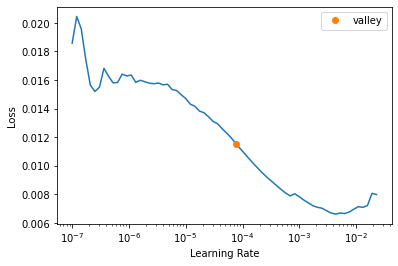

In [34]:
n = 1
list_preds =None
for i in range(0,n):
    #df_train = df.sample(frac=0.7, axis=0)
    #df_val = pd.concat([df,df_train])
    #df_val.drop_duplicates(subset=[ 'Pclass', 'Ticket_type', 'Sex', 'Words_Count'],keep='first',inplace=True)
    train =df.copy()
    #y_train = df.iloc[:,0]
    #x_val =df_val.iloc[:,1:]
    #y_val = df_val.iloc[:,0]
    #preds = train_predict2(x_train,y_train,x_val,y_val,test)
    
    features = ['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked', 'Ticket_type',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Age_new', 'Title',
       'Words_Count']
    train = pd.get_dummies(df[features])
    test = pd.get_dummies(test_df[features])
    train = pd.concat([df.iloc[:,0],train],axis=1)
    procs = [Categorify, FillMissing, Normalize]
    
    
    cat_names = ['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked', 'Ticket_type',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Age_new', 'Title',
       'Words_Count']
    dls = TabularDataLoaders.from_df(train, path, procs=procs, cat_names=cat_names, cont_names=[], 
                                 y_names='Survived', valid_idx=list(range(600,800)), bs=128,y_block = CategoryBlock)
    learn = tabular_learner(dls,metrics=RocAucBinary(),layers=[500,250],loss_func=FocalLossFlat(gamma=15))
    learn.lr_find()
    learn.fit_one_cycle(500)
    #df.head()
    dl = learn.dls.test_dl(test)
    preds=learn.get_preds(dl=dl)
    #model = RandomForestClassifier(n_estimators=10000,  random_state=2)
    #model.fit(x_train, y_train)
    #preds = model.predict(x_test)
    list_preds = preds[0][:,1]
    
    #submission = pd.read_csv('../input/titanic/gender_submission.csv')
    #submission['Survived'] = survived
    #submission.to_csv('submission_titanic.csv', index=False)
list_preds = pd.Series(list_preds.numpy())
preds = list_preds.round()
preds

In [27]:
preds = list_preds.mean(axis=0).round()
preds

0.4767394

In [17]:
#preds = preds.round()
#preds = pd.Series(preds.tolist())
#preds.head()

In [35]:
result_df = pd.read_csv(test_path, low_memory=False,skipinitialspace=True)
result_df.drop([ 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
result_df['Survived'] = preds
result_df['Survived'] = result_df['Survived'].astype('int64')
result_df.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [36]:
result_df.to_csv('./submission.csv',header=True,index=False)